## Code used for processing the energy consumption data from the experiments with parallel mini-batching in MOA


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import time
from IPython.display import display
from collections import Counter
import os
import re
import math
import random
pd.set_option('display.max_rows', 300)
pd.options.display.float_format = '{:,.2f}'.format

In [25]:
PATH_TO_RESULTS = '/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results/'

In [3]:
def filter_by_substring_algorithm(df, string):
    aux = df[df['algorithm'].str.contains(string, regex=False)]
    ret = aux
    if string == 'OB':
        ret = aux[~aux.algorithm.str.contains("Adwin|ASHT")]
    elif string == 'OzaBag':
        ret = aux[(aux.algorithm.str.contains(string)) & (~aux.algorithm.str.contains("Adwin|ASHT"))]
    return ret

***

# MOA logs

In [4]:
def parse_MOA(fname):
    global header_printed
    columns = []
    wanted = ['learning evaluation instances', 'Wall Time (Actual Time)', 'Avg Delay (ms)', 'outRate (inst/s)']
    pstr = ''
    spname = fname.split('/')[-1].split('-')
    spline = []
    for s in spname[1:]:
        pstr += s + ','
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                spline = line.split(',')
                for s in spline:
                    if s in wanted:
                        columns.append(spline.index(s))
            else:
                spline = line.split(',')
        for c in columns:
            pstr += spline[c] + ','
        if len(columns) == 2:
            pstr += '1,'
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,inc_rate,instances,time,delay,out_rate'
            pstr = f"{head}\n{pstr}"
            header_printed = True
        return (pstr[:-1])

In [5]:
def read_MOA(folder, out_file):
    directory = os.fsencode(folder)
    global header_printed

    with open(out_file, "w+") as output:
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("term-"): 
                output.write(f"{parse_MOA(f'{os.fsdecode(directory)}/{filename}')}\n")
    fname = os.fsdecode(out_file)
    df = pd.read_csv(fname)
    df['inc_rate'].astype('int64')
    return df[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'instances', 'time', 'delay', 'out_rate']] 

## Energy Data

In [6]:
def load_Wmeas(filename):
    return pd.read_csv(filename, header=None, names=['date', 'time', 'measure'])

In [7]:
def exper_order_to_dict(filename, d):
    with open(filename) as forder:
        got_timestamp = False
        dataset = algorithm = Esize = cores = Bsize = ''
        dnow=None
        for line in forder:
            if not got_timestamp:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
                if dnow:
                    dnow['finish'] = date_time_obj - datetime.timedelta(seconds=1)
            elif ':' not in line:
                spline = line.split('/')[-1].strip().split('-')
#                 print(spline)
                if len(spline) == 6:
                    dataset,algorithm,Esize,cores,Bsize,rate = spline
                else:
                    dataset,algorithm,Esize,cores,Bsize,rate = *spline,1
                if algorithm not in d:
                    d[algorithm] = {}
#                 if method not in d[algorithm]:
#                     d[algorithm][method] = {}
                if dataset not in d[algorithm]:
                    d[algorithm][dataset] = {}
                if Esize not in d[algorithm][dataset]:
                    d[algorithm][dataset][Esize] = {}
                if cores not in d[algorithm][dataset][Esize]:
                    d[algorithm][dataset][Esize][cores] = {}
                if Bsize not in d[algorithm][dataset][Esize][cores]:
                    d[algorithm][dataset][Esize][cores][Bsize] = {}
                if rate not in d[algorithm][dataset][Esize][cores][Bsize]:
                    d[algorithm][dataset][Esize][cores][Bsize][rate] = {'start': date_time_obj, 'finish': ''}
                    dnow = d[algorithm][dataset][Esize][cores][Bsize][rate]
                got_timestamp = False
            else:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
    return d

In [8]:
def populate_dict(d, df):
    df['datetime'] = df['date'] + ' ' + df['time']
    for k, v in d.items():
        for k1, v1 in v.items():
            for k2, v2 in v1.items():
                for k3, v3 in v2.items():
                    for k4, v4 in v3.items():
                        for k5, v5 in v4.items():
#                             for k6, v6 in v5.items():
                            if 'seconds' not in v5:
                                st = v5['start']
                                ed = v5['finish']
                                v5['seconds'] = (ed - st).seconds
                                new_df = df[(df.datetime <= f'{ed.strftime("%d/%m/%y")} {ed.strftime("%X")}')
                                          & (df.datetime >= f'{st.strftime("%d/%m/%y")} {st.strftime("%X")}')]
                                v5['avg_measure'] = new_df['measure'].mean()
                                v5['sum_measure'] = new_df['measure'].sum()
                                v5['avg_times_seconds'] = v5['avg_measure'] * v5['seconds']
    return d

In [9]:
def append_dict_to_df(d, ensemble_size=False):
    dappend = {'algorithm': [], 'dataset': [], 'ensemble_size': [], 'cores': [], 
               'batch_size': [], 'duration': [], 'inc_rate': [], 'avg_measure': [], 'sum_measure': [], 'avg_times_seconds': []}
    for kalg,valg in d.items():
        for kds,vds in valg.items():
            for kens,vens in vds.items():
                for kcore,vcore in vens.items():
                    for kmbs,vmbs in vcore.items():
                        for krate,vrate in vmbs.items():
                            dappend['algorithm'].append(kalg)
                            dappend['dataset'].append(kds)
                            dappend['ensemble_size'].append(kens)
                            dappend['cores'].append(kcore)
                            dappend['batch_size'].append(kmbs)
                            dappend['duration'].append(vrate['seconds'])
                            dappend['inc_rate'].append(krate)
                            for key in ['avg_measure', 'sum_measure','avg_times_seconds']:
                                dappend[key].append(vrate[key])
    adf = pd.DataFrame(data=dappend)
    adf = adf.sort_values(['algorithm','dataset']).astype({'inc_rate': 'int64', 
                                                           'cores': 'int64',
                                                           'batch_size': 'int64'})
    if ensemble_size:
        return adf[['algorithm', 'dataset', 'ensemble_size', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]
    return adf[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]

# Parse SSH logs

In [10]:
def parse_SSH(fname):
    fname = os.fsdecode(fname)
    read_ssh = False
    alg = ''
    dataset = ''
    rate = ''
    d = {'algorithm': [], 'dataset': [], 'batch_size': [], 'inc_rate': [], 'prod_rate': [], 'tt_inst_prod': []}
    with open (fname, "r") as file:
        for line in file:
            if not read_ssh:
                if 'ssh-' in line:
                    read_ssh = True
#                     print(line)
                    spline = line.split('-')
                    if "MAX" in line:
                        if len(spline[1:]) == 3:
                            dataset, alg, rate = spline[1:]
                            bsize = 500
                        else:
                            dataset, alg, bsize, rate = spline[1:]
                    else:
                        dataset, alg, rate = spline[1:]
                        bsize = 1
                    d['algorithm'].append(alg)
                    d['dataset'].append(dataset)
                    d['inc_rate'].append(rate.strip())
                    d['batch_size'].append(bsize)
            else:
                if 'Total instances Producer' in line:
                    tt_inst = float(line.split(': ')[1])
                    d['tt_inst_prod'].append(tt_inst)
                elif 'Producer Rate' in line:
                    prod_rate = float(line.split(': ')[1])
                    d['prod_rate'].append(prod_rate)
                    read_ssh = False
    return pd.DataFrame.from_dict(d).astype({'inc_rate': 'int64'})

# Showing and preparing for charts

In [11]:
def filter_fields(df):
    wanted = ['algorithm', 'dataset', 'batch_size', 'cores', 'out_rate', 'instances', 'delay', 'joules', 'JPI']
    return df[[
        l for l in df.columns if any([w in l for w in wanted])
    ]]

In [167]:
def rename_columns_by_rate(df):
    if df is not None:
        rate = df.PERC.iloc[0]
        return df.rename(columns={"out_rate": f"out_rate_{rate}", "instances": f"instances_{rate}", 
                                  "delay": f"delay_{rate}", "joules": f"joules_{rate}", 
                                  "JPI": f"JPI_{rate}", "tput": f"tput_{rate}"})
    return None


In [148]:
def show_graph_JPI_delay(df, ax, mJPI, mDel, legend=False, title=False, ylabels=False, ds='', bar=False, share_y=False, log_y=False, norm=False, hide=True):
    if norm:
        df = my_norm(df, x=norm)
    global rate
    global twin
    width = 0.15
    alg_order = ['Sequential', 'B1', 'B50', 'B250', 'B500']
    labels = ['10%', '50%', '90%']
    line_format = ['-', '--', ':', '-.', (0, (3, 5, 1, 5, 1, 5))]
    linfo = '--'
    x = np.arange(len(labels))
    lns_l = []
    versions = 5
    for i in range(versions):
        try:
            adf = df.iloc[i]
            values_j = [adf.JPI_10, adf.JPI_50, adf.JPI_90]
            if bar:
                lns_l += ax.bar(x - ((1 - i) * width), values_j, width, label=f'JPI-{alg_order[i]}')            
            else:
                lns_l += ax.plot(x, values_j, label=f'JPI-{alg_order[i]}')
        except IndexError:
            return None

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax_r = ax.twinx()
    twin = ax_r
    if log_y:
        ax.set_yscale('log')
        ax_r.set_yscale('log')
    if title:
        alg_title = re.sub('Sequential', '', df.algorithm.iloc[0])
        ax.set_title(f'{alg_title}')
#         ax.set_xlabel('Rate')
    if ylabels:
        ax.set_ylabel(ds)
#         ax.set_ylabel('JPI')
#         ax_r.set_ylabel('delay')
    if last:
        ax.set_ymargin(2)
    for i in range(versions): 
        adf = df.iloc[i]
        values_d = [ x/1000 for x in [adf.delay_10, adf.delay_50, adf.delay_90]]
        if bar:
            linfo = f'k{line_format[i]}'
            lns_l += ax_r.plot(x, values_d, color='black', linestyle=line_format[i], label=f'delay-{alg_order[i]}')
        else:
            lns_l += ax_r.plot(x, values_d, linfo, label=f'delay-{alg_order[i]}')
    labs = [l.get_label() for l in lns_l]
    if legend:
        ax.legend(lns_l, labs, loc=0)
    if hide:
        ax_r.set_yticklabels([])
    if share_y == 'row':
        ax.set_ylim(top=mJPI)
        ax_r.set_ylim(top=mDel/1000)

In [149]:
def aux_graphNx1(ds, axis, id_ds, df, bar=False, share_y='row', log_y=False, norm=False):
    #display(df)
#     print(f'aux {bar}')
    rates = ['10', '50', '90']
    algs = ['Ada', 'L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
    global title
    global labels
    hide_axis = True
#     fig.suptitle(f'JPI and delay for {ds}', fontsize=18, y=1)
#     get max value from delay for all rates on all algorithms for this dataset
    mLstJPI = []
    mLstDel = []
    if share_y == 'row':
        for rt in rates:
            rtDF = df[df.PERC == rt]
            mLstJPI.append(rtDF.JPI.max())
            mLstDel.append(rtDF.delay.max())
        mJPI = max(mLstJPI)*1.05
        mDel = max(mLstDel)*1.05
    else:
        mJPI = mDel = 0
    for alg in algs:
        dsalgdf = filter_by_substring_algorithm(df, alg).sort_values(['algorithm','batch_size','cores'])
#         if alg == 'L' and ds == 'kyoto_binary':
#             display(dsalgdf)
        for rt in rates:
            if rt == '10':
                showdf = rename_columns_by_rate(dsalgdf[dsalgdf.PERC == rt])
            else:
                to_join = dsalgdf[dsalgdf.PERC == rt]
                showdf = showdf.merge(rename_columns_by_rate(to_join),
                                  on=['algorithm', 'dataset', 'batch_size', 'cores']).sort_values(['batch_size','cores'])
        # debug print, if it shows it is wrong
        if len(showdf) != 5:
            display(showdf)

        if 'Ada' in alg:
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, ylabels=True, ds=ds, bar=bar, share_y=share_y, log_y=log_y, norm=norm)
        else:
            if algs[-1] == alg:
                hide_axis = False
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, bar=bar, share_y=share_y, log_y=log_y, norm=norm, hide=hide_axis)

In [176]:
def gen_graph(df, bars=False, share_y='row', log_y=False, norm=False, arch='Vostro', tput=False):
    ps = f'{arch}\nbars: {bars}\nshare_y: {share_y}\nlog_y: {log_y} '
    #datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm', 'kyoto_binary']
    datasets = ['elecNormNew','covtypeNorm', 'GMSC']
    fig, axis = plt.subplots(len(datasets), 6, figsize=(16,12), tight_layout=True, sharey=share_y)
    global title
    global labels
    global last
    global twin
    leg = False
    labls = True
    title = True
    last = False
    twin = axis[0][0]
    for ds in datasets:
        if datasets.index(ds) == (len(datasets) - 1):
            last = True
        dsdf = df[df.dataset == ds]
        aux_graphNx1(ds, axis, datasets.index(ds), dsdf, bar=bars, share_y=share_y, log_y=log_y, norm=norm)
        title = False
    lines_1, labels_1 = axis[0][0].get_legend_handles_labels()
    lines_2, labels_2 = twin.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    lgd = fig.legend(lines, labels, loc=8, ncol=5, bbox_to_anchor=(0.5, -0.02))
    lgd.set_in_layout(True)
    fig.subplots_adjust(bottom=-0.5)
    filename = 'all-4x1-JPI-delay'
    if bars:
        filename = f'bars-{filename}'
    if share_y:
        filename = f'sharey-{filename}'
    if log_y:
        filename = f'logy-{filename}'
    plt.savefig(f'../figures/{arch}-{filename}.eps', pad_inches=0.2, bbox_inches='tight')
    plt.savefig(f'../figures/{arch}-{filename}.png', pad_inches=0.2, bbox_inches='tight')
    plt.show()

# MAIN

- Create a separate dataframe for each "set of results" (MOA logs, ssh-log, exper_order and Wmeasure)
- Join/merge all dataframes together
- generate charts

In [177]:
def read_data_create_final_dataframe(freq, DEBUG=False):
    d = {}
    global header_printed
    header_printed = False
    moaDF = read_MOA(f"{PATH_TO_RESULTS}/socket/{freq}/{freq}", f"{PATH_TO_RESULTS}/socket/{freq}/{freq}/inst-and-delay.csv")
    moaDF = moaDF[["algorithm", "dataset", "cores", "batch_size", "inc_rate", "out_rate", "instances", "time", "delay"]]
    measureDF = load_Wmeas(f'{PATH_TO_RESULTS}/socket/{freq}/{freq}/Wm-{freq}.log')
    d = exper_order_to_dict(f'{PATH_TO_RESULTS}/socket/{freq}/{freq}/exper_order-freq-max-{freq}-freq-min-{freq}.log', d)
    d = populate_dict(d, measureDF)
    mdf = append_dict_to_df(d)
    sshDF = parse_SSH(f'{PATH_TO_RESULTS}/socket/{freq}/{freq}/ssh-log')
    sshDF['batch_size'] = sshDF['batch_size'].astype(int)
    if DEBUG:
        print(f'moaDF: {len(moaDF)}    mdf: {len(mdf)}     sshDF: {len(sshDF)}')
    #join dfs
    finaldf = moaDF.merge(mdf, on=['algorithm', 'dataset', 'cores', 'batch_size', 'inc_rate'])
    finaldf = finaldf.merge(sshDF, 'left', on=['algorithm', 'dataset', 'batch_size', 'inc_rate'])
    finaldf['joules'] = finaldf['avg_measure'] * finaldf['time']
    finaldf['JPI'] = finaldf['joules'] / finaldf['instances']
    # Add PERC column to identify if it used 90, 50 or 10% max rate
    # Before merging rows with the same batch size, we need to differentiate the experiments with different work loads
    # We use the **PERC**entage column for that
    tdf = finaldf.sort_values(by=['dataset','algorithm','batch_size','inc_rate'], ascending=False)
    tdf['PERC'] = 0
    if DEBUG:
        tdf.to_csv(f"{PATH_TO_RESULTS}/socket/tdf.csv")
    masks = {'90':[], '50': [], '10': []}
    for k, v in zip(masks.keys(), [0, 1, 2]):
        for i in range(len(tdf)):
            masks[k].append(i % 3 == v)
    tdf.loc[masks['90'],'PERC'] = '90'
    tdf.loc[masks['50'],'PERC'] = '50'
    tdf.loc[masks['10'],'PERC'] = '10'
    tdf['tput'] = tdf['instances']/tdf['time']
    return tdf

In [179]:
freqs = ['800', '1000', '1200']
dataframes = []
for f in freqs:
    dataframes.append(read_data_create_final_dataframe(f, True))

moaDF: 162    mdf: 162     sshDF: 174
moaDF: 162    mdf: 162     sshDF: 159
moaDF: 162    mdf: 162     sshDF: 233


# rerun airlines

['800', '1000', '1200']



----------------- 800 -----------------


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,17,15.00,"1,800.00",120.01,"1,797.00",123,...,192.00,124,NaN,0.00,149.73,"17,970.00",NaN,NaN,90,149.92
1,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,500,17,15.01,"1,800.00",119.96,"17,850.00",125,...,"2,257.00",125,NaN,0.00,149.73,"17,970.00",NaN,NaN,90,149.96
2,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,2000,17,15.01,"1,800.00",119.96,"73,957.00",138,...,"9,712.00",126,4.01,914.40,149.73,"17,970.00",480.55,0.03,90,149.97


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,LBagExecutorMAXChunk,elecNormNew,4,50,32,30.00,"3,600.00",120.00,880.00,125,...,107.00,126,NaN,0.00,289.35,"34,742.00",NaN,NaN,90,289.73
1,LBagExecutorMAXChunk,elecNormNew,4,500,32,30.01,"3,600.00",119.97,"9,184.00",125,...,"1,169.00",126,NaN,0.00,289.36,"34,742.00",NaN,NaN,90,289.81
2,LBagExecutorMAXChunk,elecNormNew,4,2000,32,30.01,"3,600.00",119.97,"35,733.00",127,...,"4,641.00",126,4.17,954.30,289.36,"34,742.00",499.54,0.01,90,289.80


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,50,4,19.99,"2,400.00",120.05,"1,359.00",123,...,720.00,124,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,39.98
1,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,500,4,20.01,"2,400.00",119.96,"14,507.00",124,...,"7,534.00",125,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,40.00
2,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,2000,4,20.01,"2,400.00",119.96,"54,293.00",126,...,"29,369.00",127,3.92,901.70,39.94,"4,800.00",470.40,0.10,90,40.00


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,79,74.88,"8,986.00",120.01,329.00,125,...,46.00,68,NaN,0.00,712.35,"45,312.00",NaN,NaN,90,714.00
1,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,500,79,74.88,"8,986.00",120.00,"3,561.00",125,...,498.00,69,NaN,0.00,712.49,"45,312.00",NaN,NaN,90,714.59
2,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,2000,79,74.88,"8,986.00",120.01,"13,850.00",126,...,"1,995.00",68,3.92,485.70,712.45,"45,312.00",248.38,0.01,90,713.39


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,41,40.00,"4,800.00",119.99,637.00,126,...,75.00,126,NaN,0.00,369.09,"44,326.00",NaN,NaN,90,369.63
1,OzaBagASHTExecutorMAXChunk,elecNormNew,4,500,41,40.01,"4,800.00",119.99,"6,412.00",125,...,794.00,125,NaN,0.00,369.10,"44,326.00",NaN,NaN,90,369.68
2,OzaBagASHTExecutorMAXChunk,elecNormNew,4,2000,41,40.01,"4,800.00",119.98,"24,163.00",126,...,"3,243.00",126,3.93,896.90,369.12,"44,326.00",471.65,0.01,90,369.70


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagExecutorMAXChunk,elecNormNew,4,50,95,94.98,"11,381.00",119.82,278.00,126,...,39.00,59,NaN,0.00,855.17,"45,312.00",NaN,NaN,90,857.76
1,OzaBagExecutorMAXChunk,elecNormNew,4,500,95,94.99,"11,381.00",119.82,"2,801.00",126,...,422.00,58,3.90,413.00,855.02,"45,312.00",205.76,0.00,90,858.04
2,OzaBagExecutorMAXChunk,elecNormNew,4,2000,95,94.84,"11,382.00",120.01,"11,380.00",125,...,"1,664.00",58,4.02,425.80,855.28,"45,312.00",212.06,0.00,90,850.37


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,50,11,10.00,"1,200.00",120.04,"2,649.00",123,...,318.00,124,NaN,0.00,NaN,NaN,NaN,NaN,90,99.99
1,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,500,11,10.00,"1,200.00",119.94,"25,518.00",125,...,"3,435.00",124,4.24,954.60,99.83,"11,980.00",508.33,0.04,90,99.99
2,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,2000,11,10.00,"1,200.00",119.94,"75,237.00",140,...,"15,358.00",126,3.97,909.40,99.84,"12,000.00",476.55,0.04,90,93.03


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,LBagExecutorMAXChunk,covtypeNorm,4,50,7,5.00,600.00,120.01,"5,174.00",125,...,540.00,126,NaN,0.00,64.90,"7,800.00",NaN,NaN,90,64.90
1,LBagExecutorMAXChunk,covtypeNorm,4,500,7,5.00,600.00,119.94,"46,264.00",126,...,"5,311.00",126,4.23,968.00,64.90,"7,800.00",507.23,0.07,90,65.00
2,LBagExecutorMAXChunk,covtypeNorm,4,2000,7,5.00,600.00,119.94,"64,547.00",130,...,"21,406.00",132,4.15,996.90,64.90,"7,800.00",498.44,0.06,90,65.00


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,4,19.97,"2,400.00",120.21,"1,509.00",124,...,842.00,125,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,39.89
1,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,500,4,20.01,"2,400.00",119.95,"16,107.00",126,...,"8,803.00",126,4.18,956.70,39.94,"4,800.00",501.24,0.10,90,40.01
2,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,2000,4,NaN,NaN,NaN,NaN,4366,...,"34,331.00",127,3.86,888.90,39.94,"4,800.00",463.67,0.10,90,40.01


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,6,5.00,600.00,120.07,"5,173.00",125,...,573.00,126,NaN,0.00,54.92,"6,600.00",NaN,NaN,90,54.94
1,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,500,6,5.00,600.00,119.94,"45,632.00",126,...,"6,115.00",126,4.11,903.30,54.92,"6,600.00",492.82,0.08,90,54.15
2,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,2000,6,5.00,600.00,119.94,"63,627.00",128,...,"22,939.00",127,3.87,890.20,54.92,"6,600.00",464.39,0.07,90,55.01


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,6,5.00,600.00,120.04,"5,226.00",125,...,590.00,125,3.69,722.30,54.91,"6,600.00",442.84,0.07,90,54.92
1,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,500,6,5.00,600.00,119.93,"46,326.00",126,...,"5,577.00",126,4.14,948.20,54.92,"6,600.00",496.85,0.08,90,55.00
2,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,2000,6,5.00,600.00,119.94,"64,454.00",129,...,"20,981.00",127,3.96,911.00,54.92,"6,600.00",475.26,0.07,90,55.01


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagExecutorMAXChunk,covtypeNorm,4,50,10,10.00,"1,200.00",120.03,"2,571.00",126,...,374.00,125,3.86,875.60,89.85,"10,800.00",462.91,0.04,90,89.85
1,OzaBagExecutorMAXChunk,covtypeNorm,4,500,10,10.01,"1,200.00",119.94,"24,036.00",125,...,"3,746.00",126,4.14,942.80,89.85,"10,782.00",495.44,0.05,90,89.99
2,OzaBagExecutorMAXChunk,covtypeNorm,4,2000,10,10.00,"1,200.00",119.94,"63,808.00",129,...,"15,768.00",128,3.94,917.50,89.85,"10,800.00",472.57,0.04,90,89.85


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,50,288,284.78,"34,143.00",119.89,109.00,126,...,184.00,125,NaN,0.00,159.73,"19,168.00",NaN,NaN,90,159.94
1,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,50,288,284.78,"34,143.00",119.89,109.00,126,...,184.00,125,NaN,0.00,159.73,"19,168.00",NaN,NaN,90,159.94
2,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,500,160,159.98,"19,168.00",119.82,"1,970.00",125,...,"9,074.00",125,3.80,863.40,29.96,"3,600.00",456.31,0.13,90,30.01
3,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,2000,160,159.98,"19,168.00",119.82,"7,854.00",124,...,"35,757.00",125,4.08,913.10,29.96,"3,600.00",489.03,0.14,90,30.01


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,LBagExecutorMAXChunk,GMSC,4,50,378,374.62,"44,925.00",119.92,61.00,128,...,139.00,128,NaN,0.00,209.61,"25,158.00",NaN,NaN,90,209.89
1,LBagExecutorMAXChunk,GMSC,4,50,378,374.62,"44,925.00",119.92,61.00,128,...,652.00,128,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,39.99
2,LBagExecutorMAXChunk,GMSC,4,50,378,374.62,"44,925.00",119.92,61.00,128,...,139.00,128,NaN,0.00,209.61,"25,158.00",NaN,NaN,90,209.89
3,LBagExecutorMAXChunk,GMSC,4,50,378,374.62,"44,925.00",119.92,61.00,128,...,652.00,128,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,39.99
4,LBagExecutorMAXChunk,GMSC,4,50,42,39.99,"4,800.00",120.02,652.00,128,...,139.00,128,NaN,0.00,209.61,"25,158.00",NaN,NaN,90,209.89
5,LBagExecutorMAXChunk,GMSC,4,50,42,39.99,"4,800.00",120.02,652.00,128,...,652.00,128,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,39.99
6,LBagExecutorMAXChunk,GMSC,4,50,42,39.99,"4,800.00",120.02,652.00,128,...,139.00,128,NaN,0.00,209.61,"25,158.00",NaN,NaN,90,209.89
7,LBagExecutorMAXChunk,GMSC,4,50,42,39.99,"4,800.00",120.02,652.00,128,...,652.00,128,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,39.99
8,LBagExecutorMAXChunk,GMSC,4,500,210,209.95,"25,158.00",119.83,"1,483.00",126,...,"6,643.00",126,3.81,834.90,39.94,"4,800.00",457.41,0.10,90,40.01
9,LBagExecutorMAXChunk,GMSC,4,2000,210,209.95,"25,158.00",119.83,"5,972.00",125,...,"25,676.00",126,4.15,950.10,39.94,"4,800.00",497.76,0.10,90,40.01


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,90,89.86,"10,783.00",120.00,333.00,125,...,200.00,125,NaN,0.00,159.73,"19,168.00",NaN,NaN,90,159.92
1,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,90,89.86,"10,783.00",120.00,333.00,125,...,"1,776.00",125,NaN,0.00,14.98,"1,800.00",NaN,NaN,90,15.00
2,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,90,89.86,"10,783.00",120.00,333.00,125,...,200.00,125,NaN,0.00,159.73,"19,168.00",NaN,NaN,90,159.92
3,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,90,89.86,"10,783.00",120.00,333.00,125,...,"1,776.00",125,NaN,0.00,14.98,"1,800.00",NaN,NaN,90,15.00
4,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,500,18,15.01,"1,800.00",119.95,"17,999.00",124,...,"2,128.00",125,3.76,850.30,159.73,"19,168.00",450.79,0.02,90,159.98
5,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,2000,18,15.01,"1,800.00",119.96,"69,962.00",134,...,"8,725.00",125,3.95,897.70,159.73,"19,200.00",474.60,0.02,90,159.73


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,968,962.75,"115,414.00",119.88,33.00,128,...,54.00,128,NaN,0.00,533.72,"64,093.00",NaN,NaN,90,534.35
1,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,968,962.75,"115,414.00",119.88,33.00,128,...,251.00,128,NaN,0.00,104.83,"12,600.00",NaN,NaN,90,104.83
2,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,968,962.75,"115,414.00",119.88,33.00,128,...,54.00,128,NaN,0.00,533.72,"64,093.00",NaN,NaN,90,534.35
3,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,968,962.75,"115,414.00",119.88,33.00,128,...,251.00,128,NaN,0.00,104.83,"12,600.00",NaN,NaN,90,104.83
4,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,107,104.83,"12,580.00",120.00,251.00,128,...,54.00,128,NaN,0.00,533.72,"64,093.00",NaN,NaN,90,534.35
5,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,107,104.83,"12,580.00",120.00,251.00,128,...,251.00,128,NaN,0.00,104.83,"12,600.00",NaN,NaN,90,104.83
6,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,107,104.83,"12,580.00",120.00,251.00,128,...,54.00,128,NaN,0.00,533.72,"64,093.00",NaN,NaN,90,534.35
7,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,107,104.83,"12,580.00",120.00,251.00,128,...,251.00,128,NaN,0.00,104.83,"12,600.00",NaN,NaN,90,104.83
8,OzaBagAdwinExecutorMAXChunk,GMSC,4,500,537,533.19,"64,000.00",120.03,572.00,125,...,"2,546.00",126,3.82,875.70,104.83,"12,600.00",458.90,0.04,90,104.83
9,OzaBagAdwinExecutorMAXChunk,GMSC,4,2000,537,532.19,"64,000.00",120.26,"2,331.00",125,...,"10,085.00",126,4.10,934.80,104.83,"12,600.00",492.01,0.04,90,104.83


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1530,"1,525.29","150,000.00",98.34,22.00,106,...,31.00,128,NaN,0.00,847.17,"101,830.00",NaN,NaN,90,847.14
1,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1530,"1,525.29","150,000.00",98.34,22.00,106,...,153.00,128,NaN,0.00,169.71,"20,366.00",NaN,NaN,90,169.97
2,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1530,"1,525.29","150,000.00",98.34,22.00,106,...,31.00,128,NaN,0.00,847.17,"101,830.00",NaN,NaN,90,847.14
3,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1530,"1,525.29","150,000.00",98.34,22.00,106,...,153.00,128,NaN,0.00,169.71,"20,366.00",NaN,NaN,90,169.97
4,OzaBagASHTExecutorMAXChunk,GMSC,4,50,170,169.97,"20,366.00",119.82,153.00,128,...,31.00,128,NaN,0.00,847.17,"101,830.00",NaN,NaN,90,847.14
5,OzaBagASHTExecutorMAXChunk,GMSC,4,50,170,169.97,"20,366.00",119.82,153.00,128,...,153.00,128,NaN,0.00,169.71,"20,366.00",NaN,NaN,90,169.97
6,OzaBagASHTExecutorMAXChunk,GMSC,4,50,170,169.97,"20,366.00",119.82,153.00,128,...,31.00,128,NaN,0.00,847.17,"101,830.00",NaN,NaN,90,847.14
7,OzaBagASHTExecutorMAXChunk,GMSC,4,50,170,169.97,"20,366.00",119.82,153.00,128,...,153.00,128,NaN,0.00,169.71,"20,366.00",NaN,NaN,90,169.97
8,OzaBagASHTExecutorMAXChunk,GMSC,4,500,850,848.17,"101,781.00",120.00,365.00,126,...,"1,590.00",126,3.76,496.20,169.70,"20,366.00",450.42,0.02,90,169.97
9,OzaBagASHTExecutorMAXChunk,GMSC,4,2000,850,848.70,"101,830.00",119.98,"1,532.00",126,...,"6,441.00",125,3.99,901.80,169.71,"20,366.00",478.07,0.02,90,169.99


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagExecutorMAXChunk,GMSC,4,50,977,972.84,"116,610.00",119.86,30.00,126,...,52.00,4917,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,539.38
1,OzaBagExecutorMAXChunk,GMSC,4,50,977,972.84,"116,610.00",119.86,30.00,126,...,248.00,128,NaN,0.00,104.83,"12,600.00",NaN,NaN,90,104.83
2,OzaBagExecutorMAXChunk,GMSC,4,50,108,104.83,"12,580.00",120.00,248.00,128,...,52.00,4917,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,539.38
3,OzaBagExecutorMAXChunk,GMSC,4,50,108,104.83,"12,580.00",120.00,248.00,128,...,248.00,128,NaN,0.00,104.83,"12,600.00",NaN,NaN,90,104.83
4,OzaBagExecutorMAXChunk,GMSC,4,500,977,972.42,"116,610.00",119.92,330.00,125,...,544.00,126,NaN,0.00,538.61,"64,692.00",NaN,NaN,90,539.46
5,OzaBagExecutorMAXChunk,GMSC,4,2000,977,973.19,"116,610.00",119.82,"1,368.00",126,...,"2,210.00",126,4.17,954.00,538.68,"64,692.00",499.53,0.01,90,539.51


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


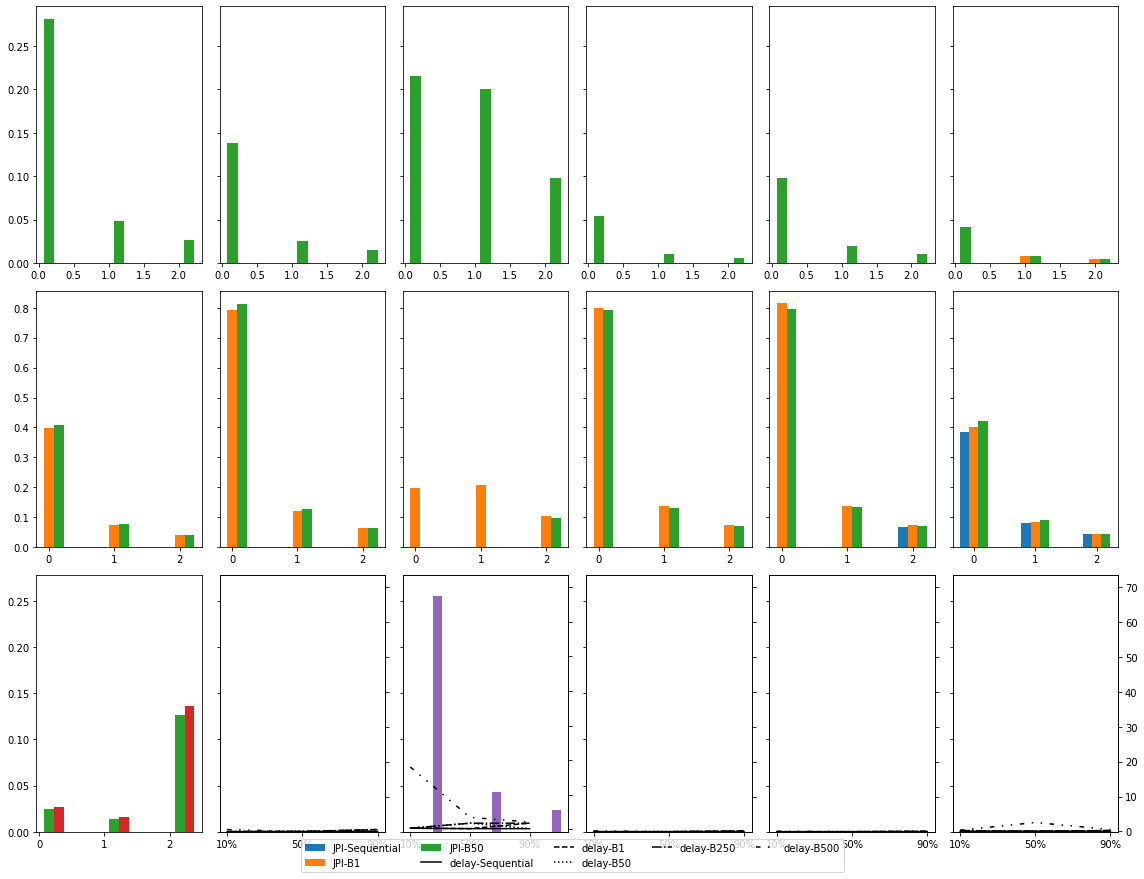




----------------- 1000 -----------------


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,19,15.00,"1,800.00",120.01,"1,786.00",123,...,179.00,124,NaN,0.00,174.67,"20,965.00",NaN,NaN,90,174.88
1,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,500,19,15.01,"1,800.00",119.96,"18,269.00",124,...,"2,018.00",125,NaN,0.00,174.67,"20,965.00",NaN,NaN,90,174.94
2,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,2000,19,15.01,"1,800.00",119.95,"76,649.00",141,...,"8,056.00",125,3.99,872.90,174.67,"20,965.00",477.65,0.02,90,174.70


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,LBagExecutorMAXChunk,elecNormNew,4,50,31,30.00,"3,600.00",120.00,876.00,126,...,109.00,126,NaN,0.00,284.36,"34,143.00",NaN,NaN,90,284.71
1,LBagExecutorMAXChunk,elecNormNew,4,500,31,30.01,"3,600.00",119.97,"9,158.00",126,...,"1,192.00",125,NaN,0.00,284.36,"34,143.00",NaN,NaN,90,284.81
2,LBagExecutorMAXChunk,elecNormNew,4,2000,31,30.01,"3,600.00",119.97,"35,801.00",127,...,"4,753.00",127,4.23,972.40,284.39,"34,143.00",506.79,0.01,90,282.54


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,50,4,19.99,"2,400.00",120.09,"1,382.00",125,...,734.00,124,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,39.97
1,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,500,4,20.01,"2,400.00",119.96,"14,320.00",125,...,"7,425.00",124,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,40.00
2,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,2000,4,20.01,"2,400.00",119.96,"54,993.00",126,...,"29,240.00",126,3.88,885.70,39.94,"4,800.00",466.10,0.10,90,40.01


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,79,74.88,"8,986.00",120.01,330.00,125,...,48.00,69,NaN,0.00,712.52,"45,312.00",NaN,NaN,90,714.09
1,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,500,79,74.88,"8,986.00",120.00,"3,567.00",126,...,493.00,68,NaN,0.00,712.51,"45,312.00",NaN,NaN,90,714.62
2,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,2000,79,74.88,"8,986.00",120.00,"13,821.00",126,...,"1,993.00",68,3.97,491.70,712.50,"45,312.00",251.43,0.01,90,708.93


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,41,40.00,"4,800.00",120.00,632.00,125,...,50.00,125,NaN,0.00,374.07,"44,925.00",NaN,NaN,90,374.62
1,OzaBagASHTExecutorMAXChunk,elecNormNew,4,500,41,40.01,"4,800.00",119.99,"6,411.00",126,...,775.00,126,NaN,0.00,374.08,"44,925.00",NaN,NaN,90,374.67
2,OzaBagASHTExecutorMAXChunk,elecNormNew,4,2000,41,40.01,"4,800.00",119.98,"24,383.00",126,...,"3,193.00",125,3.88,879.90,374.11,"44,925.00",464.75,0.01,90,374.69


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagExecutorMAXChunk,elecNormNew,4,50,92,89.99,"10,782.00",119.82,286.00,126,...,40.00,60,NaN,0.00,830.06,"45,312.00",NaN,NaN,90,832.73
1,OzaBagExecutorMAXChunk,elecNormNew,4,500,92,89.99,"10,782.00",119.81,"2,947.00",126,...,389.00,60,3.95,434.70,829.91,"45,312.00",215.02,0.00,90,832.77
2,OzaBagExecutorMAXChunk,elecNormNew,4,2000,92,89.99,"10,782.00",119.81,"11,682.00",126,...,"1,655.00",59,3.86,416.80,830.21,"45,312.00",209.92,0.00,90,824.21


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,50,12,10.00,"1,200.00",120.04,"2,627.00",124,...,316.00,124,NaN,0.00,109.81,"13,178.00",NaN,NaN,90,109.98
1,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,500,12,10.00,"1,200.00",119.94,"26,232.00",125,...,"3,213.00",125,4.13,937.30,109.81,"13,178.00",494.73,0.04,90,109.99
2,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,2000,12,10.00,"1,200.00",119.94,"71,651.00",136,...,"13,173.00",126,4.00,911.00,109.81,"13,178.00",478.74,0.04,90,109.99


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,LBagExecutorMAXChunk,covtypeNorm,4,50,7,5.00,600.00,120.01,"5,183.00",126,...,545.00,126,NaN,0.00,64.90,"7,800.00",NaN,NaN,90,64.92
1,LBagExecutorMAXChunk,covtypeNorm,4,500,7,5.00,600.00,119.94,"47,589.00",126,...,"5,279.00",127,4.05,932.30,64.90,"7,800.00",486.42,0.06,90,65.00
2,LBagExecutorMAXChunk,covtypeNorm,4,2000,7,5.00,600.00,119.94,"65,191.00",130,...,"22,060.00",132,3.96,946.10,64.90,"7,800.00",475.02,0.06,90,65.00


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,4,19.97,"2,400.00",120.20,"1,519.00",125,...,872.00,125,NaN,0.00,39.95,"4,800.00",NaN,NaN,90,39.93
1,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,500,4,20.01,"2,400.00",119.95,"16,125.00",126,...,"8,792.00",125,4.01,909.70,39.94,"4,800.00",480.81,0.10,90,40.01
2,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,2000,4,NaN,NaN,NaN,NaN,618,...,"34,001.00",128,4.18,969.30,39.95,"4,800.00",501.25,0.10,90,40.01


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,6,5.00,600.00,120.06,"5,235.00",125,...,571.00,126,NaN,0.00,54.91,"6,600.00",NaN,NaN,90,54.94
1,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,500,6,5.00,600.00,119.94,"46,542.00",126,...,"6,160.00",125,4.07,923.60,54.92,"6,600.00",488.45,0.08,90,54.14
2,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,2000,6,5.00,600.00,119.94,"63,390.00",128,...,"21,764.00",127,4.40,"1,011.80",54.92,"6,600.00",527.86,0.08,90,55.00


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,6,5.00,600.00,120.04,"5,143.00",125,...,547.00,125,NaN,0.00,59.91,"7,200.00",NaN,NaN,90,59.91
1,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,500,6,5.00,600.00,119.94,"45,524.00",126,...,"5,138.00",125,4.04,916.20,59.91,"7,200.00",484.33,0.07,90,60.00
2,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,2000,6,5.00,600.00,119.94,"63,144.00",128,...,"19,913.00",128,4.28,992.90,59.91,"7,200.00",513.57,0.07,90,60.00


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagExecutorMAXChunk,covtypeNorm,4,50,9,5.00,600.00,120.02,"5,121.00",125,...,430.00,125,NaN,0.00,84.86,"10,183.00",NaN,NaN,90,84.99
1,OzaBagExecutorMAXChunk,covtypeNorm,4,500,9,5.00,600.00,119.93,"45,555.00",126,...,"4,223.00",125,4.17,924.90,84.86,"10,200.00",499.95,0.05,90,84.87
2,OzaBagExecutorMAXChunk,covtypeNorm,4,2000,9,5.00,600.00,119.93,"63,174.00",129,...,"16,186.00",127,4.10,942.80,84.86,"10,200.00",503.58,0.05,90,81.40


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,50,32,30.00,"3,600.00",120.00,870.00,140,...,105.00,124,NaN,0.00,289.37,"34,742.00",NaN,NaN,90,289.75
1,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,50,32,30.00,"3,600.00",120.00,870.00,140,...,870.00,140,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,30.00
2,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,500,32,30.01,"3,600.00",119.97,"9,074.00",125,...,"1,213.00",124,NaN,0.00,289.39,"34,742.00",NaN,NaN,90,289.84
3,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,2000,32,30.01,"3,600.00",119.97,"35,813.00",126,...,"4,796.00",124,4.10,921.90,289.40,"34,742.00",491.11,0.01,90,289.85


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,LBagExecutorMAXChunk,GMSC,4,50,41,39.99,"4,800.00",120.02,650.00,125,...,86.00,125,NaN,0.00,369.15,"44,326.00",NaN,NaN,90,369.65
1,LBagExecutorMAXChunk,GMSC,4,500,41,40.01,"4,800.00",119.98,"6,721.00",126,...,927.00,126,NaN,0.00,369.15,"44,326.00",NaN,NaN,90,369.73
2,LBagExecutorMAXChunk,GMSC,4,2000,41,40.01,"4,800.00",119.98,"25,312.00",126,...,"3,724.00",126,4.06,930.40,369.17,"44,326.00",487.79,0.01,90,366.48


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,14,10.00,"1,200.00",120.03,"2,598.00",124,...,197.00,123,NaN,0.00,69.89,"8,400.00",NaN,NaN,90,124.98
1,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,500,14,10.00,"1,200.00",119.94,"25,462.00",124,...,"2,580.00",125,NaN,0.00,124.79,"14,975.00",NaN,NaN,90,124.99
2,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,2000,14,10.00,"1,200.00",119.95,"68,421.00",132,...,"10,794.00",125,3.95,896.90,124.79,"15,000.00",474.16,0.03,90,124.79


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,110,109.99,"13,178.00",119.82,235.00,126,...,32.00,125,NaN,0.00,991.30,"119,002.00",NaN,NaN,90,992.51
1,OzaBagAdwinExecutorMAXChunk,GMSC,4,500,110,109.82,"13,179.00",120.01,"2,432.00",125,...,338.00,126,NaN,0.00,991.42,"119,002.00",NaN,NaN,90,992.38
2,OzaBagAdwinExecutorMAXChunk,GMSC,4,2000,110,109.82,"13,179.00",120.01,"9,624.00",125,...,"1,372.00",126,3.91,892.40,991.44,"119,002.00",469.05,0.00,90,993.02


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagASHTExecutorMAXChunk,GMSC,4,50,153,149.97,"17,970.00",119.82,147.00,126,...,24.00,115,NaN,0.00,"1,372.71","150,000.00",NaN,NaN,90,"1,374.55"
1,OzaBagASHTExecutorMAXChunk,GMSC,4,500,153,149.98,"17,970.00",119.81,"1,793.00",125,...,246.00,115,NaN,0.00,"1,372.85","150,000.00",NaN,NaN,90,"1,374.18"
2,OzaBagASHTExecutorMAXChunk,GMSC,4,2000,153,149.97,"17,970.00",119.82,"7,321.00",126,...,"1,039.00",114,3.84,795.30,"1,372.70","150,000.00",420.38,0.00,90,"1,370.91"


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagExecutorMAXChunk,GMSC,4,50,109,104.83,"12,580.00",120.01,248.00,126,...,32.00,126,NaN,0.00,981.39,"117,806.00",NaN,NaN,90,982.62
1,OzaBagExecutorMAXChunk,GMSC,4,500,109,105.00,"12,600.00",120.00,"2,544.00",126,...,330.00,126,3.76,26.30,981.54,"117,806.00",450.24,0.00,90,983.06
2,OzaBagExecutorMAXChunk,GMSC,4,2000,109,105.00,"12,600.00",120.00,"10,054.00",126,...,"1,367.00",125,4.10,926.20,981.56,"117,806.00",491.08,0.00,90,983.13


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


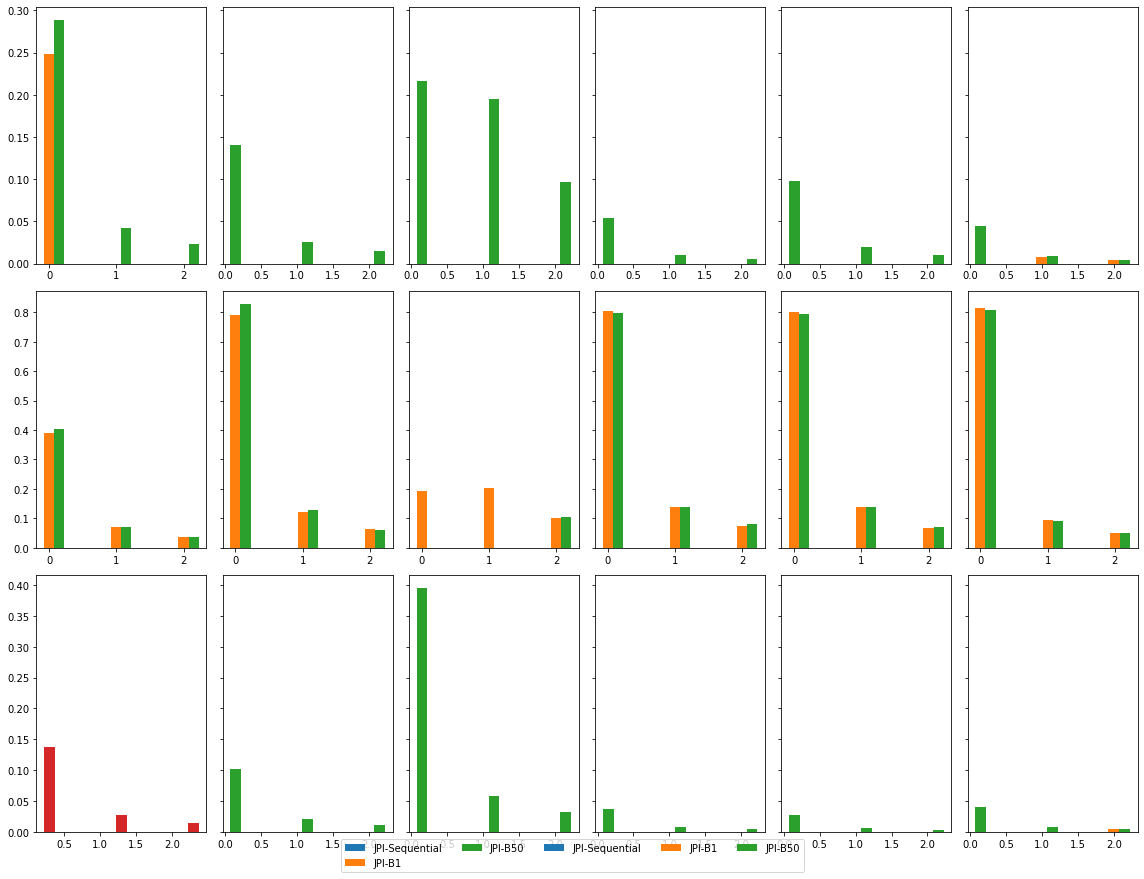




----------------- 1200 -----------------


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,192,189.82,"22,762.00",119.92,171.00,124,...,171.00,124,NaN,0.00,189.63,"22,762.00",NaN,NaN,90,189.82
1,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,192,189.82,"22,762.00",119.92,171.00,124,...,294.00,125,NaN,0.00,104.82,"12,579.00",NaN,NaN,90,104.98
2,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,192,189.82,"22,762.00",119.92,171.00,124,...,"1,331.00",124,NaN,0.00,19.97,"2,400.00",NaN,NaN,90,19.99
3,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,192,189.82,"22,762.00",119.92,171.00,124,...,171.00,124,NaN,0.00,189.63,"22,762.00",NaN,NaN,90,189.82
4,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,192,189.82,"22,762.00",119.92,171.00,124,...,294.00,125,NaN,0.00,104.82,"12,579.00",NaN,NaN,90,104.98
5,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,192,189.82,"22,762.00",119.92,171.00,124,...,"1,331.00",124,NaN,0.00,19.97,"2,400.00",NaN,NaN,90,19.99
6,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,192,189.82,"22,762.00",119.92,171.00,124,...,171.00,124,NaN,0.00,189.63,"22,762.00",NaN,NaN,90,189.82
7,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,192,189.82,"22,762.00",119.92,171.00,124,...,294.00,125,NaN,0.00,104.82,"12,579.00",NaN,NaN,90,104.98
8,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,192,189.82,"22,762.00",119.92,171.00,124,...,"1,331.00",124,NaN,0.00,19.97,"2,400.00",NaN,NaN,90,19.99
9,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,107,104.98,"12,579.00",119.82,294.00,125,...,171.00,124,NaN,0.00,189.63,"22,762.00",NaN,NaN,90,189.82


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,LBagExecutorMAXChunk,elecNormNew,4,50,303,299.76,"35,940.00",119.90,98.00,126,...,98.00,126,NaN,0.00,299.33,"35,940.00",NaN,NaN,90,299.76
1,LBagExecutorMAXChunk,elecNormNew,4,50,303,299.76,"35,940.00",119.90,98.00,126,...,180.00,126,NaN,0.00,164.69,"19,767.00",NaN,NaN,90,164.90
2,LBagExecutorMAXChunk,elecNormNew,4,50,303,299.76,"35,940.00",119.90,98.00,126,...,880.00,9353,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,30.00
3,LBagExecutorMAXChunk,elecNormNew,4,50,303,299.76,"35,940.00",119.90,98.00,126,...,98.00,126,NaN,0.00,299.33,"35,940.00",NaN,NaN,90,299.76
4,LBagExecutorMAXChunk,elecNormNew,4,50,303,299.76,"35,940.00",119.90,98.00,126,...,180.00,126,NaN,0.00,164.69,"19,767.00",NaN,NaN,90,164.90
5,LBagExecutorMAXChunk,elecNormNew,4,50,303,299.76,"35,940.00",119.90,98.00,126,...,880.00,9353,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,30.00
6,LBagExecutorMAXChunk,elecNormNew,4,50,168,164.90,"19,767.00",119.87,180.00,126,...,98.00,126,NaN,0.00,299.33,"35,940.00",NaN,NaN,90,299.76
7,LBagExecutorMAXChunk,elecNormNew,4,50,168,164.90,"19,767.00",119.87,180.00,126,...,180.00,126,NaN,0.00,164.69,"19,767.00",NaN,NaN,90,164.90
8,LBagExecutorMAXChunk,elecNormNew,4,50,168,164.90,"19,767.00",119.87,180.00,126,...,880.00,9353,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,30.00
9,LBagExecutorMAXChunk,elecNormNew,4,50,168,164.90,"19,767.00",119.87,180.00,126,...,98.00,126,NaN,0.00,299.33,"35,940.00",NaN,NaN,90,299.76


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,50,23,19.99,"2,400.00",120.04,"1,365.00",124,...,715.00,123,NaN,0.00,19.97,"2,400.00",NaN,NaN,90,39.98
1,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,50,23,19.99,"2,400.00",120.04,"1,365.00",124,...,"1,360.00",123,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.99
2,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,50,23,19.99,"2,400.00",120.04,"1,365.00",124,...,715.00,123,NaN,0.00,19.97,"2,400.00",NaN,NaN,90,39.98
3,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,50,23,19.99,"2,400.00",120.04,"1,365.00",124,...,"1,360.00",123,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.99
4,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,500,4,20.01,"2,400.00",119.96,"14,311.00",125,...,"7,397.00",124,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,40.01
5,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,2000,4,20.01,"2,400.00",119.96,"55,137.00",125,...,"29,458.00",125,3.92,857.80,39.94,"4,800.00",469.96,0.10,90,40.01


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,668,663.87,"45,312.00",68.25,49.00,73,...,49.00,73,NaN,0.00,662.40,"45,312.00",NaN,NaN,90,663.87
1,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,668,663.87,"45,312.00",68.25,49.00,73,...,371.00,126,NaN,0.00,69.89,"8,400.00",NaN,NaN,90,69.89
2,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,668,663.87,"45,312.00",68.25,49.00,73,...,49.00,73,NaN,0.00,662.40,"45,312.00",NaN,NaN,90,663.87
3,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,668,663.87,"45,312.00",68.25,49.00,73,...,371.00,126,NaN,0.00,69.89,"8,400.00",NaN,NaN,90,69.89
4,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,371,369.65,"44,326.00",119.92,78.00,126,...,49.00,73,NaN,0.00,662.40,"45,312.00",NaN,NaN,90,663.87
5,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,371,369.65,"44,326.00",119.92,78.00,126,...,371.00,126,NaN,0.00,69.89,"8,400.00",NaN,NaN,90,69.89
6,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,371,369.65,"44,326.00",119.92,78.00,126,...,49.00,73,NaN,0.00,662.40,"45,312.00",NaN,NaN,90,663.87
7,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,371,369.65,"44,326.00",119.92,78.00,126,...,371.00,126,NaN,0.00,69.89,"8,400.00",NaN,NaN,90,69.89
8,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,500,668,664.21,"45,312.00",68.22,508.00,73,...,824.00,126,NaN,0.00,369.08,"44,326.00",NaN,NaN,90,369.66
9,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,2000,668,641.99,"44,088.00",68.67,"2,126.00",73,...,"3,342.00",126,3.93,896.20,369.08,"44,326.00",471.31,0.01,90,369.67


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,320,319.77,"38,336.00",119.89,85.00,126,...,85.00,126,NaN,0.00,319.28,"38,336.00",NaN,NaN,90,319.77
1,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,320,319.77,"38,336.00",119.89,85.00,126,...,733.00,126,NaN,0.00,34.95,"4,200.00",NaN,NaN,90,35.00
2,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,320,319.77,"38,336.00",119.89,85.00,126,...,85.00,126,NaN,0.00,319.28,"38,336.00",NaN,NaN,90,319.77
3,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,320,319.77,"38,336.00",119.89,85.00,126,...,733.00,126,NaN,0.00,34.95,"4,200.00",NaN,NaN,90,35.00
4,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,178,174.93,"20,965.00",119.85,142.00,125,...,85.00,126,NaN,0.00,319.28,"38,336.00",NaN,NaN,90,319.77
5,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,178,174.93,"20,965.00",119.85,142.00,125,...,733.00,126,NaN,0.00,34.95,"4,200.00",NaN,NaN,90,35.00
6,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,178,174.93,"20,965.00",119.85,142.00,125,...,85.00,126,NaN,0.00,319.28,"38,336.00",NaN,NaN,90,319.77
7,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,178,174.93,"20,965.00",119.85,142.00,125,...,733.00,126,NaN,0.00,34.95,"4,200.00",NaN,NaN,90,35.00
8,OzaBagASHTExecutorMAXChunk,elecNormNew,4,500,320,319.75,"38,336.00",119.89,904.00,126,...,"1,567.00",125,NaN,0.00,174.67,"20,965.00",NaN,NaN,90,174.95
9,OzaBagASHTExecutorMAXChunk,elecNormNew,4,2000,320,319.77,"38,336.00",119.89,"3,642.00",125,...,"6,265.00",126,3.84,875.40,174.67,"20,965.00",460.10,0.02,90,174.95


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagExecutorMAXChunk,elecNormNew,4,50,852,848.11,"45,312.00",53.43,35.00,59,...,35.00,59,NaN,0.00,845.42,"45,312.00",NaN,NaN,90,848.11
1,OzaBagExecutorMAXChunk,elecNormNew,4,50,852,848.11,"45,312.00",53.43,35.00,59,...,287.00,125,NaN,0.00,89.84,"10,782.00",NaN,NaN,90,89.99
2,OzaBagExecutorMAXChunk,elecNormNew,4,50,852,848.11,"45,312.00",53.43,35.00,59,...,35.00,59,NaN,0.00,845.42,"45,312.00",NaN,NaN,90,848.11
3,OzaBagExecutorMAXChunk,elecNormNew,4,50,852,848.11,"45,312.00",53.43,35.00,59,...,287.00,125,NaN,0.00,89.84,"10,782.00",NaN,NaN,90,89.99
4,OzaBagExecutorMAXChunk,elecNormNew,4,50,473,468.73,"45,312.00",96.67,61.00,102,...,35.00,59,NaN,0.00,845.42,"45,312.00",NaN,NaN,90,848.11
5,OzaBagExecutorMAXChunk,elecNormNew,4,50,473,468.73,"45,312.00",96.67,61.00,102,...,287.00,125,NaN,0.00,89.84,"10,782.00",NaN,NaN,90,89.99
6,OzaBagExecutorMAXChunk,elecNormNew,4,50,473,468.73,"45,312.00",96.67,61.00,102,...,35.00,59,NaN,0.00,845.42,"45,312.00",NaN,NaN,90,848.11
7,OzaBagExecutorMAXChunk,elecNormNew,4,50,473,468.73,"45,312.00",96.67,61.00,102,...,287.00,125,NaN,0.00,89.84,"10,782.00",NaN,NaN,90,89.99
8,OzaBagExecutorMAXChunk,elecNormNew,4,500,852,848.51,"45,312.00",53.40,410.00,59,...,652.00,102,3.74,78.60,467.83,"45,312.00",361.80,0.01,90,468.76
9,OzaBagExecutorMAXChunk,elecNormNew,4,2000,852,832.15,"44,437.00",53.40,"1,721.00",58,...,"2,615.00",103,3.98,745.00,467.79,"45,312.00",385.15,0.01,90,468.71


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,50,96,94.84,"11,382.00",120.01,371.00,124,...,531.00,125,NaN,0.00,49.93,"6,000.00",NaN,NaN,90,49.95
1,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,50,96,94.84,"11,382.00",120.01,371.00,124,...,531.00,125,NaN,0.00,49.93,"6,000.00",NaN,NaN,90,49.95
2,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,50,10,9.99,"1,200.00",120.07,"2,630.00",123,...,531.00,125,NaN,0.00,49.93,"6,000.00",NaN,NaN,90,49.95
3,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,50,10,9.99,"1,200.00",120.07,"2,630.00",123,...,531.00,125,NaN,0.00,49.93,"6,000.00",NaN,NaN,90,49.95
4,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,500,53,49.63,"6,000.00",120.90,"6,205.00",125,...,"25,606.00",125,3.91,883.50,9.99,"1,200.00",468.88,0.39,90,10.01
5,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,2000,53,48.83,"6,000.00",122.89,"26,106.00",127,...,"70,864.00",135,4.02,982.00,9.99,"1,200.00",482.74,0.40,90,10.00


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,LBagExecutorMAXChunk,covtypeNorm,4,50,63,59.88,"7,200.00",120.24,559.00,125,...,867.00,126,NaN,0.00,34.95,"4,200.00",NaN,NaN,90,34.96
1,LBagExecutorMAXChunk,covtypeNorm,4,50,63,59.88,"7,200.00",120.24,559.00,125,...,"5,261.00",125,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
2,LBagExecutorMAXChunk,covtypeNorm,4,50,63,59.88,"7,200.00",120.24,559.00,125,...,867.00,126,NaN,0.00,34.95,"4,200.00",NaN,NaN,90,34.96
3,LBagExecutorMAXChunk,covtypeNorm,4,50,63,59.88,"7,200.00",120.24,559.00,125,...,"5,261.00",125,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
4,LBagExecutorMAXChunk,covtypeNorm,4,50,7,5.00,600.00,120.06,"5,261.00",125,...,867.00,126,NaN,0.00,34.95,"4,200.00",NaN,NaN,90,34.96
5,LBagExecutorMAXChunk,covtypeNorm,4,50,7,5.00,600.00,120.06,"5,261.00",125,...,"5,261.00",125,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
6,LBagExecutorMAXChunk,covtypeNorm,4,50,7,5.00,600.00,120.06,"5,261.00",125,...,867.00,126,NaN,0.00,34.95,"4,200.00",NaN,NaN,90,34.96
7,LBagExecutorMAXChunk,covtypeNorm,4,50,7,5.00,600.00,120.06,"5,261.00",125,...,"5,261.00",125,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
8,LBagExecutorMAXChunk,covtypeNorm,4,500,35,35.01,"4,200.00",119.97,"8,600.00",126,...,"46,334.00",125,3.89,880.20,4.99,600.00,467.12,0.78,90,5.00
9,LBagExecutorMAXChunk,covtypeNorm,4,2000,35,33.14,"4,000.00",120.69,"36,422.00",126,...,"63,891.00",129,4.06,950.50,4.99,600.00,487.16,0.81,90,5.00


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,37,34.95,"4,200.00",120.16,940.00,124,...,"1,499.00",125,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.98
1,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,37,34.95,"4,200.00",120.16,940.00,124,...,"1,497.00",125,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.97
2,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,37,34.95,"4,200.00",120.16,940.00,124,...,"1,499.00",125,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.98
3,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,37,34.95,"4,200.00",120.16,940.00,124,...,"1,497.00",125,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.97
4,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,4,19.97,"2,400.00",120.17,"1,497.00",125,...,"1,499.00",125,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.98
5,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,4,19.97,"2,400.00",120.17,"1,497.00",125,...,"1,497.00",125,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.97
6,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,4,19.97,"2,400.00",120.17,"1,497.00",125,...,"1,499.00",125,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.98
7,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,4,19.97,"2,400.00",120.17,"1,497.00",125,...,"1,497.00",125,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.97
8,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,500,20,20.01,"2,400.00",119.96,"15,730.00",126,...,"15,843.00",126,3.92,893.70,19.98,"2,400.00",470.18,0.20,90,20.01
9,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,2000,20,NaN,NaN,NaN,NaN,1234,...,NaN,22558,3.89,"157,269.00",19.98,"2,400.00",NaN,NaN,90,NaN


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,72,69.94,"8,400.00",120.11,502.00,125,...,775.00,126,NaN,0.00,39.95,"4,800.00",NaN,NaN,90,39.95
1,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,72,69.94,"8,400.00",120.11,502.00,125,...,"5,178.00",125,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
2,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,72,69.94,"8,400.00",120.11,502.00,125,...,775.00,126,NaN,0.00,39.95,"4,800.00",NaN,NaN,90,39.95
3,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,72,69.94,"8,400.00",120.11,502.00,125,...,"5,178.00",125,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
4,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,8,5.00,600.00,120.07,"5,178.00",125,...,775.00,126,NaN,0.00,39.95,"4,800.00",NaN,NaN,90,39.95
5,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,8,5.00,600.00,120.07,"5,178.00",125,...,"5,178.00",125,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
6,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,8,5.00,600.00,120.07,"5,178.00",125,...,775.00,126,NaN,0.00,39.95,"4,800.00",NaN,NaN,90,39.95
7,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,8,5.00,600.00,120.07,"5,178.00",125,...,"5,178.00",125,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
8,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,500,40,40.01,"4,800.00",119.98,"7,628.00",126,...,"45,779.00",126,4.00,913.10,4.99,600.00,480.31,0.80,90,5.00
9,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,2000,40,40.01,"4,800.00",119.98,"26,766.00",128,...,"63,524.00",129,3.72,871.40,4.99,600.00,446.64,0.74,90,5.00


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,60,59.92,"7,200.00",120.17,549.00,126,...,908.00,125,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,29.98
1,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,60,59.92,"7,200.00",120.17,549.00,126,...,"5,146.00",126,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
2,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,60,59.92,"7,200.00",120.17,549.00,126,...,908.00,125,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,29.98
3,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,60,59.92,"7,200.00",120.17,549.00,126,...,"5,146.00",126,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
4,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,6,5.00,600.00,120.04,"5,146.00",126,...,908.00,125,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,29.98
5,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,6,5.00,600.00,120.04,"5,146.00",126,...,"5,146.00",126,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
6,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,6,5.00,600.00,120.04,"5,146.00",126,...,908.00,125,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,29.98
7,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,6,5.00,600.00,120.04,"5,146.00",126,...,"5,146.00",126,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
8,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,500,33,30.01,"3,600.00",119.96,"9,301.00",125,...,"45,521.00",126,4.04,920.50,4.99,600.00,484.21,0.81,90,5.00
9,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,2000,33,30.01,"3,600.00",119.96,"34,419.00",129,...,"63,103.00",129,3.72,871.50,4.99,600.00,446.70,0.74,90,5.00


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagExecutorMAXChunk,covtypeNorm,4,50,81,79.99,"9,584.00",119.82,440.00,126,...,688.00,125,NaN,0.00,44.94,"5,400.00",NaN,NaN,90,44.94
1,OzaBagExecutorMAXChunk,covtypeNorm,4,50,81,79.99,"9,584.00",119.82,440.00,126,...,"5,148.00",126,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
2,OzaBagExecutorMAXChunk,covtypeNorm,4,50,81,79.99,"9,584.00",119.82,440.00,126,...,688.00,125,NaN,0.00,44.94,"5,400.00",NaN,NaN,90,44.94
3,OzaBagExecutorMAXChunk,covtypeNorm,4,50,81,79.99,"9,584.00",119.82,440.00,126,...,"5,148.00",126,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
4,OzaBagExecutorMAXChunk,covtypeNorm,4,50,9,5.00,600.00,120.05,"5,148.00",126,...,688.00,125,NaN,0.00,44.94,"5,400.00",NaN,NaN,90,44.94
5,OzaBagExecutorMAXChunk,covtypeNorm,4,50,9,5.00,600.00,120.05,"5,148.00",126,...,"5,148.00",126,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
6,OzaBagExecutorMAXChunk,covtypeNorm,4,50,9,5.00,600.00,120.05,"5,148.00",126,...,688.00,125,NaN,0.00,44.94,"5,400.00",NaN,NaN,90,44.94
7,OzaBagExecutorMAXChunk,covtypeNorm,4,50,9,5.00,600.00,120.05,"5,148.00",126,...,"5,148.00",126,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
8,OzaBagExecutorMAXChunk,covtypeNorm,4,500,45,45.01,"5,400.00",119.97,"6,848.00",126,...,"45,731.00",126,4.01,877.70,4.99,600.00,480.67,0.80,90,5.00
9,OzaBagExecutorMAXChunk,covtypeNorm,4,2000,45,45.01,"5,400.00",119.98,"24,870.00",128,...,"63,181.00",128,3.73,864.60,4.99,600.00,446.97,0.74,90,5.00


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,50,267,264.80,"31,747.00",119.89,116.00,125,...,116.00,125,NaN,0.00,264.48,"31,747.00",NaN,NaN,90,264.80
1,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,50,267,264.80,"31,747.00",119.89,116.00,125,...,977.00,124,NaN,0.00,24.97,"3,000.00",NaN,NaN,90,25.00
2,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,50,148,144.95,"17,371.00",119.84,205.00,123,...,116.00,125,NaN,0.00,264.48,"31,747.00",NaN,NaN,90,264.80
3,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,50,148,144.95,"17,371.00",119.84,205.00,123,...,977.00,124,NaN,0.00,24.97,"3,000.00",NaN,NaN,90,25.00
4,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,500,267,264.89,"31,747.00",119.85,"1,274.00",125,...,"1,274.00",125,NaN,0.00,264.46,"31,747.00",NaN,NaN,90,264.89
5,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,500,267,264.89,"31,747.00",119.85,"1,274.00",125,...,"10,899.00",125,NaN,0.00,24.97,"3,000.00",NaN,NaN,90,24.93
6,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,500,267,264.89,"31,747.00",119.85,"1,274.00",125,...,"1,274.00",125,NaN,0.00,264.46,"31,747.00",NaN,NaN,90,264.89
7,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,500,267,264.89,"31,747.00",119.85,"1,274.00",125,...,"10,899.00",125,NaN,0.00,24.97,"3,000.00",NaN,NaN,90,24.93
8,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,500,148,144.76,"17,372.00",120.01,"2,121.00",124,...,"1,274.00",125,NaN,0.00,264.46,"31,747.00",NaN,NaN,90,264.89
9,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,500,148,144.76,"17,372.00",120.01,"2,121.00",124,...,"10,899.00",125,NaN,0.00,24.97,"3,000.00",NaN,NaN,90,24.93


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,LBagExecutorMAXChunk,GMSC,4,50,299,294.76,"35,341.00",119.90,106.00,126,...,106.00,126,NaN,0.00,294.38,"35,341.00",NaN,NaN,90,294.76
1,LBagExecutorMAXChunk,GMSC,4,50,299,294.76,"35,341.00",119.90,106.00,126,...,177.00,125,NaN,0.00,164.72,"19,767.00",NaN,NaN,90,164.92
2,LBagExecutorMAXChunk,GMSC,4,50,299,294.76,"35,341.00",119.90,106.00,126,...,856.00,126,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,30.00
3,LBagExecutorMAXChunk,GMSC,4,50,299,294.76,"35,341.00",119.90,106.00,126,...,106.00,126,NaN,0.00,294.38,"35,341.00",NaN,NaN,90,294.76
4,LBagExecutorMAXChunk,GMSC,4,50,299,294.76,"35,341.00",119.90,106.00,126,...,177.00,125,NaN,0.00,164.72,"19,767.00",NaN,NaN,90,164.92
5,LBagExecutorMAXChunk,GMSC,4,50,299,294.76,"35,341.00",119.90,106.00,126,...,856.00,126,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,30.00
6,LBagExecutorMAXChunk,GMSC,4,50,299,294.76,"35,341.00",119.90,106.00,126,...,106.00,126,NaN,0.00,294.38,"35,341.00",NaN,NaN,90,294.76
7,LBagExecutorMAXChunk,GMSC,4,50,299,294.76,"35,341.00",119.90,106.00,126,...,177.00,125,NaN,0.00,164.72,"19,767.00",NaN,NaN,90,164.92
8,LBagExecutorMAXChunk,GMSC,4,50,299,294.76,"35,341.00",119.90,106.00,126,...,856.00,126,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,30.00
9,LBagExecutorMAXChunk,GMSC,4,50,166,164.92,"19,767.00",119.86,177.00,125,...,106.00,126,NaN,0.00,294.38,"35,341.00",NaN,NaN,90,294.76


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,164,159.92,"19,168.00",119.86,202.00,124,...,202.00,124,NaN,0.00,159.72,"19,168.00",NaN,NaN,90,159.92
1,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,164,159.92,"19,168.00",119.86,202.00,124,...,336.00,123,NaN,0.00,89.85,"10,800.00",NaN,NaN,90,89.85
2,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,164,159.92,"19,168.00",119.86,202.00,124,...,"1,777.00",124,NaN,0.00,14.98,"1,800.00",NaN,NaN,90,14.99
3,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,164,159.92,"19,168.00",119.86,202.00,124,...,202.00,124,NaN,0.00,159.72,"19,168.00",NaN,NaN,90,159.92
4,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,164,159.92,"19,168.00",119.86,202.00,124,...,336.00,123,NaN,0.00,89.85,"10,800.00",NaN,NaN,90,89.85
5,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,164,159.92,"19,168.00",119.86,202.00,124,...,"1,777.00",124,NaN,0.00,14.98,"1,800.00",NaN,NaN,90,14.99
6,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,18,14.99,"1,800.00",120.12,"1,777.00",124,...,202.00,124,NaN,0.00,159.72,"19,168.00",NaN,NaN,90,159.92
7,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,18,14.99,"1,800.00",120.12,"1,777.00",124,...,336.00,123,NaN,0.00,89.85,"10,800.00",NaN,NaN,90,89.85
8,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,18,14.99,"1,800.00",120.12,"1,777.00",124,...,"1,777.00",124,NaN,0.00,14.98,"1,800.00",NaN,NaN,90,14.99
9,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,18,14.99,"1,800.00",120.12,"1,777.00",124,...,202.00,124,NaN,0.00,159.72,"19,168.00",NaN,NaN,90,159.92


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,824,818.25,"98,200.00",120.01,37.00,126,...,37.00,126,NaN,0.00,817.47,"98,236.00",NaN,NaN,90,818.25
1,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,824,818.25,"98,200.00",120.01,37.00,126,...,63.00,125,NaN,0.00,453.88,"54,509.00",NaN,NaN,90,454.51
2,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,824,818.25,"98,200.00",120.01,37.00,126,...,284.00,126,NaN,0.00,89.86,"10,800.00",NaN,NaN,90,89.99
3,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,824,818.25,"98,200.00",120.01,37.00,126,...,37.00,126,NaN,0.00,817.47,"98,236.00",NaN,NaN,90,818.25
4,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,824,818.25,"98,200.00",120.01,37.00,126,...,63.00,125,NaN,0.00,453.88,"54,509.00",NaN,NaN,90,454.51
5,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,824,818.25,"98,200.00",120.01,37.00,126,...,284.00,126,NaN,0.00,89.86,"10,800.00",NaN,NaN,90,89.99
6,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,824,818.25,"98,200.00",120.01,37.00,126,...,37.00,126,NaN,0.00,817.47,"98,236.00",NaN,NaN,90,818.25
7,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,824,818.25,"98,200.00",120.01,37.00,126,...,63.00,125,NaN,0.00,453.88,"54,509.00",NaN,NaN,90,454.51
8,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,824,818.25,"98,200.00",120.01,37.00,126,...,284.00,126,NaN,0.00,89.86,"10,800.00",NaN,NaN,90,89.99
9,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,457,454.51,"54,509.00",119.93,63.00,125,...,37.00,126,NaN,0.00,817.47,"98,236.00",NaN,NaN,90,818.25


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1552,"1,546.42","150,000.00",97.00,21.00,103,...,35.00,124,NaN,0.00,857.15,"103,028.00",NaN,NaN,90,857.08
1,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1552,"1,546.42","150,000.00",97.00,21.00,103,...,154.00,126,NaN,0.00,169.70,"20,366.00",NaN,NaN,90,169.95
2,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1552,"1,546.42","150,000.00",97.00,21.00,103,...,35.00,124,NaN,0.00,857.15,"103,028.00",NaN,NaN,90,857.08
3,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1552,"1,546.42","150,000.00",97.00,21.00,103,...,154.00,126,NaN,0.00,169.70,"20,366.00",NaN,NaN,90,169.95
4,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1552,"1,546.42","150,000.00",97.00,21.00,103,...,35.00,124,NaN,0.00,857.15,"103,028.00",NaN,NaN,90,857.08
5,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1552,"1,546.42","150,000.00",97.00,21.00,103,...,154.00,126,NaN,0.00,169.70,"20,366.00",NaN,NaN,90,169.95
6,OzaBagASHTExecutorMAXChunk,GMSC,4,50,862,857.08,"102,857.00",120.01,35.00,124,...,35.00,124,NaN,0.00,857.15,"103,028.00",NaN,NaN,90,857.08
7,OzaBagASHTExecutorMAXChunk,GMSC,4,50,862,857.08,"102,857.00",120.01,35.00,124,...,154.00,126,NaN,0.00,169.70,"20,366.00",NaN,NaN,90,169.95
8,OzaBagASHTExecutorMAXChunk,GMSC,4,50,862,857.08,"102,857.00",120.01,35.00,124,...,35.00,124,NaN,0.00,857.15,"103,028.00",NaN,NaN,90,857.08
9,OzaBagASHTExecutorMAXChunk,GMSC,4,50,862,857.08,"102,857.00",120.01,35.00,124,...,154.00,126,NaN,0.00,169.70,"20,366.00",NaN,NaN,90,169.95


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagExecutorMAXChunk,GMSC,4,50,1019,"1,012.42","121,394.00",119.90,31.00,126,...,31.00,126,NaN,0.00,"1,011.27","121,394.00",NaN,NaN,90,"1,012.42"
1,OzaBagExecutorMAXChunk,GMSC,4,50,1019,"1,012.42","121,394.00",119.90,31.00,126,...,51.00,125,NaN,0.00,563.49,"67,687.00",NaN,NaN,90,564.26
2,OzaBagExecutorMAXChunk,GMSC,4,50,1019,"1,012.42","121,394.00",119.90,31.00,126,...,233.00,126,NaN,0.00,109.81,"13,178.00",NaN,NaN,90,109.99
3,OzaBagExecutorMAXChunk,GMSC,4,50,1019,"1,012.42","121,394.00",119.90,31.00,126,...,31.00,126,NaN,0.00,"1,011.27","121,394.00",NaN,NaN,90,"1,012.42"
4,OzaBagExecutorMAXChunk,GMSC,4,50,1019,"1,012.42","121,394.00",119.90,31.00,126,...,51.00,125,NaN,0.00,563.49,"67,687.00",NaN,NaN,90,564.26
5,OzaBagExecutorMAXChunk,GMSC,4,50,1019,"1,012.42","121,394.00",119.90,31.00,126,...,233.00,126,NaN,0.00,109.81,"13,178.00",NaN,NaN,90,109.99
6,OzaBagExecutorMAXChunk,GMSC,4,50,1019,"1,012.42","121,394.00",119.90,31.00,126,...,31.00,126,NaN,0.00,"1,011.27","121,394.00",NaN,NaN,90,"1,012.42"
7,OzaBagExecutorMAXChunk,GMSC,4,50,1019,"1,012.42","121,394.00",119.90,31.00,126,...,51.00,125,NaN,0.00,563.49,"67,687.00",NaN,NaN,90,564.26
8,OzaBagExecutorMAXChunk,GMSC,4,50,1019,"1,012.42","121,394.00",119.90,31.00,126,...,233.00,126,NaN,0.00,109.81,"13,178.00",NaN,NaN,90,109.99
9,OzaBagExecutorMAXChunk,GMSC,4,50,566,564.26,"67,687.00",119.96,51.00,125,...,31.00,126,NaN,0.00,"1,011.27","121,394.00",NaN,NaN,90,"1,012.42"


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


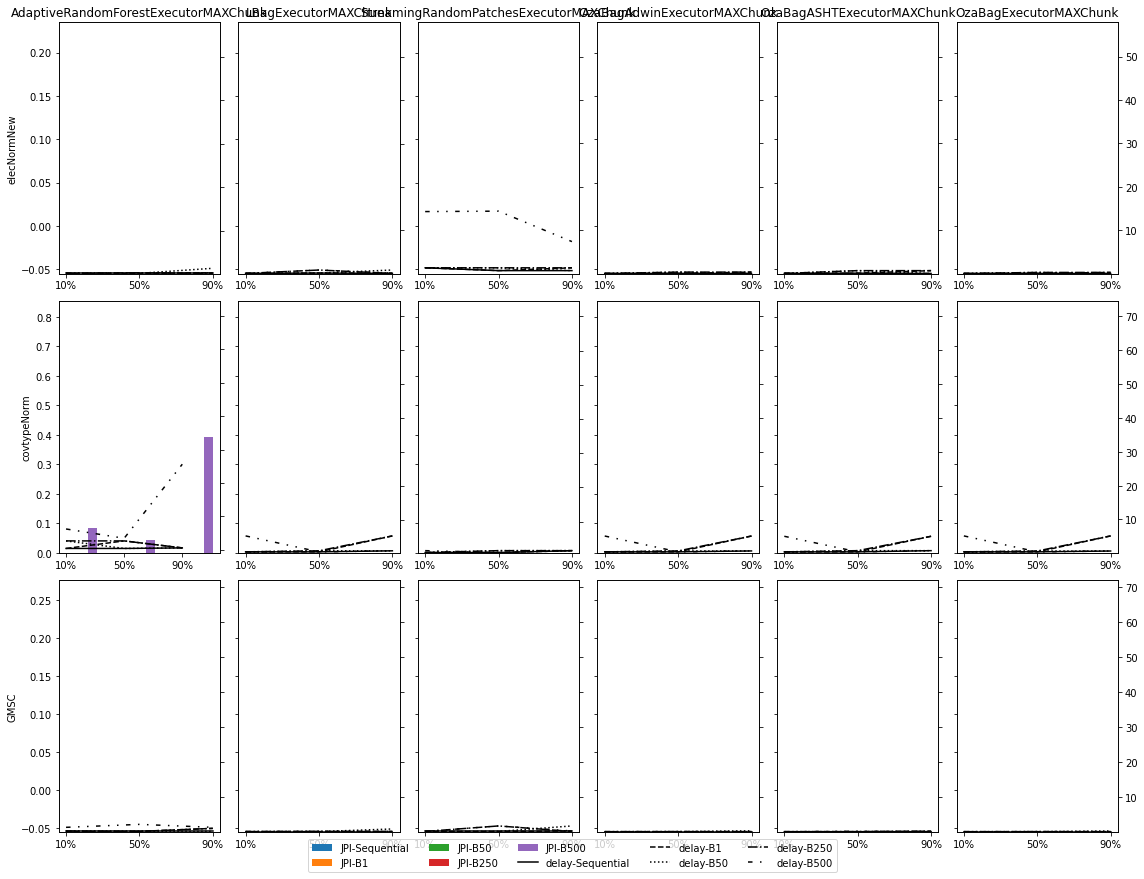

In [180]:
print(freqs)
for f,df in zip(freqs, dataframes):
    print(f'\n\n\n----------------- {f} -----------------')
#     gen_graph(df, bars=True, share_y=False, arch=f.title())
#     gen_graph(df, bars=True, share_y=False, log_y=True, arch=arch.title())
    #print(df)
    gen_graph(df, bars=True, arch=f)

In [169]:
freqs = ['800', '1000', '1200']
dataframes = []
for f in freqs:
    dataframes.append(read_data_create_final_dataframe(f, True))

moaDF: 162    mdf: 162     sshDF: 174
moaDF: 162    mdf: 162     sshDF: 159
moaDF: 162    mdf: 162     sshDF: 233





----------------- 800 -----------------


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,17,15.00,"1,800.00",120.01,"1,797.00",123,...,192.00,124,NaN,0.00,149.73,"17,970.00",NaN,NaN,90,149.92
1,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,500,17,15.01,"1,800.00",119.96,"17,850.00",125,...,"2,257.00",125,NaN,0.00,149.73,"17,970.00",NaN,NaN,90,149.96
2,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,2000,17,15.01,"1,800.00",119.96,"73,957.00",138,...,"9,712.00",126,4.01,914.40,149.73,"17,970.00",480.55,0.03,90,149.97


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,LBagExecutorMAXChunk,elecNormNew,4,50,32,30.00,"3,600.00",120.00,880.00,125,...,107.00,126,NaN,0.00,289.35,"34,742.00",NaN,NaN,90,289.73
1,LBagExecutorMAXChunk,elecNormNew,4,500,32,30.01,"3,600.00",119.97,"9,184.00",125,...,"1,169.00",126,NaN,0.00,289.36,"34,742.00",NaN,NaN,90,289.81
2,LBagExecutorMAXChunk,elecNormNew,4,2000,32,30.01,"3,600.00",119.97,"35,733.00",127,...,"4,641.00",126,4.17,954.30,289.36,"34,742.00",499.54,0.01,90,289.80


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,50,4,19.99,"2,400.00",120.05,"1,359.00",123,...,720.00,124,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,39.98
1,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,500,4,20.01,"2,400.00",119.96,"14,507.00",124,...,"7,534.00",125,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,40.00
2,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,2000,4,20.01,"2,400.00",119.96,"54,293.00",126,...,"29,369.00",127,3.92,901.70,39.94,"4,800.00",470.40,0.10,90,40.00


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,79,74.88,"8,986.00",120.01,329.00,125,...,46.00,68,NaN,0.00,712.35,"45,312.00",NaN,NaN,90,714.00
1,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,500,79,74.88,"8,986.00",120.00,"3,561.00",125,...,498.00,69,NaN,0.00,712.49,"45,312.00",NaN,NaN,90,714.59
2,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,2000,79,74.88,"8,986.00",120.01,"13,850.00",126,...,"1,995.00",68,3.92,485.70,712.45,"45,312.00",248.38,0.01,90,713.39


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,41,40.00,"4,800.00",119.99,637.00,126,...,75.00,126,NaN,0.00,369.09,"44,326.00",NaN,NaN,90,369.63
1,OzaBagASHTExecutorMAXChunk,elecNormNew,4,500,41,40.01,"4,800.00",119.99,"6,412.00",125,...,794.00,125,NaN,0.00,369.10,"44,326.00",NaN,NaN,90,369.68
2,OzaBagASHTExecutorMAXChunk,elecNormNew,4,2000,41,40.01,"4,800.00",119.98,"24,163.00",126,...,"3,243.00",126,3.93,896.90,369.12,"44,326.00",471.65,0.01,90,369.70


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagExecutorMAXChunk,elecNormNew,4,50,95,94.98,"11,381.00",119.82,278.00,126,...,39.00,59,NaN,0.00,855.17,"45,312.00",NaN,NaN,90,857.76
1,OzaBagExecutorMAXChunk,elecNormNew,4,500,95,94.99,"11,381.00",119.82,"2,801.00",126,...,422.00,58,3.90,413.00,855.02,"45,312.00",205.76,0.00,90,858.04
2,OzaBagExecutorMAXChunk,elecNormNew,4,2000,95,94.84,"11,382.00",120.01,"11,380.00",125,...,"1,664.00",58,4.02,425.80,855.28,"45,312.00",212.06,0.00,90,850.37


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,50,11,10.00,"1,200.00",120.04,"2,649.00",123,...,318.00,124,NaN,0.00,NaN,NaN,NaN,NaN,90,99.99
1,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,500,11,10.00,"1,200.00",119.94,"25,518.00",125,...,"3,435.00",124,4.24,954.60,99.83,"11,980.00",508.33,0.04,90,99.99
2,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,2000,11,10.00,"1,200.00",119.94,"75,237.00",140,...,"15,358.00",126,3.97,909.40,99.84,"12,000.00",476.55,0.04,90,93.03


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,LBagExecutorMAXChunk,covtypeNorm,4,50,7,5.00,600.00,120.01,"5,174.00",125,...,540.00,126,NaN,0.00,64.90,"7,800.00",NaN,NaN,90,64.90
1,LBagExecutorMAXChunk,covtypeNorm,4,500,7,5.00,600.00,119.94,"46,264.00",126,...,"5,311.00",126,4.23,968.00,64.90,"7,800.00",507.23,0.07,90,65.00
2,LBagExecutorMAXChunk,covtypeNorm,4,2000,7,5.00,600.00,119.94,"64,547.00",130,...,"21,406.00",132,4.15,996.90,64.90,"7,800.00",498.44,0.06,90,65.00


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,4,19.97,"2,400.00",120.21,"1,509.00",124,...,842.00,125,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,39.89
1,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,500,4,20.01,"2,400.00",119.95,"16,107.00",126,...,"8,803.00",126,4.18,956.70,39.94,"4,800.00",501.24,0.10,90,40.01
2,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,2000,4,NaN,NaN,NaN,NaN,4366,...,"34,331.00",127,3.86,888.90,39.94,"4,800.00",463.67,0.10,90,40.01


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,6,5.00,600.00,120.07,"5,173.00",125,...,573.00,126,NaN,0.00,54.92,"6,600.00",NaN,NaN,90,54.94
1,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,500,6,5.00,600.00,119.94,"45,632.00",126,...,"6,115.00",126,4.11,903.30,54.92,"6,600.00",492.82,0.08,90,54.15
2,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,2000,6,5.00,600.00,119.94,"63,627.00",128,...,"22,939.00",127,3.87,890.20,54.92,"6,600.00",464.39,0.07,90,55.01


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,6,5.00,600.00,120.04,"5,226.00",125,...,590.00,125,3.69,722.30,54.91,"6,600.00",442.84,0.07,90,54.92
1,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,500,6,5.00,600.00,119.93,"46,326.00",126,...,"5,577.00",126,4.14,948.20,54.92,"6,600.00",496.85,0.08,90,55.00
2,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,2000,6,5.00,600.00,119.94,"64,454.00",129,...,"20,981.00",127,3.96,911.00,54.92,"6,600.00",475.26,0.07,90,55.01


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagExecutorMAXChunk,covtypeNorm,4,50,10,10.00,"1,200.00",120.03,"2,571.00",126,...,374.00,125,3.86,875.60,89.85,"10,800.00",462.91,0.04,90,89.85
1,OzaBagExecutorMAXChunk,covtypeNorm,4,500,10,10.01,"1,200.00",119.94,"24,036.00",125,...,"3,746.00",126,4.14,942.80,89.85,"10,782.00",495.44,0.05,90,89.99
2,OzaBagExecutorMAXChunk,covtypeNorm,4,2000,10,10.00,"1,200.00",119.94,"63,808.00",129,...,"15,768.00",128,3.94,917.50,89.85,"10,800.00",472.57,0.04,90,89.85


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,50,288,284.78,"34,143.00",119.89,109.00,126,...,184.00,125,NaN,0.00,159.73,"19,168.00",NaN,NaN,90,159.94
1,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,50,288,284.78,"34,143.00",119.89,109.00,126,...,184.00,125,NaN,0.00,159.73,"19,168.00",NaN,NaN,90,159.94
2,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,500,160,159.98,"19,168.00",119.82,"1,970.00",125,...,"9,074.00",125,3.80,863.40,29.96,"3,600.00",456.31,0.13,90,30.01
3,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,2000,160,159.98,"19,168.00",119.82,"7,854.00",124,...,"35,757.00",125,4.08,913.10,29.96,"3,600.00",489.03,0.14,90,30.01


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,LBagExecutorMAXChunk,GMSC,4,50,378,374.62,"44,925.00",119.92,61.00,128,...,139.00,128,NaN,0.00,209.61,"25,158.00",NaN,NaN,90,209.89
1,LBagExecutorMAXChunk,GMSC,4,50,378,374.62,"44,925.00",119.92,61.00,128,...,652.00,128,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,39.99
2,LBagExecutorMAXChunk,GMSC,4,50,378,374.62,"44,925.00",119.92,61.00,128,...,139.00,128,NaN,0.00,209.61,"25,158.00",NaN,NaN,90,209.89
3,LBagExecutorMAXChunk,GMSC,4,50,378,374.62,"44,925.00",119.92,61.00,128,...,652.00,128,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,39.99
4,LBagExecutorMAXChunk,GMSC,4,50,42,39.99,"4,800.00",120.02,652.00,128,...,139.00,128,NaN,0.00,209.61,"25,158.00",NaN,NaN,90,209.89
5,LBagExecutorMAXChunk,GMSC,4,50,42,39.99,"4,800.00",120.02,652.00,128,...,652.00,128,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,39.99
6,LBagExecutorMAXChunk,GMSC,4,50,42,39.99,"4,800.00",120.02,652.00,128,...,139.00,128,NaN,0.00,209.61,"25,158.00",NaN,NaN,90,209.89
7,LBagExecutorMAXChunk,GMSC,4,50,42,39.99,"4,800.00",120.02,652.00,128,...,652.00,128,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,39.99
8,LBagExecutorMAXChunk,GMSC,4,500,210,209.95,"25,158.00",119.83,"1,483.00",126,...,"6,643.00",126,3.81,834.90,39.94,"4,800.00",457.41,0.10,90,40.01
9,LBagExecutorMAXChunk,GMSC,4,2000,210,209.95,"25,158.00",119.83,"5,972.00",125,...,"25,676.00",126,4.15,950.10,39.94,"4,800.00",497.76,0.10,90,40.01


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,90,89.86,"10,783.00",120.00,333.00,125,...,200.00,125,NaN,0.00,159.73,"19,168.00",NaN,NaN,90,159.92
1,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,90,89.86,"10,783.00",120.00,333.00,125,...,"1,776.00",125,NaN,0.00,14.98,"1,800.00",NaN,NaN,90,15.00
2,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,90,89.86,"10,783.00",120.00,333.00,125,...,200.00,125,NaN,0.00,159.73,"19,168.00",NaN,NaN,90,159.92
3,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,90,89.86,"10,783.00",120.00,333.00,125,...,"1,776.00",125,NaN,0.00,14.98,"1,800.00",NaN,NaN,90,15.00
4,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,500,18,15.01,"1,800.00",119.95,"17,999.00",124,...,"2,128.00",125,3.76,850.30,159.73,"19,168.00",450.79,0.02,90,159.98
5,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,2000,18,15.01,"1,800.00",119.96,"69,962.00",134,...,"8,725.00",125,3.95,897.70,159.73,"19,200.00",474.60,0.02,90,159.73


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,968,962.75,"115,414.00",119.88,33.00,128,...,54.00,128,NaN,0.00,533.72,"64,093.00",NaN,NaN,90,534.35
1,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,968,962.75,"115,414.00",119.88,33.00,128,...,251.00,128,NaN,0.00,104.83,"12,600.00",NaN,NaN,90,104.83
2,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,968,962.75,"115,414.00",119.88,33.00,128,...,54.00,128,NaN,0.00,533.72,"64,093.00",NaN,NaN,90,534.35
3,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,968,962.75,"115,414.00",119.88,33.00,128,...,251.00,128,NaN,0.00,104.83,"12,600.00",NaN,NaN,90,104.83
4,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,107,104.83,"12,580.00",120.00,251.00,128,...,54.00,128,NaN,0.00,533.72,"64,093.00",NaN,NaN,90,534.35
5,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,107,104.83,"12,580.00",120.00,251.00,128,...,251.00,128,NaN,0.00,104.83,"12,600.00",NaN,NaN,90,104.83
6,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,107,104.83,"12,580.00",120.00,251.00,128,...,54.00,128,NaN,0.00,533.72,"64,093.00",NaN,NaN,90,534.35
7,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,107,104.83,"12,580.00",120.00,251.00,128,...,251.00,128,NaN,0.00,104.83,"12,600.00",NaN,NaN,90,104.83
8,OzaBagAdwinExecutorMAXChunk,GMSC,4,500,537,533.19,"64,000.00",120.03,572.00,125,...,"2,546.00",126,3.82,875.70,104.83,"12,600.00",458.90,0.04,90,104.83
9,OzaBagAdwinExecutorMAXChunk,GMSC,4,2000,537,532.19,"64,000.00",120.26,"2,331.00",125,...,"10,085.00",126,4.10,934.80,104.83,"12,600.00",492.01,0.04,90,104.83


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1530,"1,525.29","150,000.00",98.34,22.00,106,...,31.00,128,NaN,0.00,847.17,"101,830.00",NaN,NaN,90,847.14
1,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1530,"1,525.29","150,000.00",98.34,22.00,106,...,153.00,128,NaN,0.00,169.71,"20,366.00",NaN,NaN,90,169.97
2,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1530,"1,525.29","150,000.00",98.34,22.00,106,...,31.00,128,NaN,0.00,847.17,"101,830.00",NaN,NaN,90,847.14
3,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1530,"1,525.29","150,000.00",98.34,22.00,106,...,153.00,128,NaN,0.00,169.71,"20,366.00",NaN,NaN,90,169.97
4,OzaBagASHTExecutorMAXChunk,GMSC,4,50,170,169.97,"20,366.00",119.82,153.00,128,...,31.00,128,NaN,0.00,847.17,"101,830.00",NaN,NaN,90,847.14
5,OzaBagASHTExecutorMAXChunk,GMSC,4,50,170,169.97,"20,366.00",119.82,153.00,128,...,153.00,128,NaN,0.00,169.71,"20,366.00",NaN,NaN,90,169.97
6,OzaBagASHTExecutorMAXChunk,GMSC,4,50,170,169.97,"20,366.00",119.82,153.00,128,...,31.00,128,NaN,0.00,847.17,"101,830.00",NaN,NaN,90,847.14
7,OzaBagASHTExecutorMAXChunk,GMSC,4,50,170,169.97,"20,366.00",119.82,153.00,128,...,153.00,128,NaN,0.00,169.71,"20,366.00",NaN,NaN,90,169.97
8,OzaBagASHTExecutorMAXChunk,GMSC,4,500,850,848.17,"101,781.00",120.00,365.00,126,...,"1,590.00",126,3.76,496.20,169.70,"20,366.00",450.42,0.02,90,169.97
9,OzaBagASHTExecutorMAXChunk,GMSC,4,2000,850,848.70,"101,830.00",119.98,"1,532.00",126,...,"6,441.00",125,3.99,901.80,169.71,"20,366.00",478.07,0.02,90,169.99


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagExecutorMAXChunk,GMSC,4,50,977,972.84,"116,610.00",119.86,30.00,126,...,52.00,4917,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,539.38
1,OzaBagExecutorMAXChunk,GMSC,4,50,977,972.84,"116,610.00",119.86,30.00,126,...,248.00,128,NaN,0.00,104.83,"12,600.00",NaN,NaN,90,104.83
2,OzaBagExecutorMAXChunk,GMSC,4,50,108,104.83,"12,580.00",120.00,248.00,128,...,52.00,4917,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,539.38
3,OzaBagExecutorMAXChunk,GMSC,4,50,108,104.83,"12,580.00",120.00,248.00,128,...,248.00,128,NaN,0.00,104.83,"12,600.00",NaN,NaN,90,104.83
4,OzaBagExecutorMAXChunk,GMSC,4,500,977,972.42,"116,610.00",119.92,330.00,125,...,544.00,126,NaN,0.00,538.61,"64,692.00",NaN,NaN,90,539.46
5,OzaBagExecutorMAXChunk,GMSC,4,2000,977,973.19,"116,610.00",119.82,"1,368.00",126,...,"2,210.00",126,4.17,954.00,538.68,"64,692.00",499.53,0.01,90,539.51


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


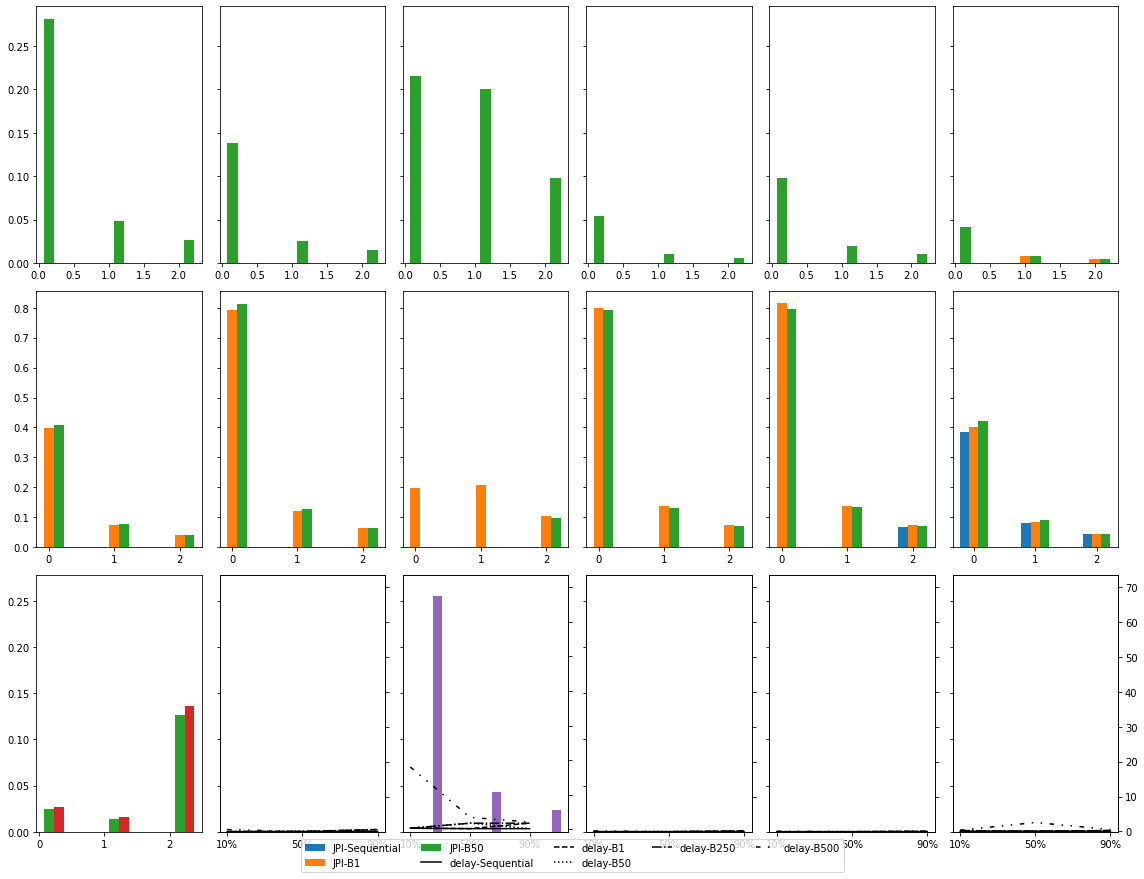




----------------- 1000 -----------------


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,19,15.00,"1,800.00",120.01,"1,786.00",123,...,179.00,124,NaN,0.00,174.67,"20,965.00",NaN,NaN,90,174.88
1,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,500,19,15.01,"1,800.00",119.96,"18,269.00",124,...,"2,018.00",125,NaN,0.00,174.67,"20,965.00",NaN,NaN,90,174.94
2,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,2000,19,15.01,"1,800.00",119.95,"76,649.00",141,...,"8,056.00",125,3.99,872.90,174.67,"20,965.00",477.65,0.02,90,174.70


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,LBagExecutorMAXChunk,elecNormNew,4,50,31,30.00,"3,600.00",120.00,876.00,126,...,109.00,126,NaN,0.00,284.36,"34,143.00",NaN,NaN,90,284.71
1,LBagExecutorMAXChunk,elecNormNew,4,500,31,30.01,"3,600.00",119.97,"9,158.00",126,...,"1,192.00",125,NaN,0.00,284.36,"34,143.00",NaN,NaN,90,284.81
2,LBagExecutorMAXChunk,elecNormNew,4,2000,31,30.01,"3,600.00",119.97,"35,801.00",127,...,"4,753.00",127,4.23,972.40,284.39,"34,143.00",506.79,0.01,90,282.54


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,50,4,19.99,"2,400.00",120.09,"1,382.00",125,...,734.00,124,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,39.97
1,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,500,4,20.01,"2,400.00",119.96,"14,320.00",125,...,"7,425.00",124,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,40.00
2,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,2000,4,20.01,"2,400.00",119.96,"54,993.00",126,...,"29,240.00",126,3.88,885.70,39.94,"4,800.00",466.10,0.10,90,40.01


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,79,74.88,"8,986.00",120.01,330.00,125,...,48.00,69,NaN,0.00,712.52,"45,312.00",NaN,NaN,90,714.09
1,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,500,79,74.88,"8,986.00",120.00,"3,567.00",126,...,493.00,68,NaN,0.00,712.51,"45,312.00",NaN,NaN,90,714.62
2,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,2000,79,74.88,"8,986.00",120.00,"13,821.00",126,...,"1,993.00",68,3.97,491.70,712.50,"45,312.00",251.43,0.01,90,708.93


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,41,40.00,"4,800.00",120.00,632.00,125,...,50.00,125,NaN,0.00,374.07,"44,925.00",NaN,NaN,90,374.62
1,OzaBagASHTExecutorMAXChunk,elecNormNew,4,500,41,40.01,"4,800.00",119.99,"6,411.00",126,...,775.00,126,NaN,0.00,374.08,"44,925.00",NaN,NaN,90,374.67
2,OzaBagASHTExecutorMAXChunk,elecNormNew,4,2000,41,40.01,"4,800.00",119.98,"24,383.00",126,...,"3,193.00",125,3.88,879.90,374.11,"44,925.00",464.75,0.01,90,374.69


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagExecutorMAXChunk,elecNormNew,4,50,92,89.99,"10,782.00",119.82,286.00,126,...,40.00,60,NaN,0.00,830.06,"45,312.00",NaN,NaN,90,832.73
1,OzaBagExecutorMAXChunk,elecNormNew,4,500,92,89.99,"10,782.00",119.81,"2,947.00",126,...,389.00,60,3.95,434.70,829.91,"45,312.00",215.02,0.00,90,832.77
2,OzaBagExecutorMAXChunk,elecNormNew,4,2000,92,89.99,"10,782.00",119.81,"11,682.00",126,...,"1,655.00",59,3.86,416.80,830.21,"45,312.00",209.92,0.00,90,824.21


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,50,12,10.00,"1,200.00",120.04,"2,627.00",124,...,316.00,124,NaN,0.00,109.81,"13,178.00",NaN,NaN,90,109.98
1,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,500,12,10.00,"1,200.00",119.94,"26,232.00",125,...,"3,213.00",125,4.13,937.30,109.81,"13,178.00",494.73,0.04,90,109.99
2,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,2000,12,10.00,"1,200.00",119.94,"71,651.00",136,...,"13,173.00",126,4.00,911.00,109.81,"13,178.00",478.74,0.04,90,109.99


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,LBagExecutorMAXChunk,covtypeNorm,4,50,7,5.00,600.00,120.01,"5,183.00",126,...,545.00,126,NaN,0.00,64.90,"7,800.00",NaN,NaN,90,64.92
1,LBagExecutorMAXChunk,covtypeNorm,4,500,7,5.00,600.00,119.94,"47,589.00",126,...,"5,279.00",127,4.05,932.30,64.90,"7,800.00",486.42,0.06,90,65.00
2,LBagExecutorMAXChunk,covtypeNorm,4,2000,7,5.00,600.00,119.94,"65,191.00",130,...,"22,060.00",132,3.96,946.10,64.90,"7,800.00",475.02,0.06,90,65.00


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,4,19.97,"2,400.00",120.20,"1,519.00",125,...,872.00,125,NaN,0.00,39.95,"4,800.00",NaN,NaN,90,39.93
1,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,500,4,20.01,"2,400.00",119.95,"16,125.00",126,...,"8,792.00",125,4.01,909.70,39.94,"4,800.00",480.81,0.10,90,40.01
2,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,2000,4,NaN,NaN,NaN,NaN,618,...,"34,001.00",128,4.18,969.30,39.95,"4,800.00",501.25,0.10,90,40.01


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,6,5.00,600.00,120.06,"5,235.00",125,...,571.00,126,NaN,0.00,54.91,"6,600.00",NaN,NaN,90,54.94
1,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,500,6,5.00,600.00,119.94,"46,542.00",126,...,"6,160.00",125,4.07,923.60,54.92,"6,600.00",488.45,0.08,90,54.14
2,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,2000,6,5.00,600.00,119.94,"63,390.00",128,...,"21,764.00",127,4.40,"1,011.80",54.92,"6,600.00",527.86,0.08,90,55.00


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,6,5.00,600.00,120.04,"5,143.00",125,...,547.00,125,NaN,0.00,59.91,"7,200.00",NaN,NaN,90,59.91
1,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,500,6,5.00,600.00,119.94,"45,524.00",126,...,"5,138.00",125,4.04,916.20,59.91,"7,200.00",484.33,0.07,90,60.00
2,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,2000,6,5.00,600.00,119.94,"63,144.00",128,...,"19,913.00",128,4.28,992.90,59.91,"7,200.00",513.57,0.07,90,60.00


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagExecutorMAXChunk,covtypeNorm,4,50,9,5.00,600.00,120.02,"5,121.00",125,...,430.00,125,NaN,0.00,84.86,"10,183.00",NaN,NaN,90,84.99
1,OzaBagExecutorMAXChunk,covtypeNorm,4,500,9,5.00,600.00,119.93,"45,555.00",126,...,"4,223.00",125,4.17,924.90,84.86,"10,200.00",499.95,0.05,90,84.87
2,OzaBagExecutorMAXChunk,covtypeNorm,4,2000,9,5.00,600.00,119.93,"63,174.00",129,...,"16,186.00",127,4.10,942.80,84.86,"10,200.00",503.58,0.05,90,81.40


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,50,32,30.00,"3,600.00",120.00,870.00,140,...,105.00,124,NaN,0.00,289.37,"34,742.00",NaN,NaN,90,289.75
1,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,50,32,30.00,"3,600.00",120.00,870.00,140,...,870.00,140,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,30.00
2,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,500,32,30.01,"3,600.00",119.97,"9,074.00",125,...,"1,213.00",124,NaN,0.00,289.39,"34,742.00",NaN,NaN,90,289.84
3,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,2000,32,30.01,"3,600.00",119.97,"35,813.00",126,...,"4,796.00",124,4.10,921.90,289.40,"34,742.00",491.11,0.01,90,289.85


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,LBagExecutorMAXChunk,GMSC,4,50,41,39.99,"4,800.00",120.02,650.00,125,...,86.00,125,NaN,0.00,369.15,"44,326.00",NaN,NaN,90,369.65
1,LBagExecutorMAXChunk,GMSC,4,500,41,40.01,"4,800.00",119.98,"6,721.00",126,...,927.00,126,NaN,0.00,369.15,"44,326.00",NaN,NaN,90,369.73
2,LBagExecutorMAXChunk,GMSC,4,2000,41,40.01,"4,800.00",119.98,"25,312.00",126,...,"3,724.00",126,4.06,930.40,369.17,"44,326.00",487.79,0.01,90,366.48


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,14,10.00,"1,200.00",120.03,"2,598.00",124,...,197.00,123,NaN,0.00,69.89,"8,400.00",NaN,NaN,90,124.98
1,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,500,14,10.00,"1,200.00",119.94,"25,462.00",124,...,"2,580.00",125,NaN,0.00,124.79,"14,975.00",NaN,NaN,90,124.99
2,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,2000,14,10.00,"1,200.00",119.95,"68,421.00",132,...,"10,794.00",125,3.95,896.90,124.79,"15,000.00",474.16,0.03,90,124.79


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,110,109.99,"13,178.00",119.82,235.00,126,...,32.00,125,NaN,0.00,991.30,"119,002.00",NaN,NaN,90,992.51
1,OzaBagAdwinExecutorMAXChunk,GMSC,4,500,110,109.82,"13,179.00",120.01,"2,432.00",125,...,338.00,126,NaN,0.00,991.42,"119,002.00",NaN,NaN,90,992.38
2,OzaBagAdwinExecutorMAXChunk,GMSC,4,2000,110,109.82,"13,179.00",120.01,"9,624.00",125,...,"1,372.00",126,3.91,892.40,991.44,"119,002.00",469.05,0.00,90,993.02


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagASHTExecutorMAXChunk,GMSC,4,50,153,149.97,"17,970.00",119.82,147.00,126,...,24.00,115,NaN,0.00,"1,372.71","150,000.00",NaN,NaN,90,"1,374.55"
1,OzaBagASHTExecutorMAXChunk,GMSC,4,500,153,149.98,"17,970.00",119.81,"1,793.00",125,...,246.00,115,NaN,0.00,"1,372.85","150,000.00",NaN,NaN,90,"1,374.18"
2,OzaBagASHTExecutorMAXChunk,GMSC,4,2000,153,149.97,"17,970.00",119.82,"7,321.00",126,...,"1,039.00",114,3.84,795.30,"1,372.70","150,000.00",420.38,0.00,90,"1,370.91"


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagExecutorMAXChunk,GMSC,4,50,109,104.83,"12,580.00",120.01,248.00,126,...,32.00,126,NaN,0.00,981.39,"117,806.00",NaN,NaN,90,982.62
1,OzaBagExecutorMAXChunk,GMSC,4,500,109,105.00,"12,600.00",120.00,"2,544.00",126,...,330.00,126,3.76,26.30,981.54,"117,806.00",450.24,0.00,90,983.06
2,OzaBagExecutorMAXChunk,GMSC,4,2000,109,105.00,"12,600.00",120.00,"10,054.00",126,...,"1,367.00",125,4.10,926.20,981.56,"117,806.00",491.08,0.00,90,983.13


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


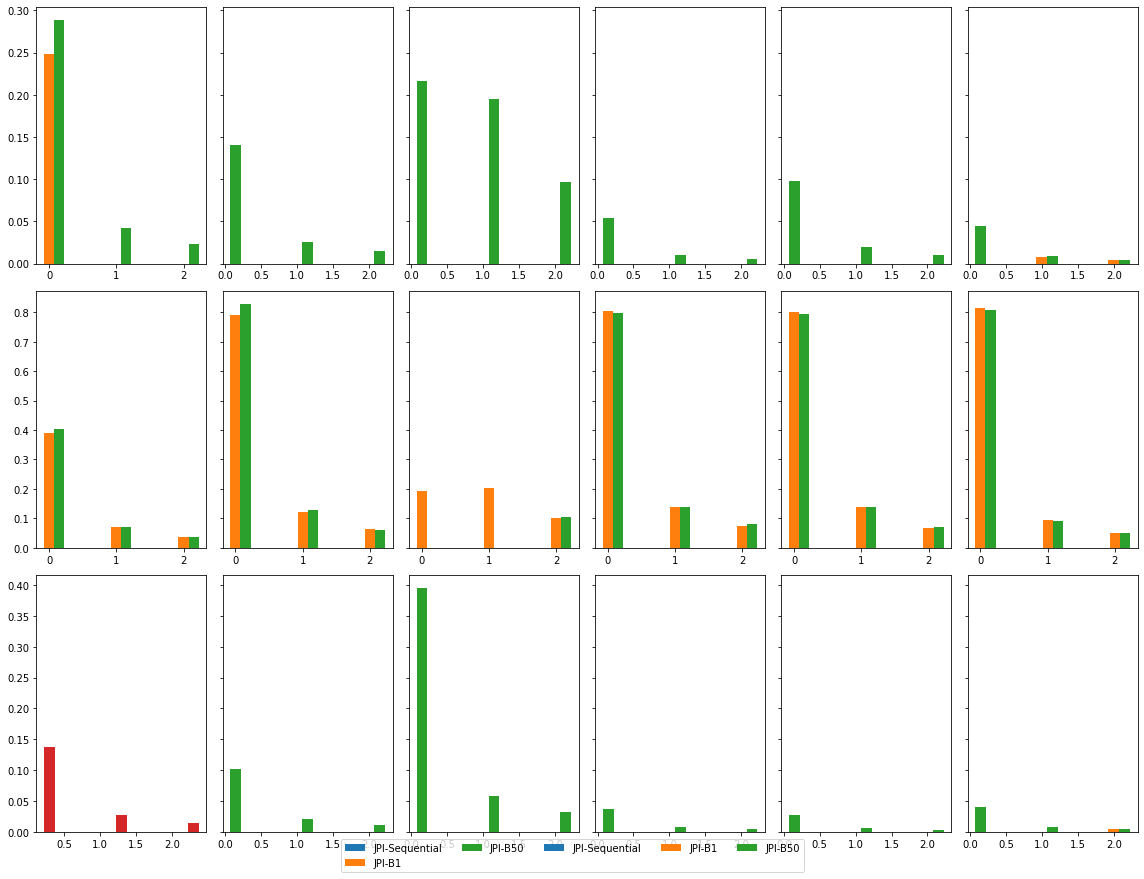




----------------- 1200 -----------------


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,192,189.82,"22,762.00",119.92,171.00,124,...,171.00,124,NaN,0.00,189.63,"22,762.00",NaN,NaN,90,189.82
1,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,192,189.82,"22,762.00",119.92,171.00,124,...,294.00,125,NaN,0.00,104.82,"12,579.00",NaN,NaN,90,104.98
2,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,192,189.82,"22,762.00",119.92,171.00,124,...,"1,331.00",124,NaN,0.00,19.97,"2,400.00",NaN,NaN,90,19.99
3,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,192,189.82,"22,762.00",119.92,171.00,124,...,171.00,124,NaN,0.00,189.63,"22,762.00",NaN,NaN,90,189.82
4,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,192,189.82,"22,762.00",119.92,171.00,124,...,294.00,125,NaN,0.00,104.82,"12,579.00",NaN,NaN,90,104.98
5,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,192,189.82,"22,762.00",119.92,171.00,124,...,"1,331.00",124,NaN,0.00,19.97,"2,400.00",NaN,NaN,90,19.99
6,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,192,189.82,"22,762.00",119.92,171.00,124,...,171.00,124,NaN,0.00,189.63,"22,762.00",NaN,NaN,90,189.82
7,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,192,189.82,"22,762.00",119.92,171.00,124,...,294.00,125,NaN,0.00,104.82,"12,579.00",NaN,NaN,90,104.98
8,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,192,189.82,"22,762.00",119.92,171.00,124,...,"1,331.00",124,NaN,0.00,19.97,"2,400.00",NaN,NaN,90,19.99
9,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,107,104.98,"12,579.00",119.82,294.00,125,...,171.00,124,NaN,0.00,189.63,"22,762.00",NaN,NaN,90,189.82


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,LBagExecutorMAXChunk,elecNormNew,4,50,303,299.76,"35,940.00",119.90,98.00,126,...,98.00,126,NaN,0.00,299.33,"35,940.00",NaN,NaN,90,299.76
1,LBagExecutorMAXChunk,elecNormNew,4,50,303,299.76,"35,940.00",119.90,98.00,126,...,180.00,126,NaN,0.00,164.69,"19,767.00",NaN,NaN,90,164.90
2,LBagExecutorMAXChunk,elecNormNew,4,50,303,299.76,"35,940.00",119.90,98.00,126,...,880.00,9353,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,30.00
3,LBagExecutorMAXChunk,elecNormNew,4,50,303,299.76,"35,940.00",119.90,98.00,126,...,98.00,126,NaN,0.00,299.33,"35,940.00",NaN,NaN,90,299.76
4,LBagExecutorMAXChunk,elecNormNew,4,50,303,299.76,"35,940.00",119.90,98.00,126,...,180.00,126,NaN,0.00,164.69,"19,767.00",NaN,NaN,90,164.90
5,LBagExecutorMAXChunk,elecNormNew,4,50,303,299.76,"35,940.00",119.90,98.00,126,...,880.00,9353,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,30.00
6,LBagExecutorMAXChunk,elecNormNew,4,50,168,164.90,"19,767.00",119.87,180.00,126,...,98.00,126,NaN,0.00,299.33,"35,940.00",NaN,NaN,90,299.76
7,LBagExecutorMAXChunk,elecNormNew,4,50,168,164.90,"19,767.00",119.87,180.00,126,...,180.00,126,NaN,0.00,164.69,"19,767.00",NaN,NaN,90,164.90
8,LBagExecutorMAXChunk,elecNormNew,4,50,168,164.90,"19,767.00",119.87,180.00,126,...,880.00,9353,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,30.00
9,LBagExecutorMAXChunk,elecNormNew,4,50,168,164.90,"19,767.00",119.87,180.00,126,...,98.00,126,NaN,0.00,299.33,"35,940.00",NaN,NaN,90,299.76


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,50,23,19.99,"2,400.00",120.04,"1,365.00",124,...,715.00,123,NaN,0.00,19.97,"2,400.00",NaN,NaN,90,39.98
1,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,50,23,19.99,"2,400.00",120.04,"1,365.00",124,...,"1,360.00",123,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.99
2,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,50,23,19.99,"2,400.00",120.04,"1,365.00",124,...,715.00,123,NaN,0.00,19.97,"2,400.00",NaN,NaN,90,39.98
3,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,50,23,19.99,"2,400.00",120.04,"1,365.00",124,...,"1,360.00",123,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.99
4,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,500,4,20.01,"2,400.00",119.96,"14,311.00",125,...,"7,397.00",124,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,40.01
5,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,2000,4,20.01,"2,400.00",119.96,"55,137.00",125,...,"29,458.00",125,3.92,857.80,39.94,"4,800.00",469.96,0.10,90,40.01


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,668,663.87,"45,312.00",68.25,49.00,73,...,49.00,73,NaN,0.00,662.40,"45,312.00",NaN,NaN,90,663.87
1,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,668,663.87,"45,312.00",68.25,49.00,73,...,371.00,126,NaN,0.00,69.89,"8,400.00",NaN,NaN,90,69.89
2,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,668,663.87,"45,312.00",68.25,49.00,73,...,49.00,73,NaN,0.00,662.40,"45,312.00",NaN,NaN,90,663.87
3,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,668,663.87,"45,312.00",68.25,49.00,73,...,371.00,126,NaN,0.00,69.89,"8,400.00",NaN,NaN,90,69.89
4,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,371,369.65,"44,326.00",119.92,78.00,126,...,49.00,73,NaN,0.00,662.40,"45,312.00",NaN,NaN,90,663.87
5,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,371,369.65,"44,326.00",119.92,78.00,126,...,371.00,126,NaN,0.00,69.89,"8,400.00",NaN,NaN,90,69.89
6,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,371,369.65,"44,326.00",119.92,78.00,126,...,49.00,73,NaN,0.00,662.40,"45,312.00",NaN,NaN,90,663.87
7,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,371,369.65,"44,326.00",119.92,78.00,126,...,371.00,126,NaN,0.00,69.89,"8,400.00",NaN,NaN,90,69.89
8,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,500,668,664.21,"45,312.00",68.22,508.00,73,...,824.00,126,NaN,0.00,369.08,"44,326.00",NaN,NaN,90,369.66
9,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,2000,668,641.99,"44,088.00",68.67,"2,126.00",73,...,"3,342.00",126,3.93,896.20,369.08,"44,326.00",471.31,0.01,90,369.67


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,320,319.77,"38,336.00",119.89,85.00,126,...,85.00,126,NaN,0.00,319.28,"38,336.00",NaN,NaN,90,319.77
1,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,320,319.77,"38,336.00",119.89,85.00,126,...,733.00,126,NaN,0.00,34.95,"4,200.00",NaN,NaN,90,35.00
2,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,320,319.77,"38,336.00",119.89,85.00,126,...,85.00,126,NaN,0.00,319.28,"38,336.00",NaN,NaN,90,319.77
3,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,320,319.77,"38,336.00",119.89,85.00,126,...,733.00,126,NaN,0.00,34.95,"4,200.00",NaN,NaN,90,35.00
4,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,178,174.93,"20,965.00",119.85,142.00,125,...,85.00,126,NaN,0.00,319.28,"38,336.00",NaN,NaN,90,319.77
5,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,178,174.93,"20,965.00",119.85,142.00,125,...,733.00,126,NaN,0.00,34.95,"4,200.00",NaN,NaN,90,35.00
6,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,178,174.93,"20,965.00",119.85,142.00,125,...,85.00,126,NaN,0.00,319.28,"38,336.00",NaN,NaN,90,319.77
7,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,178,174.93,"20,965.00",119.85,142.00,125,...,733.00,126,NaN,0.00,34.95,"4,200.00",NaN,NaN,90,35.00
8,OzaBagASHTExecutorMAXChunk,elecNormNew,4,500,320,319.75,"38,336.00",119.89,904.00,126,...,"1,567.00",125,NaN,0.00,174.67,"20,965.00",NaN,NaN,90,174.95
9,OzaBagASHTExecutorMAXChunk,elecNormNew,4,2000,320,319.77,"38,336.00",119.89,"3,642.00",125,...,"6,265.00",126,3.84,875.40,174.67,"20,965.00",460.10,0.02,90,174.95


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagExecutorMAXChunk,elecNormNew,4,50,852,848.11,"45,312.00",53.43,35.00,59,...,35.00,59,NaN,0.00,845.42,"45,312.00",NaN,NaN,90,848.11
1,OzaBagExecutorMAXChunk,elecNormNew,4,50,852,848.11,"45,312.00",53.43,35.00,59,...,287.00,125,NaN,0.00,89.84,"10,782.00",NaN,NaN,90,89.99
2,OzaBagExecutorMAXChunk,elecNormNew,4,50,852,848.11,"45,312.00",53.43,35.00,59,...,35.00,59,NaN,0.00,845.42,"45,312.00",NaN,NaN,90,848.11
3,OzaBagExecutorMAXChunk,elecNormNew,4,50,852,848.11,"45,312.00",53.43,35.00,59,...,287.00,125,NaN,0.00,89.84,"10,782.00",NaN,NaN,90,89.99
4,OzaBagExecutorMAXChunk,elecNormNew,4,50,473,468.73,"45,312.00",96.67,61.00,102,...,35.00,59,NaN,0.00,845.42,"45,312.00",NaN,NaN,90,848.11
5,OzaBagExecutorMAXChunk,elecNormNew,4,50,473,468.73,"45,312.00",96.67,61.00,102,...,287.00,125,NaN,0.00,89.84,"10,782.00",NaN,NaN,90,89.99
6,OzaBagExecutorMAXChunk,elecNormNew,4,50,473,468.73,"45,312.00",96.67,61.00,102,...,35.00,59,NaN,0.00,845.42,"45,312.00",NaN,NaN,90,848.11
7,OzaBagExecutorMAXChunk,elecNormNew,4,50,473,468.73,"45,312.00",96.67,61.00,102,...,287.00,125,NaN,0.00,89.84,"10,782.00",NaN,NaN,90,89.99
8,OzaBagExecutorMAXChunk,elecNormNew,4,500,852,848.51,"45,312.00",53.40,410.00,59,...,652.00,102,3.74,78.60,467.83,"45,312.00",361.80,0.01,90,468.76
9,OzaBagExecutorMAXChunk,elecNormNew,4,2000,852,832.15,"44,437.00",53.40,"1,721.00",58,...,"2,615.00",103,3.98,745.00,467.79,"45,312.00",385.15,0.01,90,468.71


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,50,96,94.84,"11,382.00",120.01,371.00,124,...,531.00,125,NaN,0.00,49.93,"6,000.00",NaN,NaN,90,49.95
1,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,50,96,94.84,"11,382.00",120.01,371.00,124,...,531.00,125,NaN,0.00,49.93,"6,000.00",NaN,NaN,90,49.95
2,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,50,10,9.99,"1,200.00",120.07,"2,630.00",123,...,531.00,125,NaN,0.00,49.93,"6,000.00",NaN,NaN,90,49.95
3,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,50,10,9.99,"1,200.00",120.07,"2,630.00",123,...,531.00,125,NaN,0.00,49.93,"6,000.00",NaN,NaN,90,49.95
4,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,500,53,49.63,"6,000.00",120.90,"6,205.00",125,...,"25,606.00",125,3.91,883.50,9.99,"1,200.00",468.88,0.39,90,10.01
5,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,2000,53,48.83,"6,000.00",122.89,"26,106.00",127,...,"70,864.00",135,4.02,982.00,9.99,"1,200.00",482.74,0.40,90,10.00


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,LBagExecutorMAXChunk,covtypeNorm,4,50,63,59.88,"7,200.00",120.24,559.00,125,...,867.00,126,NaN,0.00,34.95,"4,200.00",NaN,NaN,90,34.96
1,LBagExecutorMAXChunk,covtypeNorm,4,50,63,59.88,"7,200.00",120.24,559.00,125,...,"5,261.00",125,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
2,LBagExecutorMAXChunk,covtypeNorm,4,50,63,59.88,"7,200.00",120.24,559.00,125,...,867.00,126,NaN,0.00,34.95,"4,200.00",NaN,NaN,90,34.96
3,LBagExecutorMAXChunk,covtypeNorm,4,50,63,59.88,"7,200.00",120.24,559.00,125,...,"5,261.00",125,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
4,LBagExecutorMAXChunk,covtypeNorm,4,50,7,5.00,600.00,120.06,"5,261.00",125,...,867.00,126,NaN,0.00,34.95,"4,200.00",NaN,NaN,90,34.96
5,LBagExecutorMAXChunk,covtypeNorm,4,50,7,5.00,600.00,120.06,"5,261.00",125,...,"5,261.00",125,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
6,LBagExecutorMAXChunk,covtypeNorm,4,50,7,5.00,600.00,120.06,"5,261.00",125,...,867.00,126,NaN,0.00,34.95,"4,200.00",NaN,NaN,90,34.96
7,LBagExecutorMAXChunk,covtypeNorm,4,50,7,5.00,600.00,120.06,"5,261.00",125,...,"5,261.00",125,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
8,LBagExecutorMAXChunk,covtypeNorm,4,500,35,35.01,"4,200.00",119.97,"8,600.00",126,...,"46,334.00",125,3.89,880.20,4.99,600.00,467.12,0.78,90,5.00
9,LBagExecutorMAXChunk,covtypeNorm,4,2000,35,33.14,"4,000.00",120.69,"36,422.00",126,...,"63,891.00",129,4.06,950.50,4.99,600.00,487.16,0.81,90,5.00


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,37,34.95,"4,200.00",120.16,940.00,124,...,"1,499.00",125,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.98
1,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,37,34.95,"4,200.00",120.16,940.00,124,...,"1,497.00",125,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.97
2,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,37,34.95,"4,200.00",120.16,940.00,124,...,"1,499.00",125,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.98
3,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,37,34.95,"4,200.00",120.16,940.00,124,...,"1,497.00",125,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.97
4,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,4,19.97,"2,400.00",120.17,"1,497.00",125,...,"1,499.00",125,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.98
5,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,4,19.97,"2,400.00",120.17,"1,497.00",125,...,"1,497.00",125,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.97
6,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,4,19.97,"2,400.00",120.17,"1,497.00",125,...,"1,499.00",125,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.98
7,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,4,19.97,"2,400.00",120.17,"1,497.00",125,...,"1,497.00",125,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.97
8,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,500,20,20.01,"2,400.00",119.96,"15,730.00",126,...,"15,843.00",126,3.92,893.70,19.98,"2,400.00",470.18,0.20,90,20.01
9,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,2000,20,NaN,NaN,NaN,NaN,1234,...,NaN,22558,3.89,"157,269.00",19.98,"2,400.00",NaN,NaN,90,NaN


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,72,69.94,"8,400.00",120.11,502.00,125,...,775.00,126,NaN,0.00,39.95,"4,800.00",NaN,NaN,90,39.95
1,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,72,69.94,"8,400.00",120.11,502.00,125,...,"5,178.00",125,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
2,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,72,69.94,"8,400.00",120.11,502.00,125,...,775.00,126,NaN,0.00,39.95,"4,800.00",NaN,NaN,90,39.95
3,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,72,69.94,"8,400.00",120.11,502.00,125,...,"5,178.00",125,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
4,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,8,5.00,600.00,120.07,"5,178.00",125,...,775.00,126,NaN,0.00,39.95,"4,800.00",NaN,NaN,90,39.95
5,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,8,5.00,600.00,120.07,"5,178.00",125,...,"5,178.00",125,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
6,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,8,5.00,600.00,120.07,"5,178.00",125,...,775.00,126,NaN,0.00,39.95,"4,800.00",NaN,NaN,90,39.95
7,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,8,5.00,600.00,120.07,"5,178.00",125,...,"5,178.00",125,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
8,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,500,40,40.01,"4,800.00",119.98,"7,628.00",126,...,"45,779.00",126,4.00,913.10,4.99,600.00,480.31,0.80,90,5.00
9,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,2000,40,40.01,"4,800.00",119.98,"26,766.00",128,...,"63,524.00",129,3.72,871.40,4.99,600.00,446.64,0.74,90,5.00


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,60,59.92,"7,200.00",120.17,549.00,126,...,908.00,125,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,29.98
1,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,60,59.92,"7,200.00",120.17,549.00,126,...,"5,146.00",126,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
2,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,60,59.92,"7,200.00",120.17,549.00,126,...,908.00,125,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,29.98
3,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,60,59.92,"7,200.00",120.17,549.00,126,...,"5,146.00",126,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
4,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,6,5.00,600.00,120.04,"5,146.00",126,...,908.00,125,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,29.98
5,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,6,5.00,600.00,120.04,"5,146.00",126,...,"5,146.00",126,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
6,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,6,5.00,600.00,120.04,"5,146.00",126,...,908.00,125,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,29.98
7,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,6,5.00,600.00,120.04,"5,146.00",126,...,"5,146.00",126,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
8,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,500,33,30.01,"3,600.00",119.96,"9,301.00",125,...,"45,521.00",126,4.04,920.50,4.99,600.00,484.21,0.81,90,5.00
9,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,2000,33,30.01,"3,600.00",119.96,"34,419.00",129,...,"63,103.00",129,3.72,871.50,4.99,600.00,446.70,0.74,90,5.00


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagExecutorMAXChunk,covtypeNorm,4,50,81,79.99,"9,584.00",119.82,440.00,126,...,688.00,125,NaN,0.00,44.94,"5,400.00",NaN,NaN,90,44.94
1,OzaBagExecutorMAXChunk,covtypeNorm,4,50,81,79.99,"9,584.00",119.82,440.00,126,...,"5,148.00",126,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
2,OzaBagExecutorMAXChunk,covtypeNorm,4,50,81,79.99,"9,584.00",119.82,440.00,126,...,688.00,125,NaN,0.00,44.94,"5,400.00",NaN,NaN,90,44.94
3,OzaBagExecutorMAXChunk,covtypeNorm,4,50,81,79.99,"9,584.00",119.82,440.00,126,...,"5,148.00",126,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
4,OzaBagExecutorMAXChunk,covtypeNorm,4,50,9,5.00,600.00,120.05,"5,148.00",126,...,688.00,125,NaN,0.00,44.94,"5,400.00",NaN,NaN,90,44.94
5,OzaBagExecutorMAXChunk,covtypeNorm,4,50,9,5.00,600.00,120.05,"5,148.00",126,...,"5,148.00",126,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
6,OzaBagExecutorMAXChunk,covtypeNorm,4,50,9,5.00,600.00,120.05,"5,148.00",126,...,688.00,125,NaN,0.00,44.94,"5,400.00",NaN,NaN,90,44.94
7,OzaBagExecutorMAXChunk,covtypeNorm,4,50,9,5.00,600.00,120.05,"5,148.00",126,...,"5,148.00",126,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
8,OzaBagExecutorMAXChunk,covtypeNorm,4,500,45,45.01,"5,400.00",119.97,"6,848.00",126,...,"45,731.00",126,4.01,877.70,4.99,600.00,480.67,0.80,90,5.00
9,OzaBagExecutorMAXChunk,covtypeNorm,4,2000,45,45.01,"5,400.00",119.98,"24,870.00",128,...,"63,181.00",128,3.73,864.60,4.99,600.00,446.97,0.74,90,5.00


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,50,267,264.80,"31,747.00",119.89,116.00,125,...,116.00,125,NaN,0.00,264.48,"31,747.00",NaN,NaN,90,264.80
1,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,50,267,264.80,"31,747.00",119.89,116.00,125,...,977.00,124,NaN,0.00,24.97,"3,000.00",NaN,NaN,90,25.00
2,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,50,148,144.95,"17,371.00",119.84,205.00,123,...,116.00,125,NaN,0.00,264.48,"31,747.00",NaN,NaN,90,264.80
3,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,50,148,144.95,"17,371.00",119.84,205.00,123,...,977.00,124,NaN,0.00,24.97,"3,000.00",NaN,NaN,90,25.00
4,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,500,267,264.89,"31,747.00",119.85,"1,274.00",125,...,"1,274.00",125,NaN,0.00,264.46,"31,747.00",NaN,NaN,90,264.89
5,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,500,267,264.89,"31,747.00",119.85,"1,274.00",125,...,"10,899.00",125,NaN,0.00,24.97,"3,000.00",NaN,NaN,90,24.93
6,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,500,267,264.89,"31,747.00",119.85,"1,274.00",125,...,"1,274.00",125,NaN,0.00,264.46,"31,747.00",NaN,NaN,90,264.89
7,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,500,267,264.89,"31,747.00",119.85,"1,274.00",125,...,"10,899.00",125,NaN,0.00,24.97,"3,000.00",NaN,NaN,90,24.93
8,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,500,148,144.76,"17,372.00",120.01,"2,121.00",124,...,"1,274.00",125,NaN,0.00,264.46,"31,747.00",NaN,NaN,90,264.89
9,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,500,148,144.76,"17,372.00",120.01,"2,121.00",124,...,"10,899.00",125,NaN,0.00,24.97,"3,000.00",NaN,NaN,90,24.93


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,LBagExecutorMAXChunk,GMSC,4,50,299,294.76,"35,341.00",119.90,106.00,126,...,106.00,126,NaN,0.00,294.38,"35,341.00",NaN,NaN,90,294.76
1,LBagExecutorMAXChunk,GMSC,4,50,299,294.76,"35,341.00",119.90,106.00,126,...,177.00,125,NaN,0.00,164.72,"19,767.00",NaN,NaN,90,164.92
2,LBagExecutorMAXChunk,GMSC,4,50,299,294.76,"35,341.00",119.90,106.00,126,...,856.00,126,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,30.00
3,LBagExecutorMAXChunk,GMSC,4,50,299,294.76,"35,341.00",119.90,106.00,126,...,106.00,126,NaN,0.00,294.38,"35,341.00",NaN,NaN,90,294.76
4,LBagExecutorMAXChunk,GMSC,4,50,299,294.76,"35,341.00",119.90,106.00,126,...,177.00,125,NaN,0.00,164.72,"19,767.00",NaN,NaN,90,164.92
5,LBagExecutorMAXChunk,GMSC,4,50,299,294.76,"35,341.00",119.90,106.00,126,...,856.00,126,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,30.00
6,LBagExecutorMAXChunk,GMSC,4,50,299,294.76,"35,341.00",119.90,106.00,126,...,106.00,126,NaN,0.00,294.38,"35,341.00",NaN,NaN,90,294.76
7,LBagExecutorMAXChunk,GMSC,4,50,299,294.76,"35,341.00",119.90,106.00,126,...,177.00,125,NaN,0.00,164.72,"19,767.00",NaN,NaN,90,164.92
8,LBagExecutorMAXChunk,GMSC,4,50,299,294.76,"35,341.00",119.90,106.00,126,...,856.00,126,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,30.00
9,LBagExecutorMAXChunk,GMSC,4,50,166,164.92,"19,767.00",119.86,177.00,125,...,106.00,126,NaN,0.00,294.38,"35,341.00",NaN,NaN,90,294.76


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,164,159.92,"19,168.00",119.86,202.00,124,...,202.00,124,NaN,0.00,159.72,"19,168.00",NaN,NaN,90,159.92
1,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,164,159.92,"19,168.00",119.86,202.00,124,...,336.00,123,NaN,0.00,89.85,"10,800.00",NaN,NaN,90,89.85
2,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,164,159.92,"19,168.00",119.86,202.00,124,...,"1,777.00",124,NaN,0.00,14.98,"1,800.00",NaN,NaN,90,14.99
3,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,164,159.92,"19,168.00",119.86,202.00,124,...,202.00,124,NaN,0.00,159.72,"19,168.00",NaN,NaN,90,159.92
4,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,164,159.92,"19,168.00",119.86,202.00,124,...,336.00,123,NaN,0.00,89.85,"10,800.00",NaN,NaN,90,89.85
5,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,164,159.92,"19,168.00",119.86,202.00,124,...,"1,777.00",124,NaN,0.00,14.98,"1,800.00",NaN,NaN,90,14.99
6,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,18,14.99,"1,800.00",120.12,"1,777.00",124,...,202.00,124,NaN,0.00,159.72,"19,168.00",NaN,NaN,90,159.92
7,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,18,14.99,"1,800.00",120.12,"1,777.00",124,...,336.00,123,NaN,0.00,89.85,"10,800.00",NaN,NaN,90,89.85
8,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,18,14.99,"1,800.00",120.12,"1,777.00",124,...,"1,777.00",124,NaN,0.00,14.98,"1,800.00",NaN,NaN,90,14.99
9,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,18,14.99,"1,800.00",120.12,"1,777.00",124,...,202.00,124,NaN,0.00,159.72,"19,168.00",NaN,NaN,90,159.92


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,824,818.25,"98,200.00",120.01,37.00,126,...,37.00,126,NaN,0.00,817.47,"98,236.00",NaN,NaN,90,818.25
1,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,824,818.25,"98,200.00",120.01,37.00,126,...,63.00,125,NaN,0.00,453.88,"54,509.00",NaN,NaN,90,454.51
2,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,824,818.25,"98,200.00",120.01,37.00,126,...,284.00,126,NaN,0.00,89.86,"10,800.00",NaN,NaN,90,89.99
3,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,824,818.25,"98,200.00",120.01,37.00,126,...,37.00,126,NaN,0.00,817.47,"98,236.00",NaN,NaN,90,818.25
4,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,824,818.25,"98,200.00",120.01,37.00,126,...,63.00,125,NaN,0.00,453.88,"54,509.00",NaN,NaN,90,454.51
5,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,824,818.25,"98,200.00",120.01,37.00,126,...,284.00,126,NaN,0.00,89.86,"10,800.00",NaN,NaN,90,89.99
6,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,824,818.25,"98,200.00",120.01,37.00,126,...,37.00,126,NaN,0.00,817.47,"98,236.00",NaN,NaN,90,818.25
7,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,824,818.25,"98,200.00",120.01,37.00,126,...,63.00,125,NaN,0.00,453.88,"54,509.00",NaN,NaN,90,454.51
8,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,824,818.25,"98,200.00",120.01,37.00,126,...,284.00,126,NaN,0.00,89.86,"10,800.00",NaN,NaN,90,89.99
9,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,457,454.51,"54,509.00",119.93,63.00,125,...,37.00,126,NaN,0.00,817.47,"98,236.00",NaN,NaN,90,818.25


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1552,"1,546.42","150,000.00",97.00,21.00,103,...,35.00,124,NaN,0.00,857.15,"103,028.00",NaN,NaN,90,857.08
1,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1552,"1,546.42","150,000.00",97.00,21.00,103,...,154.00,126,NaN,0.00,169.70,"20,366.00",NaN,NaN,90,169.95
2,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1552,"1,546.42","150,000.00",97.00,21.00,103,...,35.00,124,NaN,0.00,857.15,"103,028.00",NaN,NaN,90,857.08
3,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1552,"1,546.42","150,000.00",97.00,21.00,103,...,154.00,126,NaN,0.00,169.70,"20,366.00",NaN,NaN,90,169.95
4,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1552,"1,546.42","150,000.00",97.00,21.00,103,...,35.00,124,NaN,0.00,857.15,"103,028.00",NaN,NaN,90,857.08
5,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1552,"1,546.42","150,000.00",97.00,21.00,103,...,154.00,126,NaN,0.00,169.70,"20,366.00",NaN,NaN,90,169.95
6,OzaBagASHTExecutorMAXChunk,GMSC,4,50,862,857.08,"102,857.00",120.01,35.00,124,...,35.00,124,NaN,0.00,857.15,"103,028.00",NaN,NaN,90,857.08
7,OzaBagASHTExecutorMAXChunk,GMSC,4,50,862,857.08,"102,857.00",120.01,35.00,124,...,154.00,126,NaN,0.00,169.70,"20,366.00",NaN,NaN,90,169.95
8,OzaBagASHTExecutorMAXChunk,GMSC,4,50,862,857.08,"102,857.00",120.01,35.00,124,...,35.00,124,NaN,0.00,857.15,"103,028.00",NaN,NaN,90,857.08
9,OzaBagASHTExecutorMAXChunk,GMSC,4,50,862,857.08,"102,857.00",120.01,35.00,124,...,154.00,126,NaN,0.00,169.70,"20,366.00",NaN,NaN,90,169.95


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagExecutorMAXChunk,GMSC,4,50,1019,"1,012.42","121,394.00",119.90,31.00,126,...,31.00,126,NaN,0.00,"1,011.27","121,394.00",NaN,NaN,90,"1,012.42"
1,OzaBagExecutorMAXChunk,GMSC,4,50,1019,"1,012.42","121,394.00",119.90,31.00,126,...,51.00,125,NaN,0.00,563.49,"67,687.00",NaN,NaN,90,564.26
2,OzaBagExecutorMAXChunk,GMSC,4,50,1019,"1,012.42","121,394.00",119.90,31.00,126,...,233.00,126,NaN,0.00,109.81,"13,178.00",NaN,NaN,90,109.99
3,OzaBagExecutorMAXChunk,GMSC,4,50,1019,"1,012.42","121,394.00",119.90,31.00,126,...,31.00,126,NaN,0.00,"1,011.27","121,394.00",NaN,NaN,90,"1,012.42"
4,OzaBagExecutorMAXChunk,GMSC,4,50,1019,"1,012.42","121,394.00",119.90,31.00,126,...,51.00,125,NaN,0.00,563.49,"67,687.00",NaN,NaN,90,564.26
5,OzaBagExecutorMAXChunk,GMSC,4,50,1019,"1,012.42","121,394.00",119.90,31.00,126,...,233.00,126,NaN,0.00,109.81,"13,178.00",NaN,NaN,90,109.99
6,OzaBagExecutorMAXChunk,GMSC,4,50,1019,"1,012.42","121,394.00",119.90,31.00,126,...,31.00,126,NaN,0.00,"1,011.27","121,394.00",NaN,NaN,90,"1,012.42"
7,OzaBagExecutorMAXChunk,GMSC,4,50,1019,"1,012.42","121,394.00",119.90,31.00,126,...,51.00,125,NaN,0.00,563.49,"67,687.00",NaN,NaN,90,564.26
8,OzaBagExecutorMAXChunk,GMSC,4,50,1019,"1,012.42","121,394.00",119.90,31.00,126,...,233.00,126,NaN,0.00,109.81,"13,178.00",NaN,NaN,90,109.99
9,OzaBagExecutorMAXChunk,GMSC,4,50,566,564.26,"67,687.00",119.96,51.00,125,...,31.00,126,NaN,0.00,"1,011.27","121,394.00",NaN,NaN,90,"1,012.42"


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


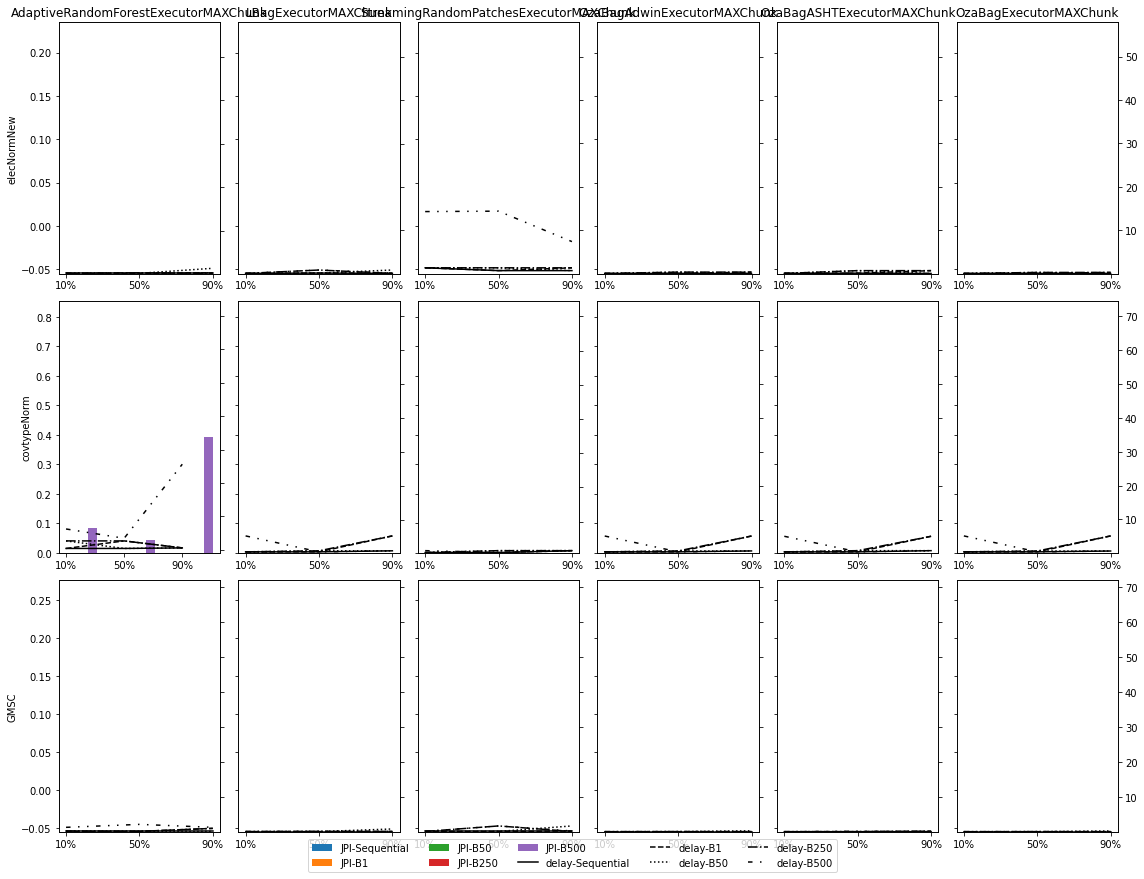

In [181]:
freqs = ['800', '1000', '1200']
for freq, df in zip(freqs,dataframes):
    print(f'\n\n\n----------------- {freq} -----------------')
#     gen_graph(df, bars=True, share_y=False, arch=arch.title())
#     gen_graph(df, bars=True, share_y=False, log_y=True, arch=arch.title())
    gen_graph(df, bars=True, arch=freq.title())

In [210]:
def aux2_tput(df, ax, mTput, legend=False, title=False, ylabels=False, ds='', bar=False, share_y=False, log_y=False, norm=False, hide=True):
    if norm:
        df = my_norm(df, x=norm)
    global rate
    width = 0.15
    alg_order = ['Sequential', 'B1', 'B50', 'B250', 'B500']
    labels = ['10%', '50%', '90%']
    line_format = ['-', '--', ':', '-.', (0, (3, 5, 1, 5, 1, 5))]
    linfo = '--'
    x = np.arange(len(labels))
    lns_l = []
    versions = len(alg_order)

    for i in range(versions):
        try:
            adf = df.iloc[i]
            values = [adf.tput_10, adf.tput_50, adf.tput_90]
            if bar:
                lns_l += ax.bar(x - ((1 - i) * width), values, width, label=f'Tput-{alg_order[i]}')
            else:
                lns_l += ax.plot(x, values, label=f'Tput-{alg_order[i]}')
        except IndexError:
            return None

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    if log_y:
        ax.set_yscale('log')
    if title:
        alg_title = re.sub('Sequential', '', df.algorithm.iloc[0])
        ax.set_title(f'{alg_title}')
    if ylabels:
        ax.set_ylabel(ds)
    if last:
        ax.set_ymargin(2)
    labs = [l.get_label() for l in lns_l]
    if legend:
        ax.legend(lns_l, labs, loc=0)
    if share_y == 'row':
        ax.set_ylim(bottom=0, top=mTput)

In [211]:
def aux_tput(ds, axis, id_ds, df, bar=False, share_y='row', log_y=False, norm=False):
    rates = ['10', '50', '90']
    algs = ['Ada', 'L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
    global title
    global labels
    hide_axis = True
#     get max value from delay for all rates on all algorithms for this dataset
    mLstTput = []
    if share_y == 'row':
        for rt in rates:
            rtDF = df[df.PERC == rt]
            mLstTput.append(rtDF.tput.max())
        mTput = max(mLstTput)*1.05
    else:
        mTput = 0
    for alg in algs:
        dsalgdf = filter_by_substring_algorithm(df, alg).sort_values(['algorithm','batch_size','cores'])
        for rt in rates:
            print(rt)
            if rt == '10':
                showdf = rename_columns_by_rate(dsalgdf[dsalgdf.PERC == rt])
            else:
                to_join = dsalgdf[dsalgdf.PERC == rt]
                showdf = showdf.merge(rename_columns_by_rate(to_join),
                                  on=['algorithm', 'dataset', 'batch_size', 'cores']).sort_values(['batch_size','cores'])
        # debug print, if it shows it is wrong
        if len(showdf) != 5:
            display(showdf)   
        display(showdf[['algorithm','dataset','batch_size','cores','tput_10', 'tput_50', 'tput_90']])
        if 'Ada' in alg:
            aux2_tput(showdf, axis[id_ds][algs.index(alg)], mTput, title=title, ylabels=True, ds=ds, bar=bar, share_y=share_y, log_y=log_y, norm=norm)
        else:
            if algs[-1] == alg:
                hide_axis = False
            aux2_tput(showdf, axis[id_ds][algs.index(alg)], mTput, title=title, bar=bar, share_y=share_y, log_y=log_y, norm=norm, hide=hide_axis)

In [212]:
def show_tput(df, share_y='row', bars=False, log_y=False, norm=False, arch='Vostro'):
    print(f'{arch}\nshare_y: {share_y}\nlog_y: {log_y}\nnorm: {norm}')
    #datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm', 'kyoto_binary']
    datasets = ['GMSC', 'elecNormNew', 'covtypeNorm']
    fig, axis = plt.subplots(len(datasets), 6, figsize=(16,12), tight_layout=True, sharey=share_y)
    global title
    global labels
    global last
    global twin
    leg = False
    labls = True
    title = True
    last = False
    twin = axis[0][0]
#     for ds in ['airlines']:
    for ds in datasets:
        if datasets.index(ds) == (len(datasets) - 1):
            last = True

        dsdf = df[df.dataset == ds]               
        aux_tput(ds, axis, datasets.index(ds), dsdf, bar=bars, share_y=share_y, log_y=log_y, norm=norm)
        title = False
    lines, labels = axis[0][0].get_legend_handles_labels()
    lgd = fig.legend(lines, labels, loc=8, ncol=5, bbox_to_anchor=(0.5, -0.02))
    lgd.set_in_layout(True)
    fig.subplots_adjust(bottom=-0.5)
    filename = 'all-Tput'
    if bars:
        filename = f'bars-{filename}'
    if share_y:
        filename = f'sharey-{filename}'
    if log_y:
        filename = f'logy-{filename}'
    plt.savefig(f'../figures/{arch}-{filename}.eps', pad_inches=0.2, bbox_inches='tight')
    plt.savefig(f'../figures/{arch}-{filename}.png', pad_inches=0.2, bbox_inches='tight')
    plt.show()




----------------- 800 -----------------
800
share_y: row
log_y: False
norm: False
10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,50,288,284.78,"34,143.00",119.89,109.00,126,...,184.00,125,NaN,0.00,159.73,"19,168.00",NaN,NaN,90,159.94
1,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,50,288,284.78,"34,143.00",119.89,109.00,126,...,184.00,125,NaN,0.00,159.73,"19,168.00",NaN,NaN,90,159.94
2,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,500,160,159.98,"19,168.00",119.82,"1,970.00",125,...,"9,074.00",125,3.80,863.40,29.96,"3,600.00",456.31,0.13,90,30.01
3,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,2000,160,159.98,"19,168.00",119.82,"7,854.00",124,...,"35,757.00",125,4.08,913.10,29.96,"3,600.00",489.03,0.14,90,30.01


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,GMSC,50,4,284.78,284.78,159.94
1,AdaptiveRandomForestExecutorMAXChunk,GMSC,50,4,284.78,30.00,159.94
2,AdaptiveRandomForestExecutorMAXChunk,GMSC,500,4,159.98,284.83,30.01
3,AdaptiveRandomForestExecutorMAXChunk,GMSC,2000,4,159.98,281.80,30.01


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,LBagExecutorMAXChunk,GMSC,4,50,378,374.62,"44,925.00",119.92,61.00,128,...,139.00,128,NaN,0.00,209.61,"25,158.00",NaN,NaN,90,209.89
1,LBagExecutorMAXChunk,GMSC,4,50,378,374.62,"44,925.00",119.92,61.00,128,...,652.00,128,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,39.99
2,LBagExecutorMAXChunk,GMSC,4,50,378,374.62,"44,925.00",119.92,61.00,128,...,139.00,128,NaN,0.00,209.61,"25,158.00",NaN,NaN,90,209.89
3,LBagExecutorMAXChunk,GMSC,4,50,378,374.62,"44,925.00",119.92,61.00,128,...,652.00,128,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,39.99
4,LBagExecutorMAXChunk,GMSC,4,50,42,39.99,"4,800.00",120.02,652.00,128,...,139.00,128,NaN,0.00,209.61,"25,158.00",NaN,NaN,90,209.89
5,LBagExecutorMAXChunk,GMSC,4,50,42,39.99,"4,800.00",120.02,652.00,128,...,652.00,128,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,39.99
6,LBagExecutorMAXChunk,GMSC,4,50,42,39.99,"4,800.00",120.02,652.00,128,...,139.00,128,NaN,0.00,209.61,"25,158.00",NaN,NaN,90,209.89
7,LBagExecutorMAXChunk,GMSC,4,50,42,39.99,"4,800.00",120.02,652.00,128,...,652.00,128,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,39.99
8,LBagExecutorMAXChunk,GMSC,4,500,210,209.95,"25,158.00",119.83,"1,483.00",126,...,"6,643.00",126,3.81,834.90,39.94,"4,800.00",457.41,0.10,90,40.01
9,LBagExecutorMAXChunk,GMSC,4,2000,210,209.95,"25,158.00",119.83,"5,972.00",125,...,"25,676.00",126,4.15,950.10,39.94,"4,800.00",497.76,0.10,90,40.01


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,LBagExecutorMAXChunk,GMSC,50,4,374.62,374.62,209.89
1,LBagExecutorMAXChunk,GMSC,50,4,374.62,374.62,39.99
2,LBagExecutorMAXChunk,GMSC,50,4,374.62,209.89,209.89
3,LBagExecutorMAXChunk,GMSC,50,4,374.62,209.89,39.99
4,LBagExecutorMAXChunk,GMSC,50,4,39.99,374.62,209.89
5,LBagExecutorMAXChunk,GMSC,50,4,39.99,374.62,39.99
6,LBagExecutorMAXChunk,GMSC,50,4,39.99,209.89,209.89
7,LBagExecutorMAXChunk,GMSC,50,4,39.99,209.89,39.99
8,LBagExecutorMAXChunk,GMSC,500,4,209.95,374.72,40.01
9,LBagExecutorMAXChunk,GMSC,2000,4,209.95,374.74,40.01


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,90,89.86,"10,783.00",120.00,333.00,125,...,200.00,125,NaN,0.00,159.73,"19,168.00",NaN,NaN,90,159.92
1,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,90,89.86,"10,783.00",120.00,333.00,125,...,"1,776.00",125,NaN,0.00,14.98,"1,800.00",NaN,NaN,90,15.00
2,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,90,89.86,"10,783.00",120.00,333.00,125,...,200.00,125,NaN,0.00,159.73,"19,168.00",NaN,NaN,90,159.92
3,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,90,89.86,"10,783.00",120.00,333.00,125,...,"1,776.00",125,NaN,0.00,14.98,"1,800.00",NaN,NaN,90,15.00
4,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,500,18,15.01,"1,800.00",119.95,"17,999.00",124,...,"2,128.00",125,3.76,850.30,159.73,"19,168.00",450.79,0.02,90,159.98
5,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,2000,18,15.01,"1,800.00",119.96,"69,962.00",134,...,"8,725.00",125,3.95,897.70,159.73,"19,200.00",474.60,0.02,90,159.73


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,GMSC,50,4,89.86,159.92,159.92
1,StreamingRandomPatchesExecutorMAXChunk,GMSC,50,4,89.86,159.92,15.00
2,StreamingRandomPatchesExecutorMAXChunk,GMSC,50,4,89.86,15.00,159.92
3,StreamingRandomPatchesExecutorMAXChunk,GMSC,50,4,89.86,15.00,15.00
4,StreamingRandomPatchesExecutorMAXChunk,GMSC,500,4,15.01,89.85,159.98
5,StreamingRandomPatchesExecutorMAXChunk,GMSC,2000,4,15.01,89.86,159.73


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,968,962.75,"115,414.00",119.88,33.00,128,...,54.00,128,NaN,0.00,533.72,"64,093.00",NaN,NaN,90,534.35
1,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,968,962.75,"115,414.00",119.88,33.00,128,...,251.00,128,NaN,0.00,104.83,"12,600.00",NaN,NaN,90,104.83
2,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,968,962.75,"115,414.00",119.88,33.00,128,...,54.00,128,NaN,0.00,533.72,"64,093.00",NaN,NaN,90,534.35
3,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,968,962.75,"115,414.00",119.88,33.00,128,...,251.00,128,NaN,0.00,104.83,"12,600.00",NaN,NaN,90,104.83
4,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,107,104.83,"12,580.00",120.00,251.00,128,...,54.00,128,NaN,0.00,533.72,"64,093.00",NaN,NaN,90,534.35
5,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,107,104.83,"12,580.00",120.00,251.00,128,...,251.00,128,NaN,0.00,104.83,"12,600.00",NaN,NaN,90,104.83
6,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,107,104.83,"12,580.00",120.00,251.00,128,...,54.00,128,NaN,0.00,533.72,"64,093.00",NaN,NaN,90,534.35
7,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,107,104.83,"12,580.00",120.00,251.00,128,...,251.00,128,NaN,0.00,104.83,"12,600.00",NaN,NaN,90,104.83
8,OzaBagAdwinExecutorMAXChunk,GMSC,4,500,537,533.19,"64,000.00",120.03,572.00,125,...,"2,546.00",126,3.82,875.70,104.83,"12,600.00",458.90,0.04,90,104.83
9,OzaBagAdwinExecutorMAXChunk,GMSC,4,2000,537,532.19,"64,000.00",120.26,"2,331.00",125,...,"10,085.00",126,4.10,934.80,104.83,"12,600.00",492.01,0.04,90,104.83


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagAdwinExecutorMAXChunk,GMSC,50,4,962.75,962.75,534.35
1,OzaBagAdwinExecutorMAXChunk,GMSC,50,4,962.75,962.75,104.83
2,OzaBagAdwinExecutorMAXChunk,GMSC,50,4,962.75,534.35,534.35
3,OzaBagAdwinExecutorMAXChunk,GMSC,50,4,962.75,534.35,104.83
4,OzaBagAdwinExecutorMAXChunk,GMSC,50,4,104.83,962.75,534.35
5,OzaBagAdwinExecutorMAXChunk,GMSC,50,4,104.83,962.75,104.83
6,OzaBagAdwinExecutorMAXChunk,GMSC,50,4,104.83,534.35,534.35
7,OzaBagAdwinExecutorMAXChunk,GMSC,50,4,104.83,534.35,104.83
8,OzaBagAdwinExecutorMAXChunk,GMSC,500,4,533.19,963.02,104.83
9,OzaBagAdwinExecutorMAXChunk,GMSC,2000,4,532.19,963.08,104.83


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1530,"1,525.29","150,000.00",98.34,22.00,106,...,31.00,128,NaN,0.00,847.17,"101,830.00",NaN,NaN,90,847.14
1,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1530,"1,525.29","150,000.00",98.34,22.00,106,...,153.00,128,NaN,0.00,169.71,"20,366.00",NaN,NaN,90,169.97
2,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1530,"1,525.29","150,000.00",98.34,22.00,106,...,31.00,128,NaN,0.00,847.17,"101,830.00",NaN,NaN,90,847.14
3,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1530,"1,525.29","150,000.00",98.34,22.00,106,...,153.00,128,NaN,0.00,169.71,"20,366.00",NaN,NaN,90,169.97
4,OzaBagASHTExecutorMAXChunk,GMSC,4,50,170,169.97,"20,366.00",119.82,153.00,128,...,31.00,128,NaN,0.00,847.17,"101,830.00",NaN,NaN,90,847.14
5,OzaBagASHTExecutorMAXChunk,GMSC,4,50,170,169.97,"20,366.00",119.82,153.00,128,...,153.00,128,NaN,0.00,169.71,"20,366.00",NaN,NaN,90,169.97
6,OzaBagASHTExecutorMAXChunk,GMSC,4,50,170,169.97,"20,366.00",119.82,153.00,128,...,31.00,128,NaN,0.00,847.17,"101,830.00",NaN,NaN,90,847.14
7,OzaBagASHTExecutorMAXChunk,GMSC,4,50,170,169.97,"20,366.00",119.82,153.00,128,...,153.00,128,NaN,0.00,169.71,"20,366.00",NaN,NaN,90,169.97
8,OzaBagASHTExecutorMAXChunk,GMSC,4,500,850,848.17,"101,781.00",120.00,365.00,126,...,"1,590.00",126,3.76,496.20,169.70,"20,366.00",450.42,0.02,90,169.97
9,OzaBagASHTExecutorMAXChunk,GMSC,4,2000,850,848.70,"101,830.00",119.98,"1,532.00",126,...,"6,441.00",125,3.99,901.80,169.71,"20,366.00",478.07,0.02,90,169.99


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagASHTExecutorMAXChunk,GMSC,50,4,"1,525.29","1,525.29",847.14
1,OzaBagASHTExecutorMAXChunk,GMSC,50,4,"1,525.29","1,525.29",169.97
2,OzaBagASHTExecutorMAXChunk,GMSC,50,4,"1,525.29",847.14,847.14
3,OzaBagASHTExecutorMAXChunk,GMSC,50,4,"1,525.29",847.14,169.97
4,OzaBagASHTExecutorMAXChunk,GMSC,50,4,169.97,"1,525.29",847.14
5,OzaBagASHTExecutorMAXChunk,GMSC,50,4,169.97,"1,525.29",169.97
6,OzaBagASHTExecutorMAXChunk,GMSC,50,4,169.97,847.14,847.14
7,OzaBagASHTExecutorMAXChunk,GMSC,50,4,169.97,847.14,169.97
8,OzaBagASHTExecutorMAXChunk,GMSC,500,4,848.17,"1,524.17",169.97
9,OzaBagASHTExecutorMAXChunk,GMSC,2000,4,848.70,"1,520.36",169.99


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagExecutorMAXChunk,GMSC,4,50,977,972.84,"116,610.00",119.86,30.00,126,...,52.00,4917,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,539.38
1,OzaBagExecutorMAXChunk,GMSC,4,50,977,972.84,"116,610.00",119.86,30.00,126,...,248.00,128,NaN,0.00,104.83,"12,600.00",NaN,NaN,90,104.83
2,OzaBagExecutorMAXChunk,GMSC,4,50,108,104.83,"12,580.00",120.00,248.00,128,...,52.00,4917,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,539.38
3,OzaBagExecutorMAXChunk,GMSC,4,50,108,104.83,"12,580.00",120.00,248.00,128,...,248.00,128,NaN,0.00,104.83,"12,600.00",NaN,NaN,90,104.83
4,OzaBagExecutorMAXChunk,GMSC,4,500,977,972.42,"116,610.00",119.92,330.00,125,...,544.00,126,NaN,0.00,538.61,"64,692.00",NaN,NaN,90,539.46
5,OzaBagExecutorMAXChunk,GMSC,4,2000,977,973.19,"116,610.00",119.82,"1,368.00",126,...,"2,210.00",126,4.17,954.00,538.68,"64,692.00",499.53,0.01,90,539.51


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagExecutorMAXChunk,GMSC,50,4,972.84,539.38,539.38
1,OzaBagExecutorMAXChunk,GMSC,50,4,972.84,539.38,104.83
2,OzaBagExecutorMAXChunk,GMSC,50,4,104.83,539.38,539.38
3,OzaBagExecutorMAXChunk,GMSC,50,4,104.83,539.38,104.83
4,OzaBagExecutorMAXChunk,GMSC,500,4,972.42,104.83,539.46
5,OzaBagExecutorMAXChunk,GMSC,2000,4,973.19,105.00,539.51


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,17,15.00,"1,800.00",120.01,"1,797.00",123,...,192.00,124,NaN,0.00,149.73,"17,970.00",NaN,NaN,90,149.92
1,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,500,17,15.01,"1,800.00",119.96,"17,850.00",125,...,"2,257.00",125,NaN,0.00,149.73,"17,970.00",NaN,NaN,90,149.96
2,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,2000,17,15.01,"1,800.00",119.96,"73,957.00",138,...,"9,712.00",126,4.01,914.40,149.73,"17,970.00",480.55,0.03,90,149.97


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,50,4,15.00,84.99,149.92
1,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,500,4,15.01,84.86,149.96
2,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,2000,4,15.01,84.86,149.97


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,LBagExecutorMAXChunk,elecNormNew,4,50,32,30.00,"3,600.00",120.00,880.00,125,...,107.00,126,NaN,0.00,289.35,"34,742.00",NaN,NaN,90,289.73
1,LBagExecutorMAXChunk,elecNormNew,4,500,32,30.01,"3,600.00",119.97,"9,184.00",125,...,"1,169.00",126,NaN,0.00,289.36,"34,742.00",NaN,NaN,90,289.81
2,LBagExecutorMAXChunk,elecNormNew,4,2000,32,30.01,"3,600.00",119.97,"35,733.00",127,...,"4,641.00",126,4.17,954.30,289.36,"34,742.00",499.54,0.01,90,289.80


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,LBagExecutorMAXChunk,elecNormNew,50,4,30.00,159.90,289.73
1,LBagExecutorMAXChunk,elecNormNew,500,4,30.01,159.96,289.81
2,LBagExecutorMAXChunk,elecNormNew,2000,4,30.01,159.96,289.80


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,50,4,19.99,"2,400.00",120.05,"1,359.00",123,...,720.00,124,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,39.98
1,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,500,4,20.01,"2,400.00",119.96,"14,507.00",124,...,"7,534.00",125,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,40.00
2,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,2000,4,20.01,"2,400.00",119.96,"54,293.00",126,...,"29,369.00",127,3.92,901.70,39.94,"4,800.00",470.40,0.10,90,40.00


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,50,4,19.99,19.98,39.98
1,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,500,4,20.01,20.01,40.00
2,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,2000,4,20.01,20.01,40.00


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,79,74.88,"8,986.00",120.01,329.00,125,...,46.00,68,NaN,0.00,712.35,"45,312.00",NaN,NaN,90,714.00
1,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,500,79,74.88,"8,986.00",120.00,"3,561.00",125,...,498.00,69,NaN,0.00,712.49,"45,312.00",NaN,NaN,90,714.59
2,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,2000,79,74.88,"8,986.00",120.01,"13,850.00",126,...,"1,995.00",68,3.92,485.70,712.45,"45,312.00",248.38,0.01,90,713.39


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagAdwinExecutorMAXChunk,elecNormNew,50,4,74.88,394.32,714.00
1,OzaBagAdwinExecutorMAXChunk,elecNormNew,500,4,74.88,394.36,714.59
2,OzaBagAdwinExecutorMAXChunk,elecNormNew,2000,4,74.88,394.40,713.39


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,41,40.00,"4,800.00",119.99,637.00,126,...,75.00,126,NaN,0.00,369.09,"44,326.00",NaN,NaN,90,369.63
1,OzaBagASHTExecutorMAXChunk,elecNormNew,4,500,41,40.01,"4,800.00",119.99,"6,412.00",125,...,794.00,125,NaN,0.00,369.10,"44,326.00",NaN,NaN,90,369.68
2,OzaBagASHTExecutorMAXChunk,elecNormNew,4,2000,41,40.01,"4,800.00",119.98,"24,163.00",126,...,"3,243.00",126,3.93,896.90,369.12,"44,326.00",471.65,0.01,90,369.70


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagASHTExecutorMAXChunk,elecNormNew,50,4,40.00,204.90,369.63
1,OzaBagASHTExecutorMAXChunk,elecNormNew,500,4,40.01,204.91,369.68
2,OzaBagASHTExecutorMAXChunk,elecNormNew,2000,4,40.01,204.92,369.70


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagExecutorMAXChunk,elecNormNew,4,50,95,94.98,"11,381.00",119.82,278.00,126,...,39.00,59,NaN,0.00,855.17,"45,312.00",NaN,NaN,90,857.76
1,OzaBagExecutorMAXChunk,elecNormNew,4,500,95,94.99,"11,381.00",119.82,"2,801.00",126,...,422.00,58,3.90,413.00,855.02,"45,312.00",205.76,0.00,90,858.04
2,OzaBagExecutorMAXChunk,elecNormNew,4,2000,95,94.84,"11,382.00",120.01,"11,380.00",125,...,"1,664.00",58,4.02,425.80,855.28,"45,312.00",212.06,0.00,90,850.37


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagExecutorMAXChunk,elecNormNew,50,4,94.98,474.52,857.76
1,OzaBagExecutorMAXChunk,elecNormNew,500,4,94.99,474.70,858.04
2,OzaBagExecutorMAXChunk,elecNormNew,2000,4,94.84,474.68,850.37


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,50,11,10.00,"1,200.00",120.04,"2,649.00",123,...,318.00,124,NaN,0.00,NaN,NaN,NaN,NaN,90,99.99
1,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,500,11,10.00,"1,200.00",119.94,"25,518.00",125,...,"3,435.00",124,4.24,954.60,99.83,"11,980.00",508.33,0.04,90,99.99
2,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,2000,11,10.00,"1,200.00",119.94,"75,237.00",140,...,"15,358.00",126,3.97,909.40,99.84,"12,000.00",476.55,0.04,90,93.03


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,50,4,10.00,54.96,99.99
1,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,500,4,10.00,55.00,99.99
2,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,2000,4,10.00,55.00,93.03


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,LBagExecutorMAXChunk,covtypeNorm,4,50,7,5.00,600.00,120.01,"5,174.00",125,...,540.00,126,NaN,0.00,64.90,"7,800.00",NaN,NaN,90,64.90
1,LBagExecutorMAXChunk,covtypeNorm,4,500,7,5.00,600.00,119.94,"46,264.00",126,...,"5,311.00",126,4.23,968.00,64.90,"7,800.00",507.23,0.07,90,65.00
2,LBagExecutorMAXChunk,covtypeNorm,4,2000,7,5.00,600.00,119.94,"64,547.00",130,...,"21,406.00",132,4.15,996.90,64.90,"7,800.00",498.44,0.06,90,65.00


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,LBagExecutorMAXChunk,covtypeNorm,50,4,5.00,34.96,64.90
1,LBagExecutorMAXChunk,covtypeNorm,500,4,5.00,35.01,65.00
2,LBagExecutorMAXChunk,covtypeNorm,2000,4,5.00,33.06,65.00


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,4,19.97,"2,400.00",120.21,"1,509.00",124,...,842.00,125,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,39.89
1,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,500,4,20.01,"2,400.00",119.95,"16,107.00",126,...,"8,803.00",126,4.18,956.70,39.94,"4,800.00",501.24,0.10,90,40.01
2,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,2000,4,NaN,NaN,NaN,NaN,4366,...,"34,331.00",127,3.86,888.90,39.94,"4,800.00",463.67,0.10,90,40.01


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,50,4,19.97,19.97,39.89
1,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,500,4,20.01,20.01,40.01
2,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,2000,4,NaN,NaN,40.01


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,6,5.00,600.00,120.07,"5,173.00",125,...,573.00,126,NaN,0.00,54.92,"6,600.00",NaN,NaN,90,54.94
1,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,500,6,5.00,600.00,119.94,"45,632.00",126,...,"6,115.00",126,4.11,903.30,54.92,"6,600.00",492.82,0.08,90,54.15
2,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,2000,6,5.00,600.00,119.94,"63,627.00",128,...,"22,939.00",127,3.87,890.20,54.92,"6,600.00",464.39,0.07,90,55.01


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagAdwinExecutorMAXChunk,covtypeNorm,50,4,5.00,29.98,54.94
1,OzaBagAdwinExecutorMAXChunk,covtypeNorm,500,4,5.00,30.01,54.15
2,OzaBagAdwinExecutorMAXChunk,covtypeNorm,2000,4,5.00,30.01,55.01


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,6,5.00,600.00,120.04,"5,226.00",125,...,590.00,125,3.69,722.30,54.91,"6,600.00",442.84,0.07,90,54.92
1,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,500,6,5.00,600.00,119.93,"46,326.00",126,...,"5,577.00",126,4.14,948.20,54.92,"6,600.00",496.85,0.08,90,55.00
2,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,2000,6,5.00,600.00,119.94,"64,454.00",129,...,"20,981.00",127,3.96,911.00,54.92,"6,600.00",475.26,0.07,90,55.01


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagASHTExecutorMAXChunk,covtypeNorm,50,4,5.00,29.97,54.92
1,OzaBagASHTExecutorMAXChunk,covtypeNorm,500,4,5.00,30.01,55.00
2,OzaBagASHTExecutorMAXChunk,covtypeNorm,2000,4,5.00,30.01,55.01


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagExecutorMAXChunk,covtypeNorm,4,50,10,10.00,"1,200.00",120.03,"2,571.00",126,...,374.00,125,3.86,875.60,89.85,"10,800.00",462.91,0.04,90,89.85
1,OzaBagExecutorMAXChunk,covtypeNorm,4,500,10,10.01,"1,200.00",119.94,"24,036.00",125,...,"3,746.00",126,4.14,942.80,89.85,"10,782.00",495.44,0.05,90,89.99
2,OzaBagExecutorMAXChunk,covtypeNorm,4,2000,10,10.00,"1,200.00",119.94,"63,808.00",129,...,"15,768.00",128,3.94,917.50,89.85,"10,800.00",472.57,0.04,90,89.85


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagExecutorMAXChunk,covtypeNorm,50,4,10.00,49.95,89.85
1,OzaBagExecutorMAXChunk,covtypeNorm,500,4,10.01,49.51,89.99
2,OzaBagExecutorMAXChunk,covtypeNorm,2000,4,10.00,48.14,89.85


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


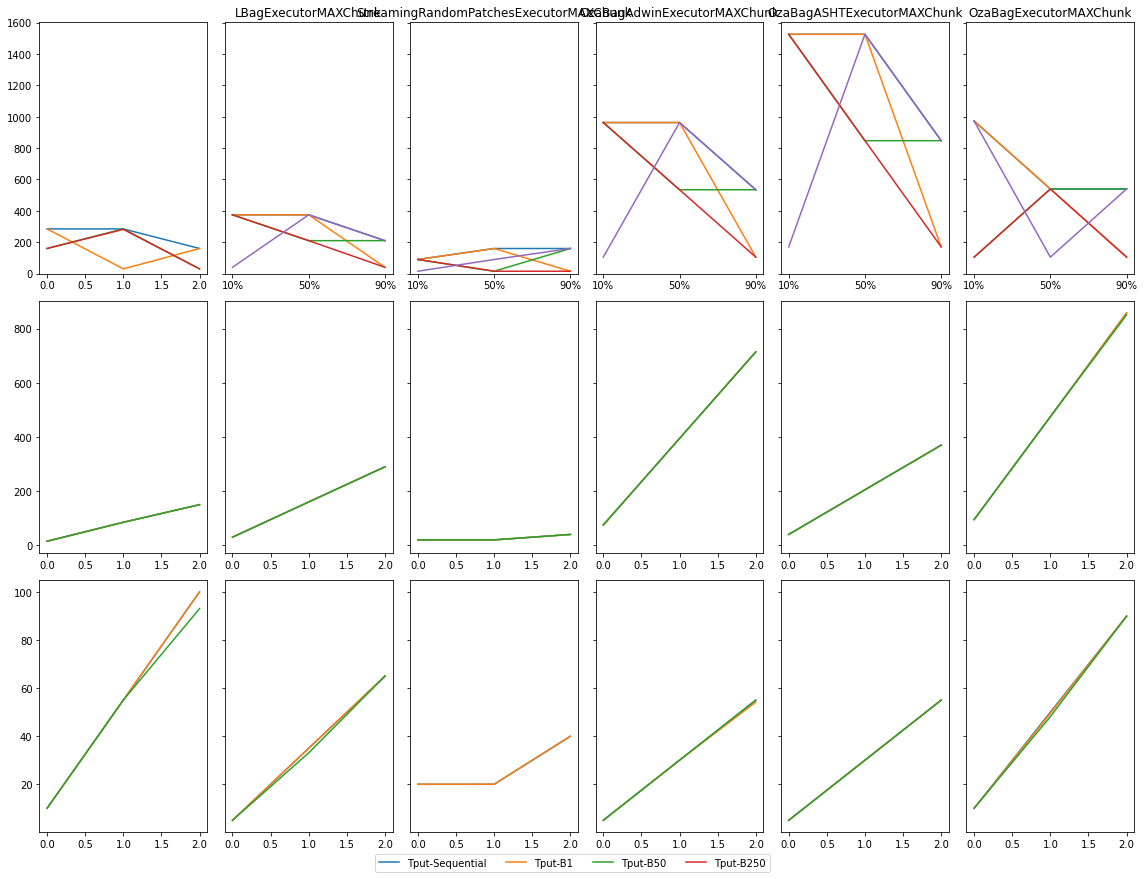




----------------- 1000 -----------------
1000
share_y: row
log_y: False
norm: False
10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,50,32,30.00,"3,600.00",120.00,870.00,140,...,105.00,124,NaN,0.00,289.37,"34,742.00",NaN,NaN,90,289.75
1,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,50,32,30.00,"3,600.00",120.00,870.00,140,...,870.00,140,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,30.00
2,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,500,32,30.01,"3,600.00",119.97,"9,074.00",125,...,"1,213.00",124,NaN,0.00,289.39,"34,742.00",NaN,NaN,90,289.84
3,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,2000,32,30.01,"3,600.00",119.97,"35,813.00",126,...,"4,796.00",124,4.10,921.90,289.40,"34,742.00",491.11,0.01,90,289.85


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,GMSC,50,4,30.00,159.94,289.75
1,AdaptiveRandomForestExecutorMAXChunk,GMSC,50,4,30.00,159.94,30.00
2,AdaptiveRandomForestExecutorMAXChunk,GMSC,500,4,30.01,159.98,289.84
3,AdaptiveRandomForestExecutorMAXChunk,GMSC,2000,4,30.01,159.99,289.85


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,LBagExecutorMAXChunk,GMSC,4,50,41,39.99,"4,800.00",120.02,650.00,125,...,86.00,125,NaN,0.00,369.15,"44,326.00",NaN,NaN,90,369.65
1,LBagExecutorMAXChunk,GMSC,4,500,41,40.01,"4,800.00",119.98,"6,721.00",126,...,927.00,126,NaN,0.00,369.15,"44,326.00",NaN,NaN,90,369.73
2,LBagExecutorMAXChunk,GMSC,4,2000,41,40.01,"4,800.00",119.98,"25,312.00",126,...,"3,724.00",126,4.06,930.40,369.17,"44,326.00",487.79,0.01,90,366.48


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,LBagExecutorMAXChunk,GMSC,50,4,39.99,204.91,369.65
1,LBagExecutorMAXChunk,GMSC,500,4,40.01,204.84,369.73
2,LBagExecutorMAXChunk,GMSC,2000,4,40.01,204.94,366.48


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,14,10.00,"1,200.00",120.03,"2,598.00",124,...,197.00,123,NaN,0.00,69.89,"8,400.00",NaN,NaN,90,124.98
1,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,500,14,10.00,"1,200.00",119.94,"25,462.00",124,...,"2,580.00",125,NaN,0.00,124.79,"14,975.00",NaN,NaN,90,124.99
2,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,2000,14,10.00,"1,200.00",119.95,"68,421.00",132,...,"10,794.00",125,3.95,896.90,124.79,"15,000.00",474.16,0.03,90,124.79


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,GMSC,50,4,10.00,69.93,124.98
1,StreamingRandomPatchesExecutorMAXChunk,GMSC,500,4,10.00,70.00,124.99
2,StreamingRandomPatchesExecutorMAXChunk,GMSC,2000,4,10.00,69.89,124.79


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,110,109.99,"13,178.00",119.82,235.00,126,...,32.00,125,NaN,0.00,991.30,"119,002.00",NaN,NaN,90,992.51
1,OzaBagAdwinExecutorMAXChunk,GMSC,4,500,110,109.82,"13,179.00",120.01,"2,432.00",125,...,338.00,126,NaN,0.00,991.42,"119,002.00",NaN,NaN,90,992.38
2,OzaBagAdwinExecutorMAXChunk,GMSC,4,2000,110,109.82,"13,179.00",120.01,"9,624.00",125,...,"1,372.00",126,3.91,892.40,991.44,"119,002.00",469.05,0.00,90,993.02


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagAdwinExecutorMAXChunk,GMSC,50,4,109.99,549.37,992.51
1,OzaBagAdwinExecutorMAXChunk,GMSC,500,4,109.82,549.44,992.38
2,OzaBagAdwinExecutorMAXChunk,GMSC,2000,4,109.82,549.47,993.02


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagASHTExecutorMAXChunk,GMSC,4,50,153,149.97,"17,970.00",119.82,147.00,126,...,24.00,115,NaN,0.00,"1,372.71","150,000.00",NaN,NaN,90,"1,374.55"
1,OzaBagASHTExecutorMAXChunk,GMSC,4,500,153,149.98,"17,970.00",119.81,"1,793.00",125,...,246.00,115,NaN,0.00,"1,372.85","150,000.00",NaN,NaN,90,"1,374.18"
2,OzaBagASHTExecutorMAXChunk,GMSC,4,2000,153,149.97,"17,970.00",119.82,"7,321.00",126,...,"1,039.00",114,3.84,795.30,"1,372.70","150,000.00",420.38,0.00,90,"1,370.91"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagASHTExecutorMAXChunk,GMSC,50,4,149.97,762.90,"1,374.55"
1,OzaBagASHTExecutorMAXChunk,GMSC,500,4,149.98,762.21,"1,374.18"
2,OzaBagASHTExecutorMAXChunk,GMSC,2000,4,149.97,763.88,"1,370.91"


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagExecutorMAXChunk,GMSC,4,50,109,104.83,"12,580.00",120.01,248.00,126,...,32.00,126,NaN,0.00,981.39,"117,806.00",NaN,NaN,90,982.62
1,OzaBagExecutorMAXChunk,GMSC,4,500,109,105.00,"12,600.00",120.00,"2,544.00",126,...,330.00,126,3.76,26.30,981.54,"117,806.00",450.24,0.00,90,983.06
2,OzaBagExecutorMAXChunk,GMSC,4,2000,109,105.00,"12,600.00",120.00,"10,054.00",126,...,"1,367.00",125,4.10,926.20,981.56,"117,806.00",491.08,0.00,90,983.13


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagExecutorMAXChunk,GMSC,50,4,104.83,544.34,982.62
1,OzaBagExecutorMAXChunk,GMSC,500,4,105.00,544.45,983.06
2,OzaBagExecutorMAXChunk,GMSC,2000,4,105.00,544.46,983.13


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,19,15.00,"1,800.00",120.01,"1,786.00",123,...,179.00,124,NaN,0.00,174.67,"20,965.00",NaN,NaN,90,174.88
1,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,500,19,15.01,"1,800.00",119.96,"18,269.00",124,...,"2,018.00",125,NaN,0.00,174.67,"20,965.00",NaN,NaN,90,174.94
2,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,2000,19,15.01,"1,800.00",119.95,"76,649.00",141,...,"8,056.00",125,3.99,872.90,174.67,"20,965.00",477.65,0.02,90,174.70


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,50,4,15.00,94.99,174.88
1,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,500,4,15.01,94.84,174.94
2,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,2000,4,15.01,94.99,174.70


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,LBagExecutorMAXChunk,elecNormNew,4,50,31,30.00,"3,600.00",120.00,876.00,126,...,109.00,126,NaN,0.00,284.36,"34,143.00",NaN,NaN,90,284.71
1,LBagExecutorMAXChunk,elecNormNew,4,500,31,30.01,"3,600.00",119.97,"9,158.00",126,...,"1,192.00",125,NaN,0.00,284.36,"34,143.00",NaN,NaN,90,284.81
2,LBagExecutorMAXChunk,elecNormNew,4,2000,31,30.01,"3,600.00",119.97,"35,801.00",127,...,"4,753.00",127,4.23,972.40,284.39,"34,143.00",506.79,0.01,90,282.54


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,LBagExecutorMAXChunk,elecNormNew,50,4,30.00,154.93,284.71
1,LBagExecutorMAXChunk,elecNormNew,500,4,30.01,154.96,284.81
2,LBagExecutorMAXChunk,elecNormNew,2000,4,30.01,154.97,282.54


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,50,4,19.99,"2,400.00",120.09,"1,382.00",125,...,734.00,124,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,39.97
1,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,500,4,20.01,"2,400.00",119.96,"14,320.00",125,...,"7,425.00",124,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,40.00
2,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,2000,4,20.01,"2,400.00",119.96,"54,993.00",126,...,"29,240.00",126,3.88,885.70,39.94,"4,800.00",466.10,0.10,90,40.01


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,50,4,19.99,19.98,39.97
1,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,500,4,20.01,20.01,40.00
2,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,2000,4,20.01,20.01,40.01


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,79,74.88,"8,986.00",120.01,330.00,125,...,48.00,69,NaN,0.00,712.52,"45,312.00",NaN,NaN,90,714.09
1,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,500,79,74.88,"8,986.00",120.00,"3,567.00",126,...,493.00,68,NaN,0.00,712.51,"45,312.00",NaN,NaN,90,714.62
2,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,2000,79,74.88,"8,986.00",120.00,"13,821.00",126,...,"1,993.00",68,3.97,491.70,712.50,"45,312.00",251.43,0.01,90,708.93


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagAdwinExecutorMAXChunk,elecNormNew,50,4,74.88,394.29,714.09
1,OzaBagAdwinExecutorMAXChunk,elecNormNew,500,4,74.88,394.39,714.62
2,OzaBagAdwinExecutorMAXChunk,elecNormNew,2000,4,74.88,394.39,708.93


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,41,40.00,"4,800.00",120.00,632.00,125,...,50.00,125,NaN,0.00,374.07,"44,925.00",NaN,NaN,90,374.62
1,OzaBagASHTExecutorMAXChunk,elecNormNew,4,500,41,40.01,"4,800.00",119.99,"6,411.00",126,...,775.00,126,NaN,0.00,374.08,"44,925.00",NaN,NaN,90,374.67
2,OzaBagASHTExecutorMAXChunk,elecNormNew,4,2000,41,40.01,"4,800.00",119.98,"24,383.00",126,...,"3,193.00",125,3.88,879.90,374.11,"44,925.00",464.75,0.01,90,374.69


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagASHTExecutorMAXChunk,elecNormNew,50,4,40.00,204.89,374.62
1,OzaBagASHTExecutorMAXChunk,elecNormNew,500,4,40.01,204.92,374.67
2,OzaBagASHTExecutorMAXChunk,elecNormNew,2000,4,40.01,204.92,374.69


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagExecutorMAXChunk,elecNormNew,4,50,92,89.99,"10,782.00",119.82,286.00,126,...,40.00,60,NaN,0.00,830.06,"45,312.00",NaN,NaN,90,832.73
1,OzaBagExecutorMAXChunk,elecNormNew,4,500,92,89.99,"10,782.00",119.81,"2,947.00",126,...,389.00,60,3.95,434.70,829.91,"45,312.00",215.02,0.00,90,832.77
2,OzaBagExecutorMAXChunk,elecNormNew,4,2000,92,89.99,"10,782.00",119.81,"11,682.00",126,...,"1,655.00",59,3.86,416.80,830.21,"45,312.00",209.92,0.00,90,824.21


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagExecutorMAXChunk,elecNormNew,50,4,89.99,459.16,832.73
1,OzaBagExecutorMAXChunk,elecNormNew,500,4,89.99,459.24,832.77
2,OzaBagExecutorMAXChunk,elecNormNew,2000,4,89.99,459.20,824.21


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,50,12,10.00,"1,200.00",120.04,"2,627.00",124,...,316.00,124,NaN,0.00,109.81,"13,178.00",NaN,NaN,90,109.98
1,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,500,12,10.00,"1,200.00",119.94,"26,232.00",125,...,"3,213.00",125,4.13,937.30,109.81,"13,178.00",494.73,0.04,90,109.99
2,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,2000,12,10.00,"1,200.00",119.94,"71,651.00",136,...,"13,173.00",126,4.00,911.00,109.81,"13,178.00",478.74,0.04,90,109.99


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,50,4,10.00,59.97,109.98
1,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,500,4,10.00,60.00,109.99
2,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,2000,4,10.00,60.00,109.99


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,LBagExecutorMAXChunk,covtypeNorm,4,50,7,5.00,600.00,120.01,"5,183.00",126,...,545.00,126,NaN,0.00,64.90,"7,800.00",NaN,NaN,90,64.92
1,LBagExecutorMAXChunk,covtypeNorm,4,500,7,5.00,600.00,119.94,"47,589.00",126,...,"5,279.00",127,4.05,932.30,64.90,"7,800.00",486.42,0.06,90,65.00
2,LBagExecutorMAXChunk,covtypeNorm,4,2000,7,5.00,600.00,119.94,"65,191.00",130,...,"22,060.00",132,3.96,946.10,64.90,"7,800.00",475.02,0.06,90,65.00


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,LBagExecutorMAXChunk,covtypeNorm,50,4,5.00,34.97,64.92
1,LBagExecutorMAXChunk,covtypeNorm,500,4,5.00,35.01,65.00
2,LBagExecutorMAXChunk,covtypeNorm,2000,4,5.00,33.32,65.00


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,4,19.97,"2,400.00",120.20,"1,519.00",125,...,872.00,125,NaN,0.00,39.95,"4,800.00",NaN,NaN,90,39.93
1,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,500,4,20.01,"2,400.00",119.95,"16,125.00",126,...,"8,792.00",125,4.01,909.70,39.94,"4,800.00",480.81,0.10,90,40.01
2,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,2000,4,NaN,NaN,NaN,NaN,618,...,"34,001.00",128,4.18,969.30,39.95,"4,800.00",501.25,0.10,90,40.01


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,50,4,19.97,19.97,39.93
1,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,500,4,20.01,20.01,40.01
2,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,2000,4,NaN,NaN,40.01


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,6,5.00,600.00,120.06,"5,235.00",125,...,571.00,126,NaN,0.00,54.91,"6,600.00",NaN,NaN,90,54.94
1,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,500,6,5.00,600.00,119.94,"46,542.00",126,...,"6,160.00",125,4.07,923.60,54.92,"6,600.00",488.45,0.08,90,54.14
2,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,2000,6,5.00,600.00,119.94,"63,390.00",128,...,"21,764.00",127,4.40,"1,011.80",54.92,"6,600.00",527.86,0.08,90,55.00


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagAdwinExecutorMAXChunk,covtypeNorm,50,4,5.00,29.98,54.94
1,OzaBagAdwinExecutorMAXChunk,covtypeNorm,500,4,5.00,30.01,54.14
2,OzaBagAdwinExecutorMAXChunk,covtypeNorm,2000,4,5.00,30.01,55.00


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,6,5.00,600.00,120.04,"5,143.00",125,...,547.00,125,NaN,0.00,59.91,"7,200.00",NaN,NaN,90,59.91
1,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,500,6,5.00,600.00,119.94,"45,524.00",126,...,"5,138.00",125,4.04,916.20,59.91,"7,200.00",484.33,0.07,90,60.00
2,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,2000,6,5.00,600.00,119.94,"63,144.00",128,...,"19,913.00",128,4.28,992.90,59.91,"7,200.00",513.57,0.07,90,60.00


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagASHTExecutorMAXChunk,covtypeNorm,50,4,5.00,29.97,59.91
1,OzaBagASHTExecutorMAXChunk,covtypeNorm,500,4,5.00,30.01,60.00
2,OzaBagASHTExecutorMAXChunk,covtypeNorm,2000,4,5.00,30.01,60.00


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagExecutorMAXChunk,covtypeNorm,4,50,9,5.00,600.00,120.02,"5,121.00",125,...,430.00,125,NaN,0.00,84.86,"10,183.00",NaN,NaN,90,84.99
1,OzaBagExecutorMAXChunk,covtypeNorm,4,500,9,5.00,600.00,119.93,"45,555.00",126,...,"4,223.00",125,4.17,924.90,84.86,"10,200.00",499.95,0.05,90,84.87
2,OzaBagExecutorMAXChunk,covtypeNorm,4,2000,9,5.00,600.00,119.93,"63,174.00",129,...,"16,186.00",127,4.10,942.80,84.86,"10,200.00",503.58,0.05,90,81.40


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagExecutorMAXChunk,covtypeNorm,50,4,5.00,44.95,84.99
1,OzaBagExecutorMAXChunk,covtypeNorm,500,4,5.00,45.01,84.87
2,OzaBagExecutorMAXChunk,covtypeNorm,2000,4,5.00,45.01,81.40


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


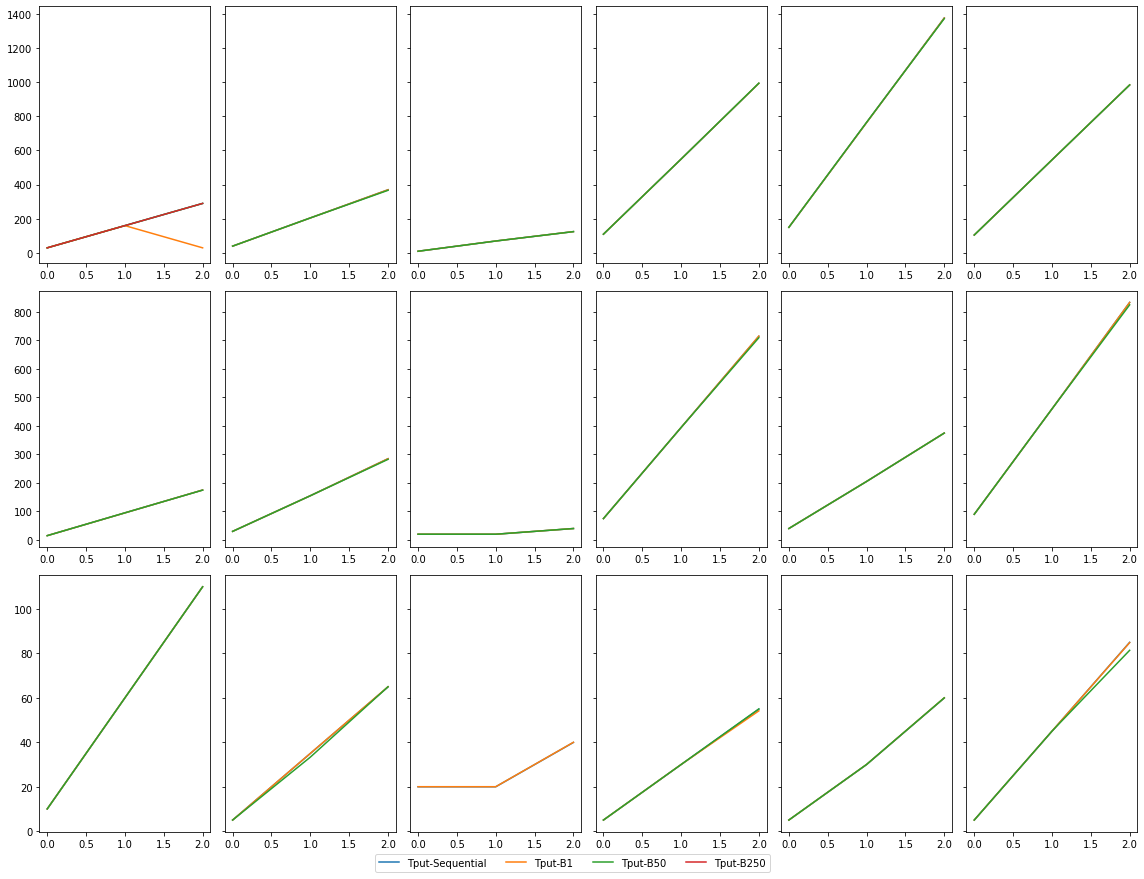




----------------- 1200 -----------------
1200
share_y: row
log_y: False
norm: False
10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,50,267,264.80,"31,747.00",119.89,116.00,125,...,116.00,125,NaN,0.00,264.48,"31,747.00",NaN,NaN,90,264.80
1,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,50,267,264.80,"31,747.00",119.89,116.00,125,...,977.00,124,NaN,0.00,24.97,"3,000.00",NaN,NaN,90,25.00
2,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,50,148,144.95,"17,371.00",119.84,205.00,123,...,116.00,125,NaN,0.00,264.48,"31,747.00",NaN,NaN,90,264.80
3,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,50,148,144.95,"17,371.00",119.84,205.00,123,...,977.00,124,NaN,0.00,24.97,"3,000.00",NaN,NaN,90,25.00
4,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,500,267,264.89,"31,747.00",119.85,"1,274.00",125,...,"1,274.00",125,NaN,0.00,264.46,"31,747.00",NaN,NaN,90,264.89
5,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,500,267,264.89,"31,747.00",119.85,"1,274.00",125,...,"10,899.00",125,NaN,0.00,24.97,"3,000.00",NaN,NaN,90,24.93
6,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,500,267,264.89,"31,747.00",119.85,"1,274.00",125,...,"1,274.00",125,NaN,0.00,264.46,"31,747.00",NaN,NaN,90,264.89
7,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,500,267,264.89,"31,747.00",119.85,"1,274.00",125,...,"10,899.00",125,NaN,0.00,24.97,"3,000.00",NaN,NaN,90,24.93
8,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,500,148,144.76,"17,372.00",120.01,"2,121.00",124,...,"1,274.00",125,NaN,0.00,264.46,"31,747.00",NaN,NaN,90,264.89
9,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,500,148,144.76,"17,372.00",120.01,"2,121.00",124,...,"10,899.00",125,NaN,0.00,24.97,"3,000.00",NaN,NaN,90,24.93


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,GMSC,50,4,264.80,264.80,264.80
1,AdaptiveRandomForestExecutorMAXChunk,GMSC,50,4,264.80,264.80,25.00
2,AdaptiveRandomForestExecutorMAXChunk,GMSC,50,4,144.95,264.80,264.80
3,AdaptiveRandomForestExecutorMAXChunk,GMSC,50,4,144.95,264.80,25.00
4,AdaptiveRandomForestExecutorMAXChunk,GMSC,500,4,264.89,144.76,264.89
5,AdaptiveRandomForestExecutorMAXChunk,GMSC,500,4,264.89,144.76,24.93
6,AdaptiveRandomForestExecutorMAXChunk,GMSC,500,4,264.89,24.93,264.89
7,AdaptiveRandomForestExecutorMAXChunk,GMSC,500,4,264.89,24.93,24.93
8,AdaptiveRandomForestExecutorMAXChunk,GMSC,500,4,144.76,144.76,264.89
9,AdaptiveRandomForestExecutorMAXChunk,GMSC,500,4,144.76,144.76,24.93


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,LBagExecutorMAXChunk,GMSC,4,50,299,294.76,"35,341.00",119.90,106.00,126,...,106.00,126,NaN,0.00,294.38,"35,341.00",NaN,NaN,90,294.76
1,LBagExecutorMAXChunk,GMSC,4,50,299,294.76,"35,341.00",119.90,106.00,126,...,177.00,125,NaN,0.00,164.72,"19,767.00",NaN,NaN,90,164.92
2,LBagExecutorMAXChunk,GMSC,4,50,299,294.76,"35,341.00",119.90,106.00,126,...,856.00,126,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,30.00
3,LBagExecutorMAXChunk,GMSC,4,50,299,294.76,"35,341.00",119.90,106.00,126,...,106.00,126,NaN,0.00,294.38,"35,341.00",NaN,NaN,90,294.76
4,LBagExecutorMAXChunk,GMSC,4,50,299,294.76,"35,341.00",119.90,106.00,126,...,177.00,125,NaN,0.00,164.72,"19,767.00",NaN,NaN,90,164.92
5,LBagExecutorMAXChunk,GMSC,4,50,299,294.76,"35,341.00",119.90,106.00,126,...,856.00,126,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,30.00
6,LBagExecutorMAXChunk,GMSC,4,50,299,294.76,"35,341.00",119.90,106.00,126,...,106.00,126,NaN,0.00,294.38,"35,341.00",NaN,NaN,90,294.76
7,LBagExecutorMAXChunk,GMSC,4,50,299,294.76,"35,341.00",119.90,106.00,126,...,177.00,125,NaN,0.00,164.72,"19,767.00",NaN,NaN,90,164.92
8,LBagExecutorMAXChunk,GMSC,4,50,299,294.76,"35,341.00",119.90,106.00,126,...,856.00,126,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,30.00
9,LBagExecutorMAXChunk,GMSC,4,50,166,164.92,"19,767.00",119.86,177.00,125,...,106.00,126,NaN,0.00,294.38,"35,341.00",NaN,NaN,90,294.76


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,LBagExecutorMAXChunk,GMSC,50,4,294.76,294.76,294.76
1,LBagExecutorMAXChunk,GMSC,50,4,294.76,294.76,164.92
2,LBagExecutorMAXChunk,GMSC,50,4,294.76,294.76,30.00
3,LBagExecutorMAXChunk,GMSC,50,4,294.76,164.92,294.76
4,LBagExecutorMAXChunk,GMSC,50,4,294.76,164.92,164.92
5,LBagExecutorMAXChunk,GMSC,50,4,294.76,164.92,30.00
6,LBagExecutorMAXChunk,GMSC,50,4,294.76,30.00,294.76
7,LBagExecutorMAXChunk,GMSC,50,4,294.76,30.00,164.92
8,LBagExecutorMAXChunk,GMSC,50,4,294.76,30.00,30.00
9,LBagExecutorMAXChunk,GMSC,50,4,164.92,294.76,294.76


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,164,159.92,"19,168.00",119.86,202.00,124,...,202.00,124,NaN,0.00,159.72,"19,168.00",NaN,NaN,90,159.92
1,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,164,159.92,"19,168.00",119.86,202.00,124,...,336.00,123,NaN,0.00,89.85,"10,800.00",NaN,NaN,90,89.85
2,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,164,159.92,"19,168.00",119.86,202.00,124,...,"1,777.00",124,NaN,0.00,14.98,"1,800.00",NaN,NaN,90,14.99
3,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,164,159.92,"19,168.00",119.86,202.00,124,...,202.00,124,NaN,0.00,159.72,"19,168.00",NaN,NaN,90,159.92
4,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,164,159.92,"19,168.00",119.86,202.00,124,...,336.00,123,NaN,0.00,89.85,"10,800.00",NaN,NaN,90,89.85
5,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,164,159.92,"19,168.00",119.86,202.00,124,...,"1,777.00",124,NaN,0.00,14.98,"1,800.00",NaN,NaN,90,14.99
6,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,18,14.99,"1,800.00",120.12,"1,777.00",124,...,202.00,124,NaN,0.00,159.72,"19,168.00",NaN,NaN,90,159.92
7,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,18,14.99,"1,800.00",120.12,"1,777.00",124,...,336.00,123,NaN,0.00,89.85,"10,800.00",NaN,NaN,90,89.85
8,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,18,14.99,"1,800.00",120.12,"1,777.00",124,...,"1,777.00",124,NaN,0.00,14.98,"1,800.00",NaN,NaN,90,14.99
9,StreamingRandomPatchesExecutorMAXChunk,GMSC,4,50,18,14.99,"1,800.00",120.12,"1,777.00",124,...,202.00,124,NaN,0.00,159.72,"19,168.00",NaN,NaN,90,159.92


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,GMSC,50,4,159.92,159.92,159.92
1,StreamingRandomPatchesExecutorMAXChunk,GMSC,50,4,159.92,159.92,89.85
2,StreamingRandomPatchesExecutorMAXChunk,GMSC,50,4,159.92,159.92,14.99
3,StreamingRandomPatchesExecutorMAXChunk,GMSC,50,4,159.92,14.99,159.92
4,StreamingRandomPatchesExecutorMAXChunk,GMSC,50,4,159.92,14.99,89.85
5,StreamingRandomPatchesExecutorMAXChunk,GMSC,50,4,159.92,14.99,14.99
6,StreamingRandomPatchesExecutorMAXChunk,GMSC,50,4,14.99,159.92,159.92
7,StreamingRandomPatchesExecutorMAXChunk,GMSC,50,4,14.99,159.92,89.85
8,StreamingRandomPatchesExecutorMAXChunk,GMSC,50,4,14.99,159.92,14.99
9,StreamingRandomPatchesExecutorMAXChunk,GMSC,50,4,14.99,14.99,159.92


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,824,818.25,"98,200.00",120.01,37.00,126,...,37.00,126,NaN,0.00,817.47,"98,236.00",NaN,NaN,90,818.25
1,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,824,818.25,"98,200.00",120.01,37.00,126,...,63.00,125,NaN,0.00,453.88,"54,509.00",NaN,NaN,90,454.51
2,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,824,818.25,"98,200.00",120.01,37.00,126,...,284.00,126,NaN,0.00,89.86,"10,800.00",NaN,NaN,90,89.99
3,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,824,818.25,"98,200.00",120.01,37.00,126,...,37.00,126,NaN,0.00,817.47,"98,236.00",NaN,NaN,90,818.25
4,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,824,818.25,"98,200.00",120.01,37.00,126,...,63.00,125,NaN,0.00,453.88,"54,509.00",NaN,NaN,90,454.51
5,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,824,818.25,"98,200.00",120.01,37.00,126,...,284.00,126,NaN,0.00,89.86,"10,800.00",NaN,NaN,90,89.99
6,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,824,818.25,"98,200.00",120.01,37.00,126,...,37.00,126,NaN,0.00,817.47,"98,236.00",NaN,NaN,90,818.25
7,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,824,818.25,"98,200.00",120.01,37.00,126,...,63.00,125,NaN,0.00,453.88,"54,509.00",NaN,NaN,90,454.51
8,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,824,818.25,"98,200.00",120.01,37.00,126,...,284.00,126,NaN,0.00,89.86,"10,800.00",NaN,NaN,90,89.99
9,OzaBagAdwinExecutorMAXChunk,GMSC,4,50,457,454.51,"54,509.00",119.93,63.00,125,...,37.00,126,NaN,0.00,817.47,"98,236.00",NaN,NaN,90,818.25


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagAdwinExecutorMAXChunk,GMSC,50,4,818.25,818.25,818.25
1,OzaBagAdwinExecutorMAXChunk,GMSC,50,4,818.25,818.25,454.51
2,OzaBagAdwinExecutorMAXChunk,GMSC,50,4,818.25,818.25,89.99
3,OzaBagAdwinExecutorMAXChunk,GMSC,50,4,818.25,454.51,818.25
4,OzaBagAdwinExecutorMAXChunk,GMSC,50,4,818.25,454.51,454.51
5,OzaBagAdwinExecutorMAXChunk,GMSC,50,4,818.25,454.51,89.99
6,OzaBagAdwinExecutorMAXChunk,GMSC,50,4,818.25,89.99,818.25
7,OzaBagAdwinExecutorMAXChunk,GMSC,50,4,818.25,89.99,454.51
8,OzaBagAdwinExecutorMAXChunk,GMSC,50,4,818.25,89.99,89.99
9,OzaBagAdwinExecutorMAXChunk,GMSC,50,4,454.51,818.25,818.25


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1552,"1,546.42","150,000.00",97.00,21.00,103,...,35.00,124,NaN,0.00,857.15,"103,028.00",NaN,NaN,90,857.08
1,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1552,"1,546.42","150,000.00",97.00,21.00,103,...,154.00,126,NaN,0.00,169.70,"20,366.00",NaN,NaN,90,169.95
2,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1552,"1,546.42","150,000.00",97.00,21.00,103,...,35.00,124,NaN,0.00,857.15,"103,028.00",NaN,NaN,90,857.08
3,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1552,"1,546.42","150,000.00",97.00,21.00,103,...,154.00,126,NaN,0.00,169.70,"20,366.00",NaN,NaN,90,169.95
4,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1552,"1,546.42","150,000.00",97.00,21.00,103,...,35.00,124,NaN,0.00,857.15,"103,028.00",NaN,NaN,90,857.08
5,OzaBagASHTExecutorMAXChunk,GMSC,4,50,1552,"1,546.42","150,000.00",97.00,21.00,103,...,154.00,126,NaN,0.00,169.70,"20,366.00",NaN,NaN,90,169.95
6,OzaBagASHTExecutorMAXChunk,GMSC,4,50,862,857.08,"102,857.00",120.01,35.00,124,...,35.00,124,NaN,0.00,857.15,"103,028.00",NaN,NaN,90,857.08
7,OzaBagASHTExecutorMAXChunk,GMSC,4,50,862,857.08,"102,857.00",120.01,35.00,124,...,154.00,126,NaN,0.00,169.70,"20,366.00",NaN,NaN,90,169.95
8,OzaBagASHTExecutorMAXChunk,GMSC,4,50,862,857.08,"102,857.00",120.01,35.00,124,...,35.00,124,NaN,0.00,857.15,"103,028.00",NaN,NaN,90,857.08
9,OzaBagASHTExecutorMAXChunk,GMSC,4,50,862,857.08,"102,857.00",120.01,35.00,124,...,154.00,126,NaN,0.00,169.70,"20,366.00",NaN,NaN,90,169.95


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagASHTExecutorMAXChunk,GMSC,50,4,"1,546.42","1,546.42",857.08
1,OzaBagASHTExecutorMAXChunk,GMSC,50,4,"1,546.42","1,546.42",169.95
2,OzaBagASHTExecutorMAXChunk,GMSC,50,4,"1,546.42",857.08,857.08
3,OzaBagASHTExecutorMAXChunk,GMSC,50,4,"1,546.42",857.08,169.95
4,OzaBagASHTExecutorMAXChunk,GMSC,50,4,"1,546.42",169.95,857.08
5,OzaBagASHTExecutorMAXChunk,GMSC,50,4,"1,546.42",169.95,169.95
6,OzaBagASHTExecutorMAXChunk,GMSC,50,4,857.08,"1,546.42",857.08
7,OzaBagASHTExecutorMAXChunk,GMSC,50,4,857.08,"1,546.42",169.95
8,OzaBagASHTExecutorMAXChunk,GMSC,50,4,857.08,857.08,857.08
9,OzaBagASHTExecutorMAXChunk,GMSC,50,4,857.08,857.08,169.95


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagExecutorMAXChunk,GMSC,4,50,1019,"1,012.42","121,394.00",119.90,31.00,126,...,31.00,126,NaN,0.00,"1,011.27","121,394.00",NaN,NaN,90,"1,012.42"
1,OzaBagExecutorMAXChunk,GMSC,4,50,1019,"1,012.42","121,394.00",119.90,31.00,126,...,51.00,125,NaN,0.00,563.49,"67,687.00",NaN,NaN,90,564.26
2,OzaBagExecutorMAXChunk,GMSC,4,50,1019,"1,012.42","121,394.00",119.90,31.00,126,...,233.00,126,NaN,0.00,109.81,"13,178.00",NaN,NaN,90,109.99
3,OzaBagExecutorMAXChunk,GMSC,4,50,1019,"1,012.42","121,394.00",119.90,31.00,126,...,31.00,126,NaN,0.00,"1,011.27","121,394.00",NaN,NaN,90,"1,012.42"
4,OzaBagExecutorMAXChunk,GMSC,4,50,1019,"1,012.42","121,394.00",119.90,31.00,126,...,51.00,125,NaN,0.00,563.49,"67,687.00",NaN,NaN,90,564.26
5,OzaBagExecutorMAXChunk,GMSC,4,50,1019,"1,012.42","121,394.00",119.90,31.00,126,...,233.00,126,NaN,0.00,109.81,"13,178.00",NaN,NaN,90,109.99
6,OzaBagExecutorMAXChunk,GMSC,4,50,1019,"1,012.42","121,394.00",119.90,31.00,126,...,31.00,126,NaN,0.00,"1,011.27","121,394.00",NaN,NaN,90,"1,012.42"
7,OzaBagExecutorMAXChunk,GMSC,4,50,1019,"1,012.42","121,394.00",119.90,31.00,126,...,51.00,125,NaN,0.00,563.49,"67,687.00",NaN,NaN,90,564.26
8,OzaBagExecutorMAXChunk,GMSC,4,50,1019,"1,012.42","121,394.00",119.90,31.00,126,...,233.00,126,NaN,0.00,109.81,"13,178.00",NaN,NaN,90,109.99
9,OzaBagExecutorMAXChunk,GMSC,4,50,566,564.26,"67,687.00",119.96,51.00,125,...,31.00,126,NaN,0.00,"1,011.27","121,394.00",NaN,NaN,90,"1,012.42"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagExecutorMAXChunk,GMSC,50,4,"1,012.42","1,012.42","1,012.42"
1,OzaBagExecutorMAXChunk,GMSC,50,4,"1,012.42","1,012.42",564.26
2,OzaBagExecutorMAXChunk,GMSC,50,4,"1,012.42","1,012.42",109.99
3,OzaBagExecutorMAXChunk,GMSC,50,4,"1,012.42",564.26,"1,012.42"
4,OzaBagExecutorMAXChunk,GMSC,50,4,"1,012.42",564.26,564.26
5,OzaBagExecutorMAXChunk,GMSC,50,4,"1,012.42",564.26,109.99
6,OzaBagExecutorMAXChunk,GMSC,50,4,"1,012.42",109.99,"1,012.42"
7,OzaBagExecutorMAXChunk,GMSC,50,4,"1,012.42",109.99,564.26
8,OzaBagExecutorMAXChunk,GMSC,50,4,"1,012.42",109.99,109.99
9,OzaBagExecutorMAXChunk,GMSC,50,4,564.26,"1,012.42","1,012.42"


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,192,189.82,"22,762.00",119.92,171.00,124,...,171.00,124,NaN,0.00,189.63,"22,762.00",NaN,NaN,90,189.82
1,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,192,189.82,"22,762.00",119.92,171.00,124,...,294.00,125,NaN,0.00,104.82,"12,579.00",NaN,NaN,90,104.98
2,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,192,189.82,"22,762.00",119.92,171.00,124,...,"1,331.00",124,NaN,0.00,19.97,"2,400.00",NaN,NaN,90,19.99
3,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,192,189.82,"22,762.00",119.92,171.00,124,...,171.00,124,NaN,0.00,189.63,"22,762.00",NaN,NaN,90,189.82
4,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,192,189.82,"22,762.00",119.92,171.00,124,...,294.00,125,NaN,0.00,104.82,"12,579.00",NaN,NaN,90,104.98
5,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,192,189.82,"22,762.00",119.92,171.00,124,...,"1,331.00",124,NaN,0.00,19.97,"2,400.00",NaN,NaN,90,19.99
6,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,192,189.82,"22,762.00",119.92,171.00,124,...,171.00,124,NaN,0.00,189.63,"22,762.00",NaN,NaN,90,189.82
7,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,192,189.82,"22,762.00",119.92,171.00,124,...,294.00,125,NaN,0.00,104.82,"12,579.00",NaN,NaN,90,104.98
8,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,192,189.82,"22,762.00",119.92,171.00,124,...,"1,331.00",124,NaN,0.00,19.97,"2,400.00",NaN,NaN,90,19.99
9,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,50,107,104.98,"12,579.00",119.82,294.00,125,...,171.00,124,NaN,0.00,189.63,"22,762.00",NaN,NaN,90,189.82


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,50,4,189.82,189.82,189.82
1,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,50,4,189.82,189.82,104.98
2,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,50,4,189.82,189.82,19.99
3,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,50,4,189.82,104.98,189.82
4,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,50,4,189.82,104.98,104.98
5,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,50,4,189.82,104.98,19.99
6,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,50,4,189.82,19.99,189.82
7,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,50,4,189.82,19.99,104.98
8,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,50,4,189.82,19.99,19.99
9,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,50,4,104.98,189.82,189.82


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,LBagExecutorMAXChunk,elecNormNew,4,50,303,299.76,"35,940.00",119.90,98.00,126,...,98.00,126,NaN,0.00,299.33,"35,940.00",NaN,NaN,90,299.76
1,LBagExecutorMAXChunk,elecNormNew,4,50,303,299.76,"35,940.00",119.90,98.00,126,...,180.00,126,NaN,0.00,164.69,"19,767.00",NaN,NaN,90,164.90
2,LBagExecutorMAXChunk,elecNormNew,4,50,303,299.76,"35,940.00",119.90,98.00,126,...,880.00,9353,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,30.00
3,LBagExecutorMAXChunk,elecNormNew,4,50,303,299.76,"35,940.00",119.90,98.00,126,...,98.00,126,NaN,0.00,299.33,"35,940.00",NaN,NaN,90,299.76
4,LBagExecutorMAXChunk,elecNormNew,4,50,303,299.76,"35,940.00",119.90,98.00,126,...,180.00,126,NaN,0.00,164.69,"19,767.00",NaN,NaN,90,164.90
5,LBagExecutorMAXChunk,elecNormNew,4,50,303,299.76,"35,940.00",119.90,98.00,126,...,880.00,9353,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,30.00
6,LBagExecutorMAXChunk,elecNormNew,4,50,168,164.90,"19,767.00",119.87,180.00,126,...,98.00,126,NaN,0.00,299.33,"35,940.00",NaN,NaN,90,299.76
7,LBagExecutorMAXChunk,elecNormNew,4,50,168,164.90,"19,767.00",119.87,180.00,126,...,180.00,126,NaN,0.00,164.69,"19,767.00",NaN,NaN,90,164.90
8,LBagExecutorMAXChunk,elecNormNew,4,50,168,164.90,"19,767.00",119.87,180.00,126,...,880.00,9353,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,30.00
9,LBagExecutorMAXChunk,elecNormNew,4,50,168,164.90,"19,767.00",119.87,180.00,126,...,98.00,126,NaN,0.00,299.33,"35,940.00",NaN,NaN,90,299.76


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,LBagExecutorMAXChunk,elecNormNew,50,4,299.76,164.90,299.76
1,LBagExecutorMAXChunk,elecNormNew,50,4,299.76,164.90,164.90
2,LBagExecutorMAXChunk,elecNormNew,50,4,299.76,164.90,30.00
3,LBagExecutorMAXChunk,elecNormNew,50,4,299.76,30.00,299.76
4,LBagExecutorMAXChunk,elecNormNew,50,4,299.76,30.00,164.90
5,LBagExecutorMAXChunk,elecNormNew,50,4,299.76,30.00,30.00
6,LBagExecutorMAXChunk,elecNormNew,50,4,164.90,164.90,299.76
7,LBagExecutorMAXChunk,elecNormNew,50,4,164.90,164.90,164.90
8,LBagExecutorMAXChunk,elecNormNew,50,4,164.90,164.90,30.00
9,LBagExecutorMAXChunk,elecNormNew,50,4,164.90,30.00,299.76


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,50,23,19.99,"2,400.00",120.04,"1,365.00",124,...,715.00,123,NaN,0.00,19.97,"2,400.00",NaN,NaN,90,39.98
1,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,50,23,19.99,"2,400.00",120.04,"1,365.00",124,...,"1,360.00",123,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.99
2,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,50,23,19.99,"2,400.00",120.04,"1,365.00",124,...,715.00,123,NaN,0.00,19.97,"2,400.00",NaN,NaN,90,39.98
3,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,50,23,19.99,"2,400.00",120.04,"1,365.00",124,...,"1,360.00",123,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.99
4,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,500,4,20.01,"2,400.00",119.96,"14,311.00",125,...,"7,397.00",124,NaN,0.00,39.94,"4,800.00",NaN,NaN,90,40.01
5,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,2000,4,20.01,"2,400.00",119.96,"55,137.00",125,...,"29,458.00",125,3.92,857.80,39.94,"4,800.00",469.96,0.10,90,40.01


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,50,4,19.99,39.98,39.98
1,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,50,4,19.99,39.98,19.99
2,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,50,4,19.99,19.99,39.98
3,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,50,4,19.99,19.99,19.99
4,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,500,4,20.01,20.01,40.01
5,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,2000,4,20.01,20.01,40.01


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,668,663.87,"45,312.00",68.25,49.00,73,...,49.00,73,NaN,0.00,662.40,"45,312.00",NaN,NaN,90,663.87
1,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,668,663.87,"45,312.00",68.25,49.00,73,...,371.00,126,NaN,0.00,69.89,"8,400.00",NaN,NaN,90,69.89
2,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,668,663.87,"45,312.00",68.25,49.00,73,...,49.00,73,NaN,0.00,662.40,"45,312.00",NaN,NaN,90,663.87
3,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,668,663.87,"45,312.00",68.25,49.00,73,...,371.00,126,NaN,0.00,69.89,"8,400.00",NaN,NaN,90,69.89
4,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,371,369.65,"44,326.00",119.92,78.00,126,...,49.00,73,NaN,0.00,662.40,"45,312.00",NaN,NaN,90,663.87
5,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,371,369.65,"44,326.00",119.92,78.00,126,...,371.00,126,NaN,0.00,69.89,"8,400.00",NaN,NaN,90,69.89
6,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,371,369.65,"44,326.00",119.92,78.00,126,...,49.00,73,NaN,0.00,662.40,"45,312.00",NaN,NaN,90,663.87
7,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,50,371,369.65,"44,326.00",119.92,78.00,126,...,371.00,126,NaN,0.00,69.89,"8,400.00",NaN,NaN,90,69.89
8,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,500,668,664.21,"45,312.00",68.22,508.00,73,...,824.00,126,NaN,0.00,369.08,"44,326.00",NaN,NaN,90,369.66
9,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,2000,668,641.99,"44,088.00",68.67,"2,126.00",73,...,"3,342.00",126,3.93,896.20,369.08,"44,326.00",471.31,0.01,90,369.67


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagAdwinExecutorMAXChunk,elecNormNew,50,4,663.87,369.65,663.87
1,OzaBagAdwinExecutorMAXChunk,elecNormNew,50,4,663.87,369.65,69.89
2,OzaBagAdwinExecutorMAXChunk,elecNormNew,50,4,663.87,69.89,663.87
3,OzaBagAdwinExecutorMAXChunk,elecNormNew,50,4,663.87,69.89,69.89
4,OzaBagAdwinExecutorMAXChunk,elecNormNew,50,4,369.65,369.65,663.87
5,OzaBagAdwinExecutorMAXChunk,elecNormNew,50,4,369.65,369.65,69.89
6,OzaBagAdwinExecutorMAXChunk,elecNormNew,50,4,369.65,69.89,663.87
7,OzaBagAdwinExecutorMAXChunk,elecNormNew,50,4,369.65,69.89,69.89
8,OzaBagAdwinExecutorMAXChunk,elecNormNew,500,4,664.21,69.89,369.66
9,OzaBagAdwinExecutorMAXChunk,elecNormNew,2000,4,641.99,69.89,369.67


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,320,319.77,"38,336.00",119.89,85.00,126,...,85.00,126,NaN,0.00,319.28,"38,336.00",NaN,NaN,90,319.77
1,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,320,319.77,"38,336.00",119.89,85.00,126,...,733.00,126,NaN,0.00,34.95,"4,200.00",NaN,NaN,90,35.00
2,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,320,319.77,"38,336.00",119.89,85.00,126,...,85.00,126,NaN,0.00,319.28,"38,336.00",NaN,NaN,90,319.77
3,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,320,319.77,"38,336.00",119.89,85.00,126,...,733.00,126,NaN,0.00,34.95,"4,200.00",NaN,NaN,90,35.00
4,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,178,174.93,"20,965.00",119.85,142.00,125,...,85.00,126,NaN,0.00,319.28,"38,336.00",NaN,NaN,90,319.77
5,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,178,174.93,"20,965.00",119.85,142.00,125,...,733.00,126,NaN,0.00,34.95,"4,200.00",NaN,NaN,90,35.00
6,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,178,174.93,"20,965.00",119.85,142.00,125,...,85.00,126,NaN,0.00,319.28,"38,336.00",NaN,NaN,90,319.77
7,OzaBagASHTExecutorMAXChunk,elecNormNew,4,50,178,174.93,"20,965.00",119.85,142.00,125,...,733.00,126,NaN,0.00,34.95,"4,200.00",NaN,NaN,90,35.00
8,OzaBagASHTExecutorMAXChunk,elecNormNew,4,500,320,319.75,"38,336.00",119.89,904.00,126,...,"1,567.00",125,NaN,0.00,174.67,"20,965.00",NaN,NaN,90,174.95
9,OzaBagASHTExecutorMAXChunk,elecNormNew,4,2000,320,319.77,"38,336.00",119.89,"3,642.00",125,...,"6,265.00",126,3.84,875.40,174.67,"20,965.00",460.10,0.02,90,174.95


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagASHTExecutorMAXChunk,elecNormNew,50,4,319.77,174.93,319.77
1,OzaBagASHTExecutorMAXChunk,elecNormNew,50,4,319.77,174.93,35.00
2,OzaBagASHTExecutorMAXChunk,elecNormNew,50,4,319.77,35.00,319.77
3,OzaBagASHTExecutorMAXChunk,elecNormNew,50,4,319.77,35.00,35.00
4,OzaBagASHTExecutorMAXChunk,elecNormNew,50,4,174.93,174.93,319.77
5,OzaBagASHTExecutorMAXChunk,elecNormNew,50,4,174.93,174.93,35.00
6,OzaBagASHTExecutorMAXChunk,elecNormNew,50,4,174.93,35.00,319.77
7,OzaBagASHTExecutorMAXChunk,elecNormNew,50,4,174.93,35.00,35.00
8,OzaBagASHTExecutorMAXChunk,elecNormNew,500,4,319.75,35.01,174.95
9,OzaBagASHTExecutorMAXChunk,elecNormNew,2000,4,319.77,35.01,174.95


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagExecutorMAXChunk,elecNormNew,4,50,852,848.11,"45,312.00",53.43,35.00,59,...,35.00,59,NaN,0.00,845.42,"45,312.00",NaN,NaN,90,848.11
1,OzaBagExecutorMAXChunk,elecNormNew,4,50,852,848.11,"45,312.00",53.43,35.00,59,...,287.00,125,NaN,0.00,89.84,"10,782.00",NaN,NaN,90,89.99
2,OzaBagExecutorMAXChunk,elecNormNew,4,50,852,848.11,"45,312.00",53.43,35.00,59,...,35.00,59,NaN,0.00,845.42,"45,312.00",NaN,NaN,90,848.11
3,OzaBagExecutorMAXChunk,elecNormNew,4,50,852,848.11,"45,312.00",53.43,35.00,59,...,287.00,125,NaN,0.00,89.84,"10,782.00",NaN,NaN,90,89.99
4,OzaBagExecutorMAXChunk,elecNormNew,4,50,473,468.73,"45,312.00",96.67,61.00,102,...,35.00,59,NaN,0.00,845.42,"45,312.00",NaN,NaN,90,848.11
5,OzaBagExecutorMAXChunk,elecNormNew,4,50,473,468.73,"45,312.00",96.67,61.00,102,...,287.00,125,NaN,0.00,89.84,"10,782.00",NaN,NaN,90,89.99
6,OzaBagExecutorMAXChunk,elecNormNew,4,50,473,468.73,"45,312.00",96.67,61.00,102,...,35.00,59,NaN,0.00,845.42,"45,312.00",NaN,NaN,90,848.11
7,OzaBagExecutorMAXChunk,elecNormNew,4,50,473,468.73,"45,312.00",96.67,61.00,102,...,287.00,125,NaN,0.00,89.84,"10,782.00",NaN,NaN,90,89.99
8,OzaBagExecutorMAXChunk,elecNormNew,4,500,852,848.51,"45,312.00",53.40,410.00,59,...,652.00,102,3.74,78.60,467.83,"45,312.00",361.80,0.01,90,468.76
9,OzaBagExecutorMAXChunk,elecNormNew,4,2000,852,832.15,"44,437.00",53.40,"1,721.00",58,...,"2,615.00",103,3.98,745.00,467.79,"45,312.00",385.15,0.01,90,468.71


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagExecutorMAXChunk,elecNormNew,50,4,848.11,468.73,848.11
1,OzaBagExecutorMAXChunk,elecNormNew,50,4,848.11,468.73,89.99
2,OzaBagExecutorMAXChunk,elecNormNew,50,4,848.11,89.99,848.11
3,OzaBagExecutorMAXChunk,elecNormNew,50,4,848.11,89.99,89.99
4,OzaBagExecutorMAXChunk,elecNormNew,50,4,468.73,468.73,848.11
5,OzaBagExecutorMAXChunk,elecNormNew,50,4,468.73,468.73,89.99
6,OzaBagExecutorMAXChunk,elecNormNew,50,4,468.73,89.99,848.11
7,OzaBagExecutorMAXChunk,elecNormNew,50,4,468.73,89.99,89.99
8,OzaBagExecutorMAXChunk,elecNormNew,500,4,848.51,89.99,468.76
9,OzaBagExecutorMAXChunk,elecNormNew,2000,4,832.15,89.99,468.71


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,50,96,94.84,"11,382.00",120.01,371.00,124,...,531.00,125,NaN,0.00,49.93,"6,000.00",NaN,NaN,90,49.95
1,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,50,96,94.84,"11,382.00",120.01,371.00,124,...,531.00,125,NaN,0.00,49.93,"6,000.00",NaN,NaN,90,49.95
2,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,50,10,9.99,"1,200.00",120.07,"2,630.00",123,...,531.00,125,NaN,0.00,49.93,"6,000.00",NaN,NaN,90,49.95
3,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,50,10,9.99,"1,200.00",120.07,"2,630.00",123,...,531.00,125,NaN,0.00,49.93,"6,000.00",NaN,NaN,90,49.95
4,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,500,53,49.63,"6,000.00",120.90,"6,205.00",125,...,"25,606.00",125,3.91,883.50,9.99,"1,200.00",468.88,0.39,90,10.01
5,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,4,2000,53,48.83,"6,000.00",122.89,"26,106.00",127,...,"70,864.00",135,4.02,982.00,9.99,"1,200.00",482.74,0.40,90,10.00


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,50,4,94.84,94.84,49.95
1,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,50,4,94.84,9.99,49.95
2,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,50,4,9.99,94.84,49.95
3,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,50,4,9.99,9.99,49.95
4,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,500,4,49.63,94.85,10.01
5,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,2000,4,48.83,94.85,10.00


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,LBagExecutorMAXChunk,covtypeNorm,4,50,63,59.88,"7,200.00",120.24,559.00,125,...,867.00,126,NaN,0.00,34.95,"4,200.00",NaN,NaN,90,34.96
1,LBagExecutorMAXChunk,covtypeNorm,4,50,63,59.88,"7,200.00",120.24,559.00,125,...,"5,261.00",125,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
2,LBagExecutorMAXChunk,covtypeNorm,4,50,63,59.88,"7,200.00",120.24,559.00,125,...,867.00,126,NaN,0.00,34.95,"4,200.00",NaN,NaN,90,34.96
3,LBagExecutorMAXChunk,covtypeNorm,4,50,63,59.88,"7,200.00",120.24,559.00,125,...,"5,261.00",125,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
4,LBagExecutorMAXChunk,covtypeNorm,4,50,7,5.00,600.00,120.06,"5,261.00",125,...,867.00,126,NaN,0.00,34.95,"4,200.00",NaN,NaN,90,34.96
5,LBagExecutorMAXChunk,covtypeNorm,4,50,7,5.00,600.00,120.06,"5,261.00",125,...,"5,261.00",125,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
6,LBagExecutorMAXChunk,covtypeNorm,4,50,7,5.00,600.00,120.06,"5,261.00",125,...,867.00,126,NaN,0.00,34.95,"4,200.00",NaN,NaN,90,34.96
7,LBagExecutorMAXChunk,covtypeNorm,4,50,7,5.00,600.00,120.06,"5,261.00",125,...,"5,261.00",125,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
8,LBagExecutorMAXChunk,covtypeNorm,4,500,35,35.01,"4,200.00",119.97,"8,600.00",126,...,"46,334.00",125,3.89,880.20,4.99,600.00,467.12,0.78,90,5.00
9,LBagExecutorMAXChunk,covtypeNorm,4,2000,35,33.14,"4,000.00",120.69,"36,422.00",126,...,"63,891.00",129,4.06,950.50,4.99,600.00,487.16,0.81,90,5.00


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,LBagExecutorMAXChunk,covtypeNorm,50,4,59.88,59.88,34.96
1,LBagExecutorMAXChunk,covtypeNorm,50,4,59.88,59.88,5.00
2,LBagExecutorMAXChunk,covtypeNorm,50,4,59.88,34.96,34.96
3,LBagExecutorMAXChunk,covtypeNorm,50,4,59.88,34.96,5.00
4,LBagExecutorMAXChunk,covtypeNorm,50,4,5.00,59.88,34.96
5,LBagExecutorMAXChunk,covtypeNorm,50,4,5.00,59.88,5.00
6,LBagExecutorMAXChunk,covtypeNorm,50,4,5.00,34.96,34.96
7,LBagExecutorMAXChunk,covtypeNorm,50,4,5.00,34.96,5.00
8,LBagExecutorMAXChunk,covtypeNorm,500,4,35.01,59.98,5.00
9,LBagExecutorMAXChunk,covtypeNorm,2000,4,33.14,60.00,5.00


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,37,34.95,"4,200.00",120.16,940.00,124,...,"1,499.00",125,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.98
1,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,37,34.95,"4,200.00",120.16,940.00,124,...,"1,497.00",125,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.97
2,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,37,34.95,"4,200.00",120.16,940.00,124,...,"1,499.00",125,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.98
3,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,37,34.95,"4,200.00",120.16,940.00,124,...,"1,497.00",125,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.97
4,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,4,19.97,"2,400.00",120.17,"1,497.00",125,...,"1,499.00",125,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.98
5,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,4,19.97,"2,400.00",120.17,"1,497.00",125,...,"1,497.00",125,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.97
6,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,4,19.97,"2,400.00",120.17,"1,497.00",125,...,"1,499.00",125,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.98
7,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,50,4,19.97,"2,400.00",120.17,"1,497.00",125,...,"1,497.00",125,NaN,0.00,19.98,"2,400.00",NaN,NaN,90,19.97
8,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,500,20,20.01,"2,400.00",119.96,"15,730.00",126,...,"15,843.00",126,3.92,893.70,19.98,"2,400.00",470.18,0.20,90,20.01
9,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,2000,20,NaN,NaN,NaN,NaN,1234,...,NaN,22558,3.89,"157,269.00",19.98,"2,400.00",NaN,NaN,90,NaN


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,50,4,34.95,34.95,19.98
1,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,50,4,34.95,34.95,19.97
2,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,50,4,34.95,19.98,19.98
3,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,50,4,34.95,19.98,19.97
4,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,50,4,19.97,34.95,19.98
5,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,50,4,19.97,34.95,19.97
6,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,50,4,19.97,19.98,19.98
7,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,50,4,19.97,19.98,19.97
8,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,500,4,20.01,35.01,20.01
9,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,2000,4,NaN,32.38,NaN


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,72,69.94,"8,400.00",120.11,502.00,125,...,775.00,126,NaN,0.00,39.95,"4,800.00",NaN,NaN,90,39.95
1,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,72,69.94,"8,400.00",120.11,502.00,125,...,"5,178.00",125,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
2,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,72,69.94,"8,400.00",120.11,502.00,125,...,775.00,126,NaN,0.00,39.95,"4,800.00",NaN,NaN,90,39.95
3,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,72,69.94,"8,400.00",120.11,502.00,125,...,"5,178.00",125,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
4,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,8,5.00,600.00,120.07,"5,178.00",125,...,775.00,126,NaN,0.00,39.95,"4,800.00",NaN,NaN,90,39.95
5,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,8,5.00,600.00,120.07,"5,178.00",125,...,"5,178.00",125,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
6,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,8,5.00,600.00,120.07,"5,178.00",125,...,775.00,126,NaN,0.00,39.95,"4,800.00",NaN,NaN,90,39.95
7,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,50,8,5.00,600.00,120.07,"5,178.00",125,...,"5,178.00",125,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
8,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,500,40,40.01,"4,800.00",119.98,"7,628.00",126,...,"45,779.00",126,4.00,913.10,4.99,600.00,480.31,0.80,90,5.00
9,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,2000,40,40.01,"4,800.00",119.98,"26,766.00",128,...,"63,524.00",129,3.72,871.40,4.99,600.00,446.64,0.74,90,5.00


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagAdwinExecutorMAXChunk,covtypeNorm,50,4,69.94,69.94,39.95
1,OzaBagAdwinExecutorMAXChunk,covtypeNorm,50,4,69.94,69.94,5.00
2,OzaBagAdwinExecutorMAXChunk,covtypeNorm,50,4,69.94,39.95,39.95
3,OzaBagAdwinExecutorMAXChunk,covtypeNorm,50,4,69.94,39.95,5.00
4,OzaBagAdwinExecutorMAXChunk,covtypeNorm,50,4,5.00,69.94,39.95
5,OzaBagAdwinExecutorMAXChunk,covtypeNorm,50,4,5.00,69.94,5.00
6,OzaBagAdwinExecutorMAXChunk,covtypeNorm,50,4,5.00,39.95,39.95
7,OzaBagAdwinExecutorMAXChunk,covtypeNorm,50,4,5.00,39.95,5.00
8,OzaBagAdwinExecutorMAXChunk,covtypeNorm,500,4,40.01,70.00,5.00
9,OzaBagAdwinExecutorMAXChunk,covtypeNorm,2000,4,40.01,66.39,5.00


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,60,59.92,"7,200.00",120.17,549.00,126,...,908.00,125,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,29.98
1,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,60,59.92,"7,200.00",120.17,549.00,126,...,"5,146.00",126,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
2,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,60,59.92,"7,200.00",120.17,549.00,126,...,908.00,125,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,29.98
3,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,60,59.92,"7,200.00",120.17,549.00,126,...,"5,146.00",126,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
4,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,6,5.00,600.00,120.04,"5,146.00",126,...,908.00,125,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,29.98
5,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,6,5.00,600.00,120.04,"5,146.00",126,...,"5,146.00",126,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
6,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,6,5.00,600.00,120.04,"5,146.00",126,...,908.00,125,NaN,0.00,29.96,"3,600.00",NaN,NaN,90,29.98
7,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,50,6,5.00,600.00,120.04,"5,146.00",126,...,"5,146.00",126,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
8,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,500,33,30.01,"3,600.00",119.96,"9,301.00",125,...,"45,521.00",126,4.04,920.50,4.99,600.00,484.21,0.81,90,5.00
9,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,2000,33,30.01,"3,600.00",119.96,"34,419.00",129,...,"63,103.00",129,3.72,871.50,4.99,600.00,446.70,0.74,90,5.00


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagASHTExecutorMAXChunk,covtypeNorm,50,4,59.92,59.92,29.98
1,OzaBagASHTExecutorMAXChunk,covtypeNorm,50,4,59.92,59.92,5.00
2,OzaBagASHTExecutorMAXChunk,covtypeNorm,50,4,59.92,29.98,29.98
3,OzaBagASHTExecutorMAXChunk,covtypeNorm,50,4,59.92,29.98,5.00
4,OzaBagASHTExecutorMAXChunk,covtypeNorm,50,4,5.00,59.92,29.98
5,OzaBagASHTExecutorMAXChunk,covtypeNorm,50,4,5.00,59.92,5.00
6,OzaBagASHTExecutorMAXChunk,covtypeNorm,50,4,5.00,29.98,29.98
7,OzaBagASHTExecutorMAXChunk,covtypeNorm,50,4,5.00,29.98,5.00
8,OzaBagASHTExecutorMAXChunk,covtypeNorm,500,4,30.01,60.00,5.00
9,OzaBagASHTExecutorMAXChunk,covtypeNorm,2000,4,30.01,60.00,5.00


10
50
90


,algorithm,dataset,cores,batch_size,inc_rate_x,out_rate_10,instances_10,time_x,delay_10,duration_x,...,delay_90,duration,avg_measure,sum_measure,prod_rate,tt_inst_prod,joules_90,JPI_90,PERC,tput_90
0,OzaBagExecutorMAXChunk,covtypeNorm,4,50,81,79.99,"9,584.00",119.82,440.00,126,...,688.00,125,NaN,0.00,44.94,"5,400.00",NaN,NaN,90,44.94
1,OzaBagExecutorMAXChunk,covtypeNorm,4,50,81,79.99,"9,584.00",119.82,440.00,126,...,"5,148.00",126,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
2,OzaBagExecutorMAXChunk,covtypeNorm,4,50,81,79.99,"9,584.00",119.82,440.00,126,...,688.00,125,NaN,0.00,44.94,"5,400.00",NaN,NaN,90,44.94
3,OzaBagExecutorMAXChunk,covtypeNorm,4,50,81,79.99,"9,584.00",119.82,440.00,126,...,"5,148.00",126,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
4,OzaBagExecutorMAXChunk,covtypeNorm,4,50,9,5.00,600.00,120.05,"5,148.00",126,...,688.00,125,NaN,0.00,44.94,"5,400.00",NaN,NaN,90,44.94
5,OzaBagExecutorMAXChunk,covtypeNorm,4,50,9,5.00,600.00,120.05,"5,148.00",126,...,"5,148.00",126,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
6,OzaBagExecutorMAXChunk,covtypeNorm,4,50,9,5.00,600.00,120.05,"5,148.00",126,...,688.00,125,NaN,0.00,44.94,"5,400.00",NaN,NaN,90,44.94
7,OzaBagExecutorMAXChunk,covtypeNorm,4,50,9,5.00,600.00,120.05,"5,148.00",126,...,"5,148.00",126,NaN,0.00,4.99,600.00,NaN,NaN,90,5.00
8,OzaBagExecutorMAXChunk,covtypeNorm,4,500,45,45.01,"5,400.00",119.97,"6,848.00",126,...,"45,731.00",126,4.01,877.70,4.99,600.00,480.67,0.80,90,5.00
9,OzaBagExecutorMAXChunk,covtypeNorm,4,2000,45,45.01,"5,400.00",119.98,"24,870.00",128,...,"63,181.00",128,3.73,864.60,4.99,600.00,446.97,0.74,90,5.00


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagExecutorMAXChunk,covtypeNorm,50,4,79.99,79.99,44.94
1,OzaBagExecutorMAXChunk,covtypeNorm,50,4,79.99,79.99,5.00
2,OzaBagExecutorMAXChunk,covtypeNorm,50,4,79.99,44.94,44.94
3,OzaBagExecutorMAXChunk,covtypeNorm,50,4,79.99,44.94,5.00
4,OzaBagExecutorMAXChunk,covtypeNorm,50,4,5.00,79.99,44.94
5,OzaBagExecutorMAXChunk,covtypeNorm,50,4,5.00,79.99,5.00
6,OzaBagExecutorMAXChunk,covtypeNorm,50,4,5.00,44.94,44.94
7,OzaBagExecutorMAXChunk,covtypeNorm,50,4,5.00,44.94,5.00
8,OzaBagExecutorMAXChunk,covtypeNorm,500,4,45.01,80.00,5.00
9,OzaBagExecutorMAXChunk,covtypeNorm,2000,4,45.01,79.87,5.00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


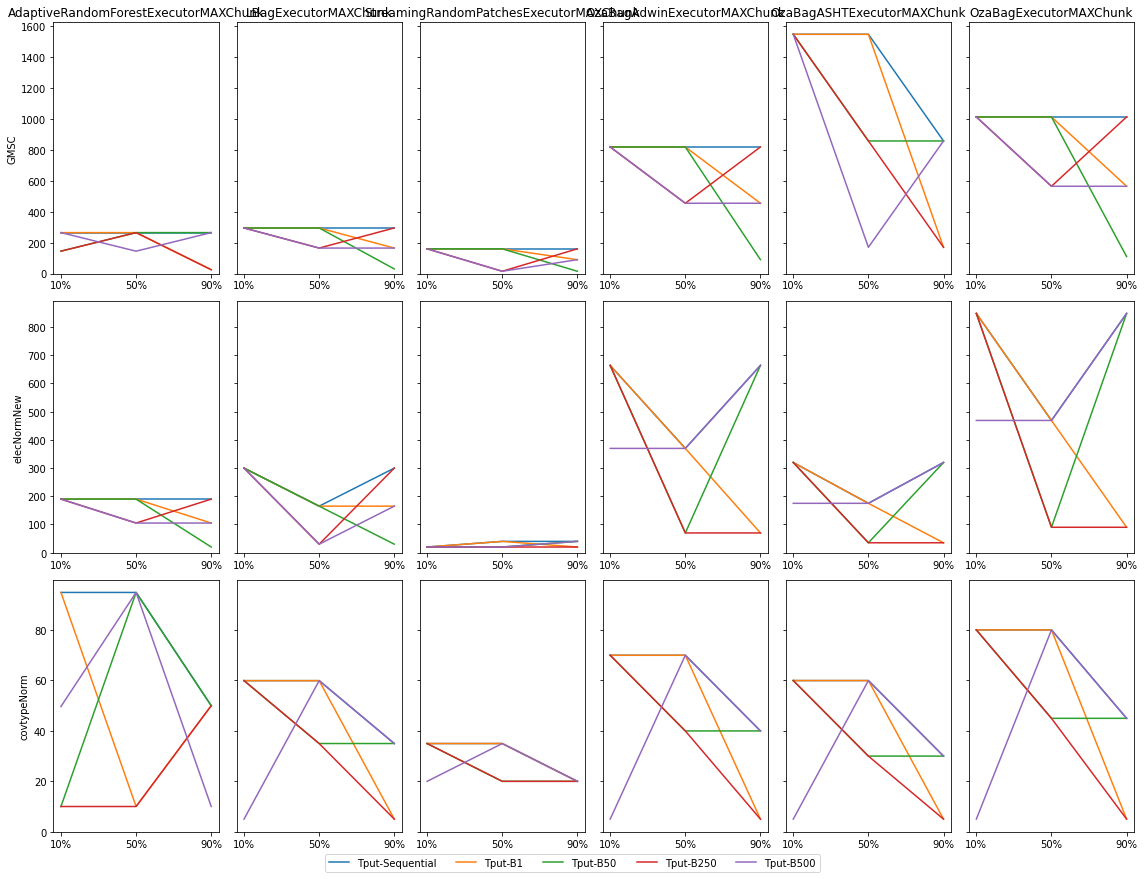

In [213]:
for freq,df in zip(freqs,dataframes):
    print(f'\n\n\n----------------- {freq} -----------------')
    show_tput(df, arch=freq.title())

d = {}
header_printed = False
moaDF = read_MOA(f"{PATH_TO_RESULTS}/Energy/vostro/socket", f"{PATH_TO_RESULTS}/Energy/vostro/inst-and-delay.csv")
moaDF = moaDF[["algorithm", "dataset", "cores", "batch_size", "inc_rate", "out_rate", "instances", "time", "delay"]]
measureDF = load_Wmeas(f'{PATH_TO_RESULTS}/Energy/vostro/Wm-vostro.log')
d = exper_order_to_dict(f'{PATH_TO_RESULTS}/Energy/vostro/exper_order-vostro.log', d)
d = populate_dict(d, measureDF)
mdf = append_dict_to_df(d)
sshDF = parse_SSH(f'{PATH_TO_RESULTS}/Energy/vostro/ssh-log-vostro')
sshDF['batch_size'] = sshDF['batch_size'].astype(int)

#join dfs
finaldf = moaDF.merge(mdf, on=['algorithm', 'dataset', 'cores', 'batch_size', 'inc_rate'])
finaldf = finaldf.merge(sshDF, 'left', on=['algorithm', 'dataset', 'batch_size', 'inc_rate'])
finaldf['joules'] = finaldf['avg_measure'] * finaldf['time']
finaldf['JPI'] = finaldf['joules'] / finaldf['instances']

### Add PERC column to identify if it used 90, 50 or 10% max rate

- Before merging rows with the same batch size, we need to differentiate the experiments with different work loads
- We use the **PERC**entage column for that

tdf = finaldf.sort_values(by=['dataset','algorithm','batch_size','inc_rate'], ascending=False)
tdf['PERC'] = 0
masks = {'90':[], '50': [], '10': []}
for k, v in zip(masks.keys(), [0, 1, 2]):
    for i in range(len(tdf)):
        masks[k].append(i % 3 == v)
tdf.loc[masks['90'],'PERC'] = '90'
tdf.loc[masks['50'],'PERC'] = '50'
tdf.loc[masks['10'],'PERC'] = '10'

Sharey = row

Linear scale

gen_graph(bars=True)

sharey = False

linear scale

gen_graph(bars=True, share_y=False)

sharey = false

log scale y

gen_graph(bars=True, share_y=False, log_y=True)

gen_graph(bars=True)

def table_delta_rates_vert(ratio=False):
    rates = ['10', '50', '90']
    algs = ['Ada', 'L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm','kyoto_binary']
    all_values = []
    # filtra algoritmo
    for alg in algs:
        line = '\hline\n\\multirow{3}{*}{' + alg + '} '
        algdf = filter_by_substring_algorithm(tdf, alg).sort_values(['algorithm','batch_size','cores'])
#         display(algdf)
        # filtra rate
        for rt in rates:
            if rt != '10':
                line += '\\\\\n'
            line += f' & {rt} '
            rtalgdf = rename_columns_by_rate(algdf[algdf.PERC == rt])
            # filtra dataset
            for ds in datasets:
#                 print(ds)
                dsrtalgdf = rtalgdf[rtalgdf.dataset == ds]
#                 display(dsrtalgdf)
                minoutro = min(dsrtalgdf[dsrtalgdf.batch_size == 1][f'JPI_{rt}'])
#                 print(f"JPI_{rt} minoutro {minoutro}")
                val = ((dsrtalgdf[dsrtalgdf.batch_size != 1][f'JPI_{rt}'].iloc[0] - minoutro)/minoutro)*100 if ratio else dsrtalgdf[dsrtalgdf.batch_size != 1][f'JPI_{rt}'].iloc[0] - minoutro 
                all_values.append(val)
                sval = f"{val:.2f} " if val < 0 else "\\textbf{ " + f"{val:.2f}" + "} "
                line += f"& {sval} "
        print(f"{line} \\\\")
    print(f'\n\nAverage reduction: {sum(all_values)/len(all_values)}')

table_delta_rates_vert()